# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from tqdm import tqdm

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in tqdm(sorted(glob("dogImages/train/*/")))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.
100%|████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<?, ?it/s]


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [8]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

lfw\Laurence_Fishburne\Laurence_Fishburne_0001.jpg
Number of faces detected: 1




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

73 68 108 108




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]

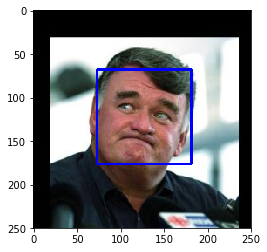

In [9]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
print(human_files[3])
img = cv2.imread(human_files[599])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in tqdm(faces):
    print(x,y,w,h)
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [27]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
humanInHumans = np.sum([face_detector(i) for i in tqdm(human_files_short)])
humanInDogs =np.sum([face_detector(i) for i in tqdm(dog_files_short)])

print("%d of the first 100 images in human_files have a detected human face" % humanInHumans)
print("%d of the first 100 images in dog_files have a detected human face" % humanInDogs)

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


99 of the first 100 images in human_files have a detected human face
11 of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [26]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [43]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [42]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    print((np.expand_dims(x, axis=0)).shape)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [40]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [33]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dogInHumans = np.sum([dog_detector(img) for img in tqdm(human_files_short)])
dogInDogs = np.sum([dog_detector(img) for img in tqdm(dog_files_short)])

print("%d of the images in human_files_short have a detected dog." % dogInHumans)
print("%d of the images in dog_files_short have a detected dog." % dogInDogs)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

(1, 224, 224, 3)


  1%|▊                                                                                 | 1/100 [00:04<07:43,  4.68s/it]

(1, 224, 224, 3)


  2%|█▋                                                                                | 2/100 [00:05<05:45,  3.53s/it]

(1, 224, 224, 3)


  3%|██▍                                                                               | 3/100 [00:06<04:21,  2.69s/it]

(1, 224, 224, 3)


  4%|███▎                                                                              | 4/100 [00:07<03:26,  2.15s/it]

(1, 224, 224, 3)


  5%|████                                                                              | 5/100 [00:08<02:48,  1.78s/it]

(1, 224, 224, 3)


  6%|████▉                                                                             | 6/100 [00:09<02:24,  1.54s/it]

(1, 224, 224, 3)


  7%|█████▋                                                                            | 7/100 [00:09<02:07,  1.37s/it]

(1, 224, 224, 3)


  8%|██████▌                                                                           | 8/100 [00:10<01:52,  1.22s/it]

(1, 224, 224, 3)


  9%|███████▍                                                                          | 9/100 [00:11<01:44,  1.14s/it]

(1, 224, 224, 3)


 10%|████████                                                                         | 10/100 [00:12<01:35,  1.06s/it]

(1, 224, 224, 3)


 11%|████████▉                                                                        | 11/100 [00:13<01:29,  1.01s/it]

(1, 224, 224, 3)


 12%|█████████▋                                                                       | 12/100 [00:14<01:26,  1.01it/s]

(1, 224, 224, 3)


 13%|██████████▌                                                                      | 13/100 [00:15<01:22,  1.06it/s]

(1, 224, 224, 3)


 14%|███████████▎                                                                     | 14/100 [00:16<01:17,  1.11it/s]

(1, 224, 224, 3)


 15%|████████████▏                                                                    | 15/100 [00:17<01:15,  1.12it/s]

(1, 224, 224, 3)


 16%|████████████▉                                                                    | 16/100 [00:17<01:12,  1.16it/s]

(1, 224, 224, 3)


 17%|█████████████▊                                                                   | 17/100 [00:18<01:09,  1.20it/s]

(1, 224, 224, 3)


 18%|██████████████▌                                                                  | 18/100 [00:19<01:07,  1.21it/s]

(1, 224, 224, 3)


 19%|███████████████▍                                                                 | 19/100 [00:20<01:06,  1.22it/s]

(1, 224, 224, 3)


 20%|████████████████▏                                                                | 20/100 [00:21<01:04,  1.23it/s]

(1, 224, 224, 3)


 21%|█████████████████                                                                | 21/100 [00:21<01:04,  1.23it/s]

(1, 224, 224, 3)


 22%|█████████████████▊                                                               | 22/100 [00:22<01:02,  1.24it/s]

(1, 224, 224, 3)


 23%|██████████████████▋                                                              | 23/100 [00:23<01:01,  1.25it/s]

(1, 224, 224, 3)


 24%|███████████████████▍                                                             | 24/100 [00:24<01:00,  1.25it/s]

(1, 224, 224, 3)


 25%|████████████████████▎                                                            | 25/100 [00:25<01:00,  1.25it/s]

(1, 224, 224, 3)


 26%|█████████████████████                                                            | 26/100 [00:25<00:58,  1.26it/s]

(1, 224, 224, 3)


 27%|█████████████████████▊                                                           | 27/100 [00:26<00:57,  1.27it/s]

(1, 224, 224, 3)


 28%|██████████████████████▋                                                          | 28/100 [00:27<00:56,  1.27it/s]

(1, 224, 224, 3)


 29%|███████████████████████▍                                                         | 29/100 [00:28<00:55,  1.27it/s]

(1, 224, 224, 3)


 30%|████████████████████████▎                                                        | 30/100 [00:28<00:54,  1.28it/s]

(1, 224, 224, 3)


 31%|█████████████████████████                                                        | 31/100 [00:29<00:53,  1.28it/s]

(1, 224, 224, 3)


 32%|█████████████████████████▉                                                       | 32/100 [00:30<00:52,  1.28it/s]

(1, 224, 224, 3)


 33%|██████████████████████████▋                                                      | 33/100 [00:31<00:52,  1.28it/s]

(1, 224, 224, 3)


 34%|███████████████████████████▌                                                     | 34/100 [00:32<00:51,  1.29it/s]

(1, 224, 224, 3)


 35%|████████████████████████████▎                                                    | 35/100 [00:32<00:51,  1.27it/s]

(1, 224, 224, 3)


 36%|█████████████████████████████▏                                                   | 36/100 [00:33<00:50,  1.27it/s]

(1, 224, 224, 3)


 37%|█████████████████████████████▉                                                   | 37/100 [00:34<00:49,  1.28it/s]

(1, 224, 224, 3)


 38%|██████████████████████████████▊                                                  | 38/100 [00:35<00:48,  1.28it/s]

(1, 224, 224, 3)


 39%|███████████████████████████████▌                                                 | 39/100 [00:35<00:47,  1.28it/s]

(1, 224, 224, 3)


 40%|████████████████████████████████▍                                                | 40/100 [00:36<00:46,  1.28it/s]

(1, 224, 224, 3)


 41%|█████████████████████████████████▏                                               | 41/100 [00:37<00:45,  1.28it/s]

(1, 224, 224, 3)


 42%|██████████████████████████████████                                               | 42/100 [00:38<00:45,  1.28it/s]

(1, 224, 224, 3)


 43%|██████████████████████████████████▊                                              | 43/100 [00:39<00:44,  1.29it/s]

(1, 224, 224, 3)


 44%|███████████████████████████████████▋                                             | 44/100 [00:39<00:43,  1.28it/s]

(1, 224, 224, 3)


 45%|████████████████████████████████████▍                                            | 45/100 [00:40<00:42,  1.29it/s]

(1, 224, 224, 3)


 46%|█████████████████████████████████████▎                                           | 46/100 [00:41<00:41,  1.29it/s]

(1, 224, 224, 3)


 47%|██████████████████████████████████████                                           | 47/100 [00:42<00:41,  1.28it/s]

(1, 224, 224, 3)


 48%|██████████████████████████████████████▉                                          | 48/100 [00:42<00:40,  1.28it/s]

(1, 224, 224, 3)


 49%|███████████████████████████████████████▋                                         | 49/100 [00:43<00:39,  1.28it/s]

(1, 224, 224, 3)


 50%|████████████████████████████████████████▌                                        | 50/100 [00:44<00:38,  1.28it/s]

(1, 224, 224, 3)


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:45<00:38,  1.28it/s]

(1, 224, 224, 3)


 52%|██████████████████████████████████████████                                       | 52/100 [00:46<00:37,  1.29it/s]

(1, 224, 224, 3)


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:46<00:36,  1.28it/s]

(1, 224, 224, 3)


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:47<00:35,  1.28it/s]

(1, 224, 224, 3)


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:48<00:35,  1.28it/s]

(1, 224, 224, 3)


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:49<00:34,  1.28it/s]

(1, 224, 224, 3)


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:49<00:33,  1.28it/s]

(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:50<00:32,  1.28it/s]

(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:51<00:32,  1.28it/s]

(1, 224, 224, 3)


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:52<00:31,  1.27it/s]

(1, 224, 224, 3)


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:53<00:30,  1.28it/s]

(1, 224, 224, 3)


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:53<00:29,  1.28it/s]

(1, 224, 224, 3)


 63%|███████████████████████████████████████████████████                              | 63/100 [00:54<00:28,  1.28it/s]

(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:55<00:28,  1.28it/s]

(1, 224, 224, 3)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:56<00:27,  1.28it/s]

(1, 224, 224, 3)


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:56<00:26,  1.28it/s]

(1, 224, 224, 3)


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:57<00:25,  1.27it/s]

(1, 224, 224, 3)


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:58<00:25,  1.28it/s]

(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:59<00:24,  1.27it/s]

(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:00<00:23,  1.28it/s]

(1, 224, 224, 3)


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:00<00:22,  1.27it/s]

(1, 224, 224, 3)


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:01<00:21,  1.28it/s]

(1, 224, 224, 3)


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:02<00:21,  1.28it/s]

(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:03<00:20,  1.28it/s]

(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:04<00:19,  1.28it/s]

(1, 224, 224, 3)


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:04<00:18,  1.28it/s]

(1, 224, 224, 3)


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:05<00:17,  1.29it/s]

(1, 224, 224, 3)


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:06<00:17,  1.28it/s]

(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:07<00:16,  1.28it/s]

(1, 224, 224, 3)


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:07<00:15,  1.28it/s]

(1, 224, 224, 3)


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:08<00:14,  1.27it/s]

(1, 224, 224, 3)


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:09<00:14,  1.28it/s]

(1, 224, 224, 3)


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:10<00:13,  1.27it/s]

(1, 224, 224, 3)


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:11<00:12,  1.27it/s]

(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:11<00:11,  1.26it/s]

(1, 224, 224, 3)


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:12<00:11,  1.23it/s]

(1, 224, 224, 3)


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:13<00:11,  1.14it/s]

(1, 224, 224, 3)


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:14<00:11,  1.07it/s]

(1, 224, 224, 3)


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:15<00:10,  1.04it/s]

(1, 224, 224, 3)


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:16<00:09,  1.06it/s]

(1, 224, 224, 3)


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:17<00:08,  1.04it/s]

(1, 224, 224, 3)


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:18<00:07,  1.03it/s]

(1, 224, 224, 3)


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:19<00:07,  1.01s/it]

(1, 224, 224, 3)


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:20<00:05,  1.02it/s]

(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:21<00:04,  1.01it/s]

(1, 224, 224, 3)


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:22<00:03,  1.03it/s]

(1, 224, 224, 3)


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:23<00:02,  1.06it/s]

(1, 224, 224, 3)


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:24<00:01,  1.08it/s]

(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:25<00:00,  1.09it/s]

(1, 224, 224, 3)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

(1, 224, 224, 3)


  1%|▊                                                                                 | 1/100 [00:00<01:31,  1.08it/s]

(1, 224, 224, 3)


  2%|█▋                                                                                | 2/100 [00:01<01:29,  1.09it/s]

(1, 224, 224, 3)


  3%|██▍                                                                               | 3/100 [00:02<01:27,  1.10it/s]

(1, 224, 224, 3)


  4%|███▎                                                                              | 4/100 [00:03<01:24,  1.14it/s]

(1, 224, 224, 3)


  5%|████                                                                              | 5/100 [00:04<01:22,  1.16it/s]

(1, 224, 224, 3)


  6%|████▉                                                                             | 6/100 [00:05<01:20,  1.17it/s]

(1, 224, 224, 3)


  7%|█████▋                                                                            | 7/100 [00:06<01:18,  1.18it/s]

(1, 224, 224, 3)


  8%|██████▌                                                                           | 8/100 [00:06<01:16,  1.20it/s]

(1, 224, 224, 3)


  9%|███████▍                                                                          | 9/100 [00:07<01:17,  1.17it/s]

(1, 224, 224, 3)


 10%|████████                                                                         | 10/100 [00:08<01:19,  1.14it/s]

(1, 224, 224, 3)


 11%|████████▉                                                                        | 11/100 [00:09<01:17,  1.15it/s]

(1, 224, 224, 3)


 12%|█████████▋                                                                       | 12/100 [00:10<01:16,  1.16it/s]

(1, 224, 224, 3)


 13%|██████████▌                                                                      | 13/100 [00:11<01:16,  1.14it/s]

(1, 224, 224, 3)


 14%|███████████▎                                                                     | 14/100 [00:12<01:18,  1.10it/s]

(1, 224, 224, 3)


 15%|████████████▏                                                                    | 15/100 [00:13<01:17,  1.09it/s]

(1, 224, 224, 3)


 16%|████████████▉                                                                    | 16/100 [00:14<01:17,  1.09it/s]

(1, 224, 224, 3)


 17%|█████████████▊                                                                   | 17/100 [00:14<01:13,  1.12it/s]

(1, 224, 224, 3)


 18%|██████████████▌                                                                  | 18/100 [00:15<01:11,  1.15it/s]

(1, 224, 224, 3)


 19%|███████████████▍                                                                 | 19/100 [00:16<01:09,  1.16it/s]

(1, 224, 224, 3)


 20%|████████████████▏                                                                | 20/100 [00:17<01:09,  1.15it/s]

(1, 224, 224, 3)


 21%|█████████████████                                                                | 21/100 [00:18<01:08,  1.15it/s]

(1, 224, 224, 3)


 22%|█████████████████▊                                                               | 22/100 [00:19<01:07,  1.16it/s]

(1, 224, 224, 3)


 23%|██████████████████▋                                                              | 23/100 [00:20<01:06,  1.16it/s]

(1, 224, 224, 3)


 24%|███████████████████▍                                                             | 24/100 [00:20<01:04,  1.18it/s]

(1, 224, 224, 3)


 25%|████████████████████▎                                                            | 25/100 [00:21<01:04,  1.17it/s]

(1, 224, 224, 3)


 26%|█████████████████████                                                            | 26/100 [00:22<01:05,  1.13it/s]

(1, 224, 224, 3)


 27%|█████████████████████▊                                                           | 27/100 [00:23<01:05,  1.11it/s]

(1, 224, 224, 3)


 28%|██████████████████████▋                                                          | 28/100 [00:24<01:05,  1.10it/s]

(1, 224, 224, 3)


 29%|███████████████████████▍                                                         | 29/100 [00:25<01:04,  1.11it/s]

(1, 224, 224, 3)


 30%|████████████████████████▎                                                        | 30/100 [00:26<01:01,  1.14it/s]

(1, 224, 224, 3)


 31%|█████████████████████████                                                        | 31/100 [00:27<01:01,  1.11it/s]

(1, 224, 224, 3)


 32%|█████████████████████████▉                                                       | 32/100 [00:28<00:59,  1.15it/s]

(1, 224, 224, 3)


 33%|██████████████████████████▋                                                      | 33/100 [00:28<00:58,  1.15it/s]

(1, 224, 224, 3)


 34%|███████████████████████████▌                                                     | 34/100 [00:29<00:57,  1.15it/s]

(1, 224, 224, 3)


 35%|████████████████████████████▎                                                    | 35/100 [00:30<00:57,  1.14it/s]

(1, 224, 224, 3)


 36%|█████████████████████████████▏                                                   | 36/100 [00:31<00:56,  1.13it/s]

(1, 224, 224, 3)


 37%|█████████████████████████████▉                                                   | 37/100 [00:32<00:57,  1.10it/s]

(1, 224, 224, 3)


 38%|██████████████████████████████▊                                                  | 38/100 [00:33<00:58,  1.06it/s]

(1, 224, 224, 3)


 39%|███████████████████████████████▌                                                 | 39/100 [00:34<00:56,  1.09it/s]

(1, 224, 224, 3)


 40%|████████████████████████████████▍                                                | 40/100 [00:35<00:53,  1.12it/s]

(1, 224, 224, 3)


 41%|█████████████████████████████████▏                                               | 41/100 [00:36<00:51,  1.15it/s]

(1, 224, 224, 3)


 42%|██████████████████████████████████                                               | 42/100 [00:36<00:49,  1.17it/s]

(1, 224, 224, 3)


 43%|██████████████████████████████████▊                                              | 43/100 [00:37<00:47,  1.20it/s]

(1, 224, 224, 3)


 44%|███████████████████████████████████▋                                             | 44/100 [00:38<00:46,  1.21it/s]

(1, 224, 224, 3)


 45%|████████████████████████████████████▍                                            | 45/100 [00:39<00:45,  1.22it/s]

(1, 224, 224, 3)


 46%|█████████████████████████████████████▎                                           | 46/100 [00:40<00:43,  1.23it/s]

(1, 224, 224, 3)


 47%|██████████████████████████████████████                                           | 47/100 [00:40<00:42,  1.24it/s]

(1, 224, 224, 3)


 48%|██████████████████████████████████████▉                                          | 48/100 [00:41<00:41,  1.25it/s]

(1, 224, 224, 3)


 49%|███████████████████████████████████████▋                                         | 49/100 [00:42<00:42,  1.20it/s]

(1, 224, 224, 3)


 50%|████████████████████████████████████████▌                                        | 50/100 [00:43<00:41,  1.22it/s]

(1, 224, 224, 3)


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:44<00:40,  1.20it/s]

(1, 224, 224, 3)


 52%|██████████████████████████████████████████                                       | 52/100 [00:45<00:40,  1.17it/s]

(1, 224, 224, 3)


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:46<00:43,  1.08it/s]

(1, 224, 224, 3)


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:47<00:42,  1.09it/s]

(1, 224, 224, 3)


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:47<00:40,  1.11it/s]

(1, 224, 224, 3)


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:48<00:38,  1.14it/s]

(1, 224, 224, 3)


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:49<00:37,  1.13it/s]

(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:50<00:36,  1.14it/s]

(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:51<00:35,  1.15it/s]

(1, 224, 224, 3)


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:52<00:35,  1.13it/s]

(1, 224, 224, 3)


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:53<00:34,  1.12it/s]

(1, 224, 224, 3)


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:54<00:33,  1.13it/s]

(1, 224, 224, 3)


 63%|███████████████████████████████████████████████████                              | 63/100 [00:54<00:31,  1.16it/s]

(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:55<00:31,  1.15it/s]

(1, 224, 224, 3)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:56<00:31,  1.12it/s]

(1, 224, 224, 3)


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:57<00:29,  1.15it/s]

(1, 224, 224, 3)


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:58<00:28,  1.18it/s]

(1, 224, 224, 3)


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:59<00:26,  1.19it/s]

(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:59<00:26,  1.19it/s]

(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:01<00:27,  1.09it/s]

(1, 224, 224, 3)


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:02<00:27,  1.05it/s]

(1, 224, 224, 3)


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:03<00:27,  1.03it/s]

(1, 224, 224, 3)


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:04<00:25,  1.04it/s]

(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:05<00:24,  1.04it/s]

(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:05<00:23,  1.05it/s]

(1, 224, 224, 3)


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:06<00:22,  1.05it/s]

(1, 224, 224, 3)


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:07<00:22,  1.03it/s]

(1, 224, 224, 3)


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:08<00:21,  1.03it/s]

(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:09<00:20,  1.01it/s]

(1, 224, 224, 3)


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:11<00:20,  1.04s/it]

(1, 224, 224, 3)


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:12<00:19,  1.02s/it]

(1, 224, 224, 3)


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:13<00:18,  1.02s/it]

(1, 224, 224, 3)


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:14<00:17,  1.02s/it]

(1, 224, 224, 3)


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:15<00:16,  1.05s/it]

(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:16<00:15,  1.05s/it]

(1, 224, 224, 3)


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:17<00:14,  1.05s/it]

(1, 224, 224, 3)


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:18<00:13,  1.04s/it]

(1, 224, 224, 3)


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:19<00:12,  1.04s/it]

(1, 224, 224, 3)


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:20<00:11,  1.01s/it]

(1, 224, 224, 3)


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:21<00:10,  1.04s/it]

(1, 224, 224, 3)


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:22<00:09,  1.02s/it]

(1, 224, 224, 3)


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:23<00:08,  1.02s/it]

(1, 224, 224, 3)


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:24<00:07,  1.01s/it]

(1, 224, 224, 3)


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:25<00:06,  1.01s/it]

(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:26<00:05,  1.02s/it]

(1, 224, 224, 3)


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:27<00:03,  1.00it/s]

(1, 224, 224, 3)


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:28<00:02,  1.03it/s]

(1, 224, 224, 3)


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:29<00:01,  1.05it/s]

(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:30<00:00,  1.06it/s]

(1, 224, 224, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.08it/s]


1 of the images in human_files_short have a detected dog.
100 of the images in dog_files_short have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255


  0%|                                                                                         | 0/6680 [00:00<?, ?it/s]

(1, 224, 224, 3)


  0%|                                                                                 | 1/6680 [00:00<42:38,  2.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|                                                                                 | 4/6680 [00:00<31:17,  3.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|                                                                                 | 7/6680 [00:00<23:14,  4.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|                                                                                | 10/6680 [00:00<17:28,  6.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▏                                                                               | 12/6680 [00:00<14:43,  7.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▏                                                                               | 14/6680 [00:00<11:59,  9.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▏                                                                               | 16/6680 [00:01<10:26, 10.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▏                                                                               | 18/6680 [00:01<10:10, 10.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▎                                                                               | 21/6680 [00:01<08:27, 13.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▎                                                                               | 23/6680 [00:01<07:55, 13.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▎                                                                               | 25/6680 [00:01<07:36, 14.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▎                                                                               | 27/6680 [00:01<07:15, 15.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▎                                                                               | 31/6680 [00:02<07:57, 13.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  0%|▍                                                                               | 33/6680 [00:02<11:09,  9.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▍                                                                               | 35/6680 [00:02<10:59, 10.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▍                                                                               | 37/6680 [00:02<10:30, 10.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▍                                                                               | 39/6680 [00:03<13:21,  8.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▌                                                                               | 43/6680 [00:03<10:20, 10.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▌                                                                               | 45/6680 [00:03<09:42, 11.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▌                                                                               | 47/6680 [00:03<08:55, 12.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▌                                                                               | 50/6680 [00:03<07:21, 15.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                               | 53/6680 [00:03<07:15, 15.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                               | 56/6680 [00:04<06:48, 16.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                               | 59/6680 [00:04<06:05, 18.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                               | 62/6680 [00:04<05:49, 18.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▊                                                                               | 65/6680 [00:04<06:24, 17.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▊                                                                               | 67/6680 [00:04<06:30, 16.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▊                                                                               | 70/6680 [00:04<05:55, 18.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▊                                                                               | 72/6680 [00:04<07:30, 14.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▉                                                                               | 75/6680 [00:05<06:30, 16.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▉                                                                               | 78/6680 [00:05<05:49, 18.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▉                                                                               | 81/6680 [00:05<06:02, 18.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█                                                                               | 84/6680 [00:05<06:03, 18.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█                                                                               | 87/6680 [00:05<05:48, 18.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█                                                                               | 91/6680 [00:05<05:15, 20.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█▏                                                                              | 94/6680 [00:06<06:48, 16.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█▏                                                                              | 96/6680 [00:06<06:52, 15.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█▏                                                                              | 99/6680 [00:06<06:09, 17.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▏                                                                             | 103/6680 [00:06<05:28, 20.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▎                                                                             | 106/6680 [00:06<04:59, 21.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▎                                                                             | 110/6680 [00:06<04:23, 24.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▎                                                                             | 113/6680 [00:06<04:17, 25.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▍                                                                             | 117/6680 [00:06<03:58, 27.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▍                                                                             | 121/6680 [00:07<03:46, 29.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▍                                                                             | 125/6680 [00:07<04:52, 22.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▌                                                                             | 128/6680 [00:07<04:35, 23.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▌                                                                             | 131/6680 [00:07<04:47, 22.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▌                                                                             | 134/6680 [00:07<04:26, 24.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▌                                                                             | 137/6680 [00:07<04:42, 23.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▋                                                                             | 140/6680 [00:08<05:15, 20.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▋                                                                             | 143/6680 [00:08<06:47, 16.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▋                                                                             | 145/6680 [00:08<08:32, 12.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▊                                                                             | 149/6680 [00:08<07:09, 15.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▊                                                                             | 152/6680 [00:08<06:15, 17.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▊                                                                             | 155/6680 [00:08<05:56, 18.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▉                                                                             | 159/6680 [00:09<05:16, 20.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▉                                                                             | 162/6680 [00:09<04:47, 22.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▉                                                                             | 165/6680 [00:09<05:00, 21.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|█▉                                                                             | 168/6680 [00:09<04:46, 22.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██                                                                             | 171/6680 [00:09<06:13, 17.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██                                                                             | 174/6680 [00:09<05:45, 18.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██                                                                             | 177/6680 [00:10<06:25, 16.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▏                                                                            | 181/6680 [00:10<06:01, 17.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▏                                                                            | 184/6680 [00:10<05:42, 18.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▏                                                                            | 188/6680 [00:10<04:59, 21.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▎                                                                            | 191/6680 [00:10<04:58, 21.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▎                                                                            | 194/6680 [00:10<05:02, 21.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▎                                                                            | 197/6680 [00:10<04:49, 22.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▎                                                                            | 200/6680 [00:11<04:37, 23.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▍                                                                            | 203/6680 [00:11<06:06, 17.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▍                                                                            | 206/6680 [00:11<05:26, 19.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▍                                                                            | 209/6680 [00:11<05:07, 21.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                            | 212/6680 [00:11<04:45, 22.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                            | 215/6680 [00:11<04:25, 24.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                            | 218/6680 [00:11<04:51, 22.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                            | 221/6680 [00:12<04:45, 22.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▋                                                                            | 225/6680 [00:12<04:27, 24.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▋                                                                            | 229/6680 [00:12<03:57, 27.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▋                                                                            | 232/6680 [00:12<05:02, 21.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▊                                                                            | 235/6680 [00:12<05:44, 18.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▊                                                                            | 238/6680 [00:12<05:15, 20.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▊                                                                            | 241/6680 [00:12<05:31, 19.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▉                                                                            | 244/6680 [00:13<04:56, 21.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▉                                                                            | 247/6680 [00:13<04:58, 21.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▉                                                                            | 250/6680 [00:13<11:08,  9.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▉                                                                            | 252/6680 [00:14<11:39,  9.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                            | 254/6680 [00:14<10:36, 10.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                            | 257/6680 [00:14<09:03, 11.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                            | 260/6680 [00:14<07:42, 13.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                            | 262/6680 [00:14<07:50, 13.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                            | 264/6680 [00:14<09:09, 11.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▏                                                                           | 267/6680 [00:15<08:30, 12.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▏                                                                           | 269/6680 [00:15<08:17, 12.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▏                                                                           | 271/6680 [00:15<07:41, 13.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▏                                                                           | 273/6680 [00:15<07:17, 14.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▎                                                                           | 276/6680 [00:15<06:21, 16.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▎                                                                           | 279/6680 [00:15<05:33, 19.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▎                                                                           | 283/6680 [00:15<04:46, 22.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                           | 286/6680 [00:16<04:38, 22.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                           | 289/6680 [00:16<05:48, 18.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                           | 292/6680 [00:16<05:20, 19.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                           | 295/6680 [00:16<05:00, 21.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▌                                                                           | 298/6680 [00:16<04:54, 21.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▌                                                                           | 302/6680 [00:16<04:15, 24.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▌                                                                           | 305/6680 [00:16<04:19, 24.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▋                                                                           | 308/6680 [00:16<04:27, 23.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▋                                                                           | 311/6680 [00:17<05:51, 18.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▋                                                                           | 314/6680 [00:17<05:19, 19.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▊                                                                           | 318/6680 [00:17<04:35, 23.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▊                                                                           | 321/6680 [00:17<04:35, 23.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▊                                                                           | 324/6680 [00:17<04:25, 23.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▊                                                                           | 327/6680 [00:17<04:11, 25.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▉                                                                           | 330/6680 [00:18<04:53, 21.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▉                                                                           | 333/6680 [00:18<04:28, 23.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▉                                                                           | 337/6680 [00:18<04:04, 25.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████                                                                           | 340/6680 [00:18<04:09, 25.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████                                                                           | 345/6680 [00:18<03:41, 28.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▏                                                                          | 349/6680 [00:18<04:11, 25.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▏                                                                          | 352/6680 [00:18<05:54, 17.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▏                                                                          | 355/6680 [00:19<06:02, 17.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▏                                                                          | 358/6680 [00:19<05:54, 17.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▎                                                                          | 361/6680 [00:19<05:53, 17.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▎                                                                          | 365/6680 [00:19<05:15, 20.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▎                                                                          | 368/6680 [00:19<06:57, 15.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▍                                                                          | 371/6680 [00:20<06:02, 17.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▍                                                                          | 375/6680 [00:20<05:12, 20.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▍                                                                          | 378/6680 [00:20<06:22, 16.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▌                                                                          | 382/6680 [00:20<05:18, 19.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▌                                                                          | 385/6680 [00:20<06:08, 17.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▌                                                                          | 388/6680 [00:20<05:29, 19.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▌                                                                          | 391/6680 [00:21<05:39, 18.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▋                                                                          | 395/6680 [00:21<04:47, 21.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▋                                                                          | 398/6680 [00:21<04:33, 22.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▋                                                                          | 401/6680 [00:21<04:56, 21.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▊                                                                          | 404/6680 [00:21<04:42, 22.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▊                                                                          | 407/6680 [00:21<04:29, 23.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▊                                                                          | 411/6680 [00:21<04:07, 25.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▉                                                                          | 414/6680 [00:21<04:13, 24.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▉                                                                          | 417/6680 [00:22<04:08, 25.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▉                                                                          | 420/6680 [00:22<04:03, 25.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████                                                                          | 424/6680 [00:22<03:46, 27.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████                                                                          | 427/6680 [00:22<04:04, 25.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████                                                                          | 430/6680 [00:22<04:20, 23.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████                                                                          | 433/6680 [00:22<05:12, 19.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▏                                                                         | 437/6680 [00:22<04:38, 22.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▏                                                                         | 440/6680 [00:22<04:27, 23.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▏                                                                         | 443/6680 [00:23<04:13, 24.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▎                                                                         | 446/6680 [00:23<04:14, 24.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▎                                                                         | 449/6680 [00:23<06:05, 17.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▎                                                                         | 452/6680 [00:23<05:49, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▍                                                                         | 455/6680 [00:23<05:23, 19.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▍                                                                         | 458/6680 [00:23<04:53, 21.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▍                                                                         | 461/6680 [00:24<06:39, 15.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▍                                                                         | 463/6680 [00:24<06:50, 15.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▌                                                                         | 467/6680 [00:24<05:45, 17.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▌                                                                         | 470/6680 [00:24<05:18, 19.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▌                                                                         | 473/6680 [00:24<05:28, 18.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▋                                                                         | 476/6680 [00:24<05:06, 20.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▋                                                                         | 479/6680 [00:25<04:45, 21.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▋                                                                         | 483/6680 [00:25<04:25, 23.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▋                                                                         | 486/6680 [00:25<04:17, 24.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▊                                                                         | 489/6680 [00:25<07:43, 13.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▊                                                                         | 491/6680 [00:25<08:03, 12.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▊                                                                         | 495/6680 [00:26<06:30, 15.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▉                                                                         | 498/6680 [00:26<05:40, 18.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|█████▉                                                                         | 501/6680 [00:26<05:34, 18.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|█████▉                                                                         | 505/6680 [00:26<04:53, 21.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████                                                                         | 508/6680 [00:26<04:29, 22.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████                                                                         | 511/6680 [00:26<04:18, 23.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████                                                                         | 514/6680 [00:26<04:14, 24.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▏                                                                        | 518/6680 [00:26<04:00, 25.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▏                                                                        | 521/6680 [00:27<04:35, 22.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▏                                                                        | 524/6680 [00:27<04:30, 22.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▏                                                                        | 527/6680 [00:27<04:29, 22.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▎                                                                        | 530/6680 [00:27<04:17, 23.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▎                                                                        | 534/6680 [00:27<04:34, 22.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▎                                                                        | 537/6680 [00:27<04:33, 22.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▍                                                                        | 540/6680 [00:27<04:15, 24.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▍                                                                        | 544/6680 [00:28<06:03, 16.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▍                                                                        | 547/6680 [00:28<05:45, 17.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▌                                                                        | 550/6680 [00:28<05:27, 18.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▌                                                                        | 554/6680 [00:28<04:47, 21.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▌                                                                        | 557/6680 [00:28<05:37, 18.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▋                                                                        | 561/6680 [00:29<04:52, 20.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▋                                                                        | 564/6680 [00:29<04:25, 23.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▋                                                                        | 568/6680 [00:29<04:00, 25.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▊                                                                        | 571/6680 [00:29<04:37, 22.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▊                                                                        | 574/6680 [00:29<05:31, 18.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▊                                                                        | 577/6680 [00:29<05:05, 19.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▊                                                                        | 580/6680 [00:29<05:06, 19.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▉                                                                        | 583/6680 [00:30<04:45, 21.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▉                                                                        | 586/6680 [00:30<05:08, 19.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▉                                                                        | 589/6680 [00:30<04:43, 21.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████                                                                        | 593/6680 [00:30<04:50, 20.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████                                                                        | 596/6680 [00:30<04:26, 22.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████                                                                        | 599/6680 [00:30<04:09, 24.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▏                                                                       | 603/6680 [00:30<03:46, 26.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▏                                                                       | 606/6680 [00:30<04:01, 25.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▏                                                                       | 610/6680 [00:31<03:49, 26.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▏                                                                       | 613/6680 [00:31<04:00, 25.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▎                                                                       | 617/6680 [00:31<03:45, 26.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▎                                                                       | 620/6680 [00:31<03:47, 26.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▎                                                                       | 623/6680 [00:31<04:08, 24.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▍                                                                       | 626/6680 [00:31<04:28, 22.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▍                                                                       | 629/6680 [00:32<06:51, 14.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▍                                                                       | 633/6680 [00:32<05:54, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▌                                                                       | 636/6680 [00:32<05:38, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▌                                                                       | 639/6680 [00:32<06:09, 16.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▌                                                                       | 641/6680 [00:32<06:14, 16.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▌                                                                       | 643/6680 [00:32<06:08, 16.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▋                                                                       | 646/6680 [00:33<05:28, 18.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▋                                                                       | 649/6680 [00:33<04:50, 20.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▋                                                                       | 652/6680 [00:33<04:23, 22.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▋                                                                       | 655/6680 [00:33<04:08, 24.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▊                                                                       | 659/6680 [00:33<04:09, 24.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▊                                                                       | 663/6680 [00:33<04:05, 24.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▉                                                                       | 666/6680 [00:33<03:55, 25.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▉                                                                       | 669/6680 [00:33<04:16, 23.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▉                                                                       | 673/6680 [00:34<04:03, 24.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▉                                                                       | 676/6680 [00:34<03:54, 25.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████                                                                       | 679/6680 [00:34<04:03, 24.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████                                                                       | 683/6680 [00:34<03:49, 26.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████                                                                       | 687/6680 [00:34<03:36, 27.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▏                                                                      | 690/6680 [00:34<05:01, 19.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▏                                                                      | 693/6680 [00:35<05:16, 18.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▏                                                                      | 696/6680 [00:35<08:58, 11.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▎                                                                      | 699/6680 [00:35<07:31, 13.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▎                                                                      | 702/6680 [00:35<07:22, 13.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▎                                                                      | 704/6680 [00:36<11:18,  8.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▎                                                                      | 707/6680 [00:36<09:12, 10.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▍                                                                      | 709/6680 [00:36<10:27,  9.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▍                                                                      | 711/6680 [00:36<08:53, 11.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▍                                                                      | 713/6680 [00:36<09:04, 10.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▍                                                                      | 715/6680 [00:37<08:03, 12.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▍                                                                      | 717/6680 [00:37<08:08, 12.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▌                                                                      | 720/6680 [00:37<06:54, 14.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▌                                                                      | 723/6680 [00:37<05:55, 16.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▌                                                                      | 727/6680 [00:37<05:05, 19.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▋                                                                      | 731/6680 [00:37<04:28, 22.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▋                                                                      | 734/6680 [00:37<04:17, 23.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▋                                                                      | 737/6680 [00:37<03:59, 24.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                      | 740/6680 [00:38<04:04, 24.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                      | 743/6680 [00:38<05:13, 18.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                      | 746/6680 [00:38<04:41, 21.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                      | 749/6680 [00:38<04:51, 20.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▉                                                                      | 752/6680 [00:38<05:07, 19.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▉                                                                      | 755/6680 [00:38<04:52, 20.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▉                                                                      | 758/6680 [00:39<05:03, 19.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████                                                                      | 762/6680 [00:39<04:22, 22.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████                                                                      | 765/6680 [00:39<04:05, 24.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████                                                                      | 769/6680 [00:39<03:45, 26.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▏                                                                     | 773/6680 [00:39<03:27, 28.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▏                                                                     | 777/6680 [00:39<03:56, 24.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▏                                                                     | 782/6680 [00:39<03:53, 25.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▎                                                                     | 786/6680 [00:40<03:38, 26.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▎                                                                     | 790/6680 [00:40<03:24, 28.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▍                                                                     | 794/6680 [00:40<03:21, 29.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▍                                                                     | 798/6680 [00:40<03:26, 28.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▍                                                                     | 802/6680 [00:40<03:11, 30.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▌                                                                     | 806/6680 [00:40<05:04, 19.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▌                                                                     | 809/6680 [00:41<06:18, 15.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▌                                                                     | 812/6680 [00:41<05:41, 17.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▋                                                                     | 815/6680 [00:41<05:00, 19.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▋                                                                     | 819/6680 [00:41<04:35, 21.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▋                                                                     | 822/6680 [00:41<04:30, 21.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                     | 825/6680 [00:41<04:58, 19.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                     | 828/6680 [00:42<04:45, 20.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                     | 831/6680 [00:42<04:26, 21.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                     | 834/6680 [00:42<04:15, 22.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|█████████▉                                                                     | 837/6680 [00:42<04:10, 23.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|█████████▉                                                                     | 840/6680 [00:42<04:57, 19.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|█████████▉                                                                     | 843/6680 [00:42<04:49, 20.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████                                                                     | 846/6680 [00:42<04:52, 19.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████                                                                     | 849/6680 [00:43<04:32, 21.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████                                                                     | 853/6680 [00:43<04:00, 24.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████                                                                     | 856/6680 [00:43<03:53, 24.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▏                                                                    | 860/6680 [00:43<03:47, 25.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▏                                                                    | 864/6680 [00:43<04:39, 20.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▎                                                                    | 867/6680 [00:43<04:47, 20.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▎                                                                    | 871/6680 [00:43<04:16, 22.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▎                                                                    | 875/6680 [00:44<03:47, 25.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▍                                                                    | 879/6680 [00:44<03:28, 27.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▍                                                                    | 883/6680 [00:44<03:14, 29.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▍                                                                    | 887/6680 [00:44<03:23, 28.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▌                                                                    | 891/6680 [00:44<03:24, 28.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▌                                                                    | 894/6680 [00:44<03:57, 24.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▌                                                                    | 897/6680 [00:45<05:23, 17.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▋                                                                    | 900/6680 [00:45<04:47, 20.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▋                                                                    | 903/6680 [00:45<04:33, 21.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▋                                                                    | 906/6680 [00:45<05:43, 16.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▊                                                                    | 909/6680 [00:45<06:06, 15.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▊                                                                    | 912/6680 [00:45<05:21, 17.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▊                                                                    | 915/6680 [00:46<05:11, 18.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▉                                                                    | 920/6680 [00:46<04:25, 21.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▉                                                                    | 923/6680 [00:46<04:39, 20.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▉                                                                    | 926/6680 [00:46<04:20, 22.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▉                                                                    | 930/6680 [00:46<04:14, 22.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████                                                                    | 933/6680 [00:46<04:21, 21.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████                                                                    | 936/6680 [00:46<04:19, 22.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████                                                                    | 939/6680 [00:47<04:33, 21.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▏                                                                   | 942/6680 [00:47<04:43, 20.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▏                                                                   | 945/6680 [00:47<05:28, 17.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▏                                                                   | 948/6680 [00:47<04:47, 19.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▏                                                                   | 951/6680 [00:47<04:23, 21.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▎                                                                   | 954/6680 [00:47<04:08, 23.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▎                                                                   | 957/6680 [00:47<04:31, 21.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▎                                                                   | 960/6680 [00:48<04:33, 20.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▍                                                                   | 963/6680 [00:48<04:52, 19.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▍                                                                   | 966/6680 [00:48<04:25, 21.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▍                                                                   | 969/6680 [00:48<04:27, 21.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▍                                                                   | 972/6680 [00:48<05:48, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▌                                                                   | 976/6680 [00:48<04:53, 19.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▌                                                                   | 979/6680 [00:48<04:24, 21.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                   | 983/6680 [00:49<03:53, 24.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                   | 986/6680 [00:49<03:42, 25.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                   | 990/6680 [00:49<03:33, 26.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                   | 993/6680 [00:49<03:28, 27.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                   | 996/6680 [00:49<03:26, 27.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                   | 999/6680 [00:49<03:26, 27.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                  | 1002/6680 [00:49<03:37, 26.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▋                                                                  | 1005/6680 [00:49<03:58, 23.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                  | 1008/6680 [00:50<04:09, 22.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                  | 1011/6680 [00:50<04:11, 22.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                  | 1014/6680 [00:50<04:37, 20.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▉                                                                  | 1017/6680 [00:50<05:42, 16.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▉                                                                  | 1019/6680 [00:50<07:00, 13.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▉                                                                  | 1022/6680 [00:51<06:38, 14.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▉                                                                  | 1025/6680 [00:51<05:39, 16.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████                                                                  | 1028/6680 [00:51<04:54, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████                                                                  | 1031/6680 [00:51<07:10, 13.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████                                                                  | 1035/6680 [00:51<05:51, 16.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████                                                                  | 1038/6680 [00:52<07:19, 12.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▏                                                                 | 1041/6680 [00:52<06:05, 15.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▏                                                                 | 1044/6680 [00:52<05:18, 17.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▏                                                                 | 1048/6680 [00:52<04:32, 20.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▎                                                                 | 1051/6680 [00:52<04:15, 22.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▎                                                                 | 1055/6680 [00:52<03:46, 24.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▎                                                                 | 1058/6680 [00:52<03:36, 25.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▍                                                                 | 1061/6680 [00:52<03:41, 25.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▍                                                                 | 1064/6680 [00:53<03:35, 26.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▍                                                                 | 1067/6680 [00:53<04:11, 22.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▍                                                                 | 1070/6680 [00:53<04:20, 21.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▌                                                                 | 1073/6680 [00:53<03:58, 23.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▌                                                                 | 1076/6680 [00:53<04:24, 21.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▌                                                                 | 1079/6680 [00:53<04:38, 20.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▋                                                                 | 1082/6680 [00:53<04:20, 21.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▋                                                                 | 1086/6680 [00:54<03:49, 24.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▋                                                                 | 1090/6680 [00:54<03:34, 26.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▊                                                                 | 1094/6680 [00:54<03:28, 26.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▊                                                                 | 1098/6680 [00:54<03:30, 26.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▊                                                                 | 1102/6680 [00:54<03:21, 27.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|████████████▉                                                                 | 1105/6680 [00:54<04:12, 22.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|████████████▉                                                                 | 1108/6680 [00:54<04:00, 23.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|████████████▉                                                                 | 1111/6680 [00:54<03:47, 24.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████                                                                 | 1114/6680 [00:55<04:02, 22.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████                                                                 | 1118/6680 [00:55<03:42, 24.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████                                                                 | 1122/6680 [00:55<03:28, 26.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▏                                                                | 1125/6680 [00:55<06:01, 15.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▏                                                                | 1128/6680 [00:56<06:33, 14.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▏                                                                | 1131/6680 [00:56<06:34, 14.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▎                                                                | 1135/6680 [00:56<05:28, 16.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▎                                                                | 1138/6680 [00:56<04:47, 19.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▎                                                                | 1142/6680 [00:56<04:18, 21.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▍                                                                | 1146/6680 [00:56<03:48, 24.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▍                                                                | 1149/6680 [00:56<04:04, 22.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▍                                                                | 1152/6680 [00:57<04:01, 22.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▍                                                                | 1155/6680 [00:57<03:52, 23.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▌                                                                | 1158/6680 [00:57<04:50, 19.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▌                                                                | 1161/6680 [00:57<04:29, 20.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▌                                                                | 1165/6680 [00:57<04:53, 18.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▋                                                                | 1168/6680 [00:57<05:09, 17.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▋                                                                | 1170/6680 [00:58<05:01, 18.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▋                                                                | 1174/6680 [00:58<04:19, 21.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▊                                                                | 1178/6680 [00:58<04:03, 22.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▊                                                                | 1181/6680 [00:58<03:53, 23.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▊                                                                | 1184/6680 [00:58<03:40, 24.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▊                                                                | 1187/6680 [00:58<05:35, 16.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▉                                                                | 1190/6680 [00:58<05:00, 18.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▉                                                                | 1193/6680 [00:59<04:33, 20.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|█████████████▉                                                                | 1197/6680 [00:59<04:20, 21.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████                                                                | 1201/6680 [00:59<03:53, 23.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████                                                                | 1204/6680 [00:59<03:40, 24.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████                                                                | 1207/6680 [00:59<03:38, 25.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▏                                                               | 1210/6680 [00:59<03:33, 25.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▏                                                               | 1213/6680 [01:00<05:54, 15.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▏                                                               | 1216/6680 [01:00<05:28, 16.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▏                                                               | 1219/6680 [01:00<05:04, 17.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                               | 1222/6680 [01:00<04:28, 20.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                               | 1225/6680 [01:00<04:30, 20.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                               | 1228/6680 [01:00<04:52, 18.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                               | 1231/6680 [01:00<04:43, 19.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▍                                                               | 1234/6680 [01:01<05:19, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▍                                                               | 1237/6680 [01:01<04:51, 18.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▍                                                               | 1240/6680 [01:01<04:40, 19.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▌                                                               | 1243/6680 [01:01<05:21, 16.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▌                                                               | 1247/6680 [01:01<04:34, 19.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▌                                                               | 1250/6680 [01:02<05:06, 17.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▋                                                               | 1253/6680 [01:02<04:48, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▋                                                               | 1256/6680 [01:02<04:27, 20.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▋                                                               | 1260/6680 [01:02<04:00, 22.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▋                                                               | 1263/6680 [01:02<04:02, 22.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▊                                                               | 1266/6680 [01:02<03:45, 24.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▊                                                               | 1269/6680 [01:02<04:52, 18.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▊                                                               | 1272/6680 [01:02<04:21, 20.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▉                                                               | 1275/6680 [01:03<04:08, 21.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▉                                                               | 1278/6680 [01:03<03:51, 23.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▉                                                               | 1282/6680 [01:03<03:27, 25.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████                                                               | 1285/6680 [01:03<04:21, 20.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████                                                               | 1288/6680 [01:03<04:02, 22.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████                                                               | 1292/6680 [01:03<03:36, 24.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▏                                                              | 1296/6680 [01:03<03:15, 27.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▏                                                              | 1300/6680 [01:04<03:21, 26.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▏                                                              | 1304/6680 [01:04<03:08, 28.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▎                                                              | 1308/6680 [01:04<03:14, 27.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▎                                                              | 1311/6680 [01:04<03:25, 26.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▎                                                              | 1314/6680 [01:04<03:23, 26.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▍                                                              | 1318/6680 [01:04<03:15, 27.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▍                                                              | 1321/6680 [01:04<03:37, 24.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▍                                                              | 1324/6680 [01:04<03:28, 25.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▍                                                              | 1327/6680 [01:05<03:44, 23.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▌                                                              | 1330/6680 [01:05<03:30, 25.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▌                                                              | 1334/6680 [01:05<03:17, 27.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▌                                                              | 1337/6680 [01:05<04:25, 20.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▋                                                              | 1340/6680 [01:05<04:13, 21.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▋                                                              | 1344/6680 [01:05<03:46, 23.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▋                                                              | 1347/6680 [01:05<03:32, 25.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▊                                                              | 1350/6680 [01:06<04:29, 19.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▊                                                              | 1353/6680 [01:06<05:02, 17.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▊                                                              | 1356/6680 [01:06<04:54, 18.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▉                                                              | 1360/6680 [01:06<04:23, 20.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▉                                                              | 1363/6680 [01:06<04:04, 21.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▉                                                              | 1366/6680 [01:06<04:18, 20.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|███████████████▉                                                              | 1370/6680 [01:07<03:54, 22.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████                                                              | 1373/6680 [01:07<04:03, 21.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████                                                              | 1376/6680 [01:07<03:52, 22.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████                                                              | 1379/6680 [01:07<04:00, 22.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▏                                                             | 1382/6680 [01:07<03:53, 22.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▏                                                             | 1385/6680 [01:07<03:58, 22.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▏                                                             | 1388/6680 [01:07<03:44, 23.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▏                                                             | 1391/6680 [01:08<06:05, 14.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▎                                                             | 1395/6680 [01:08<05:06, 17.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▎                                                             | 1398/6680 [01:08<04:56, 17.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▎                                                             | 1401/6680 [01:08<04:27, 19.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▍                                                             | 1404/6680 [01:08<05:14, 16.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▍                                                             | 1407/6680 [01:08<04:33, 19.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▍                                                             | 1410/6680 [01:09<04:07, 21.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▌                                                             | 1414/6680 [01:09<03:41, 23.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▌                                                             | 1418/6680 [01:09<03:20, 26.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▌                                                             | 1421/6680 [01:09<03:40, 23.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▋                                                             | 1424/6680 [01:09<03:59, 21.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▋                                                             | 1427/6680 [01:10<05:57, 14.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▋                                                             | 1431/6680 [01:10<04:56, 17.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▋                                                             | 1434/6680 [01:10<04:44, 18.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▊                                                             | 1437/6680 [01:10<04:12, 20.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▊                                                             | 1440/6680 [01:10<03:50, 22.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▊                                                             | 1444/6680 [01:10<03:34, 24.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▉                                                             | 1447/6680 [01:10<03:33, 24.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▉                                                             | 1450/6680 [01:10<03:41, 23.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|████████████████▉                                                             | 1453/6680 [01:10<03:40, 23.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████                                                             | 1456/6680 [01:11<04:35, 18.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████                                                             | 1459/6680 [01:11<04:12, 20.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████                                                             | 1463/6680 [01:11<03:44, 23.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████                                                             | 1466/6680 [01:11<03:48, 22.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▏                                                            | 1470/6680 [01:11<03:24, 25.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▏                                                            | 1474/6680 [01:11<03:04, 28.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▎                                                            | 1478/6680 [01:11<02:55, 29.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▎                                                            | 1482/6680 [01:12<03:25, 25.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▎                                                            | 1485/6680 [01:12<04:00, 21.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▍                                                            | 1489/6680 [01:12<03:34, 24.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▍                                                            | 1492/6680 [01:12<03:28, 24.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▍                                                            | 1496/6680 [01:12<03:11, 27.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▌                                                            | 1499/6680 [01:12<03:15, 26.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▌                                                            | 1502/6680 [01:12<03:44, 23.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▌                                                            | 1505/6680 [01:13<03:36, 23.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▌                                                            | 1508/6680 [01:13<03:32, 24.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▋                                                            | 1512/6680 [01:13<03:16, 26.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▋                                                            | 1516/6680 [01:13<03:00, 28.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▋                                                            | 1520/6680 [01:13<02:48, 30.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▊                                                            | 1524/6680 [01:13<02:36, 32.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▊                                                            | 1528/6680 [01:13<03:13, 26.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▉                                                            | 1532/6680 [01:14<03:06, 27.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▉                                                            | 1535/6680 [01:14<04:01, 21.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|█████████████████▉                                                            | 1538/6680 [01:14<03:41, 23.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████                                                            | 1542/6680 [01:14<03:31, 24.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████                                                            | 1545/6680 [01:14<03:23, 25.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████                                                            | 1548/6680 [01:15<06:31, 13.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████                                                            | 1552/6680 [01:15<05:22, 15.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▏                                                           | 1555/6680 [01:15<05:17, 16.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▏                                                           | 1558/6680 [01:15<04:38, 18.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▏                                                           | 1562/6680 [01:15<04:09, 20.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▎                                                           | 1565/6680 [01:15<04:46, 17.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▎                                                           | 1568/6680 [01:15<04:18, 19.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▎                                                           | 1571/6680 [01:16<04:17, 19.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▍                                                           | 1574/6680 [01:16<03:53, 21.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▍                                                           | 1577/6680 [01:16<04:58, 17.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▍                                                           | 1581/6680 [01:16<04:13, 20.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▍                                                           | 1584/6680 [01:16<05:07, 16.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▌                                                           | 1587/6680 [01:16<04:29, 18.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▌                                                           | 1590/6680 [01:17<04:54, 17.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▌                                                           | 1593/6680 [01:17<04:22, 19.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▋                                                           | 1597/6680 [01:17<03:50, 22.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▋                                                           | 1600/6680 [01:17<04:49, 17.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▋                                                           | 1604/6680 [01:17<04:11, 20.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▊                                                           | 1607/6680 [01:17<04:16, 19.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▊                                                           | 1610/6680 [01:18<04:23, 19.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▊                                                           | 1613/6680 [01:18<04:20, 19.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▊                                                           | 1616/6680 [01:18<04:11, 20.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▉                                                           | 1620/6680 [01:18<04:00, 21.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▉                                                           | 1623/6680 [01:18<03:42, 22.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▉                                                           | 1626/6680 [01:18<03:32, 23.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████                                                           | 1630/6680 [01:18<03:12, 26.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████                                                           | 1633/6680 [01:19<03:36, 23.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████                                                           | 1636/6680 [01:19<03:35, 23.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▏                                                          | 1639/6680 [01:19<03:27, 24.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▏                                                          | 1642/6680 [01:19<03:43, 22.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▏                                                          | 1645/6680 [01:19<03:37, 23.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▎                                                          | 1649/6680 [01:19<03:12, 26.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▎                                                          | 1652/6680 [01:19<03:07, 26.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▎                                                          | 1656/6680 [01:19<02:52, 29.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▍                                                          | 1660/6680 [01:20<02:50, 29.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▍                                                          | 1664/6680 [01:20<02:44, 30.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▍                                                          | 1668/6680 [01:20<03:15, 25.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▌                                                          | 1671/6680 [01:20<03:12, 26.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▌                                                          | 1675/6680 [01:20<03:01, 27.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▌                                                          | 1678/6680 [01:20<03:08, 26.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▋                                                          | 1681/6680 [01:20<04:20, 19.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▋                                                          | 1684/6680 [01:21<04:40, 17.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▋                                                          | 1688/6680 [01:21<03:58, 20.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▊                                                          | 1692/6680 [01:21<03:32, 23.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▊                                                          | 1696/6680 [01:21<03:14, 25.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▊                                                          | 1699/6680 [01:21<03:56, 21.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▉                                                          | 1703/6680 [01:21<03:32, 23.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|███████████████████▉                                                          | 1707/6680 [01:22<03:33, 23.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|███████████████████▉                                                          | 1711/6680 [01:22<03:46, 21.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████                                                          | 1714/6680 [01:22<04:29, 18.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████                                                          | 1717/6680 [01:22<05:09, 16.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████                                                          | 1721/6680 [01:22<04:17, 19.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▏                                                         | 1724/6680 [01:22<03:52, 21.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▏                                                         | 1727/6680 [01:23<03:43, 22.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▏                                                         | 1731/6680 [01:23<03:22, 24.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▏                                                         | 1734/6680 [01:23<04:04, 20.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▎                                                         | 1737/6680 [01:23<03:59, 20.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▎                                                         | 1741/6680 [01:23<03:26, 23.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▎                                                         | 1744/6680 [01:23<03:21, 24.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▍                                                         | 1749/6680 [01:23<02:57, 27.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▍                                                         | 1753/6680 [01:23<02:53, 28.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▌                                                         | 1757/6680 [01:24<02:44, 29.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▌                                                         | 1761/6680 [01:24<03:08, 26.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▌                                                         | 1764/6680 [01:24<03:01, 27.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▋                                                         | 1768/6680 [01:24<02:53, 28.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▋                                                         | 1771/6680 [01:24<02:57, 27.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▋                                                         | 1774/6680 [01:24<03:35, 22.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▊                                                         | 1778/6680 [01:24<03:15, 25.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▊                                                         | 1781/6680 [01:25<03:18, 24.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▊                                                         | 1785/6680 [01:25<03:31, 23.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▉                                                         | 1789/6680 [01:25<03:11, 25.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▉                                                         | 1793/6680 [01:25<02:58, 27.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|████████████████████▉                                                         | 1796/6680 [01:25<02:56, 27.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████                                                         | 1799/6680 [01:25<02:53, 28.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████                                                         | 1802/6680 [01:25<03:43, 21.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████                                                         | 1806/6680 [01:26<03:21, 24.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▏                                                        | 1810/6680 [01:26<03:02, 26.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▏                                                        | 1813/6680 [01:26<03:52, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▏                                                        | 1816/6680 [01:26<05:25, 14.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▏                                                        | 1819/6680 [01:26<04:37, 17.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▎                                                        | 1823/6680 [01:26<03:57, 20.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▎                                                        | 1827/6680 [01:27<04:40, 17.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▎                                                        | 1830/6680 [01:27<04:21, 18.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▍                                                        | 1833/6680 [01:27<04:01, 20.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▍                                                        | 1836/6680 [01:27<03:50, 21.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▍                                                        | 1839/6680 [01:27<03:48, 21.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▌                                                        | 1842/6680 [01:27<04:08, 19.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▌                                                        | 1846/6680 [01:28<03:35, 22.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▌                                                        | 1849/6680 [01:28<03:27, 23.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▋                                                        | 1852/6680 [01:28<03:14, 24.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▋                                                        | 1855/6680 [01:28<04:05, 19.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▋                                                        | 1858/6680 [01:28<04:02, 19.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▋                                                        | 1861/6680 [01:28<03:53, 20.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▊                                                        | 1865/6680 [01:28<03:28, 23.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▊                                                        | 1868/6680 [01:29<03:34, 22.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▊                                                        | 1872/6680 [01:29<03:10, 25.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▉                                                        | 1876/6680 [01:29<02:55, 27.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▉                                                        | 1879/6680 [01:29<03:02, 26.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|█████████████████████▉                                                        | 1882/6680 [01:29<02:55, 27.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████                                                        | 1886/6680 [01:29<03:17, 24.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████                                                        | 1889/6680 [01:29<04:20, 18.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████                                                        | 1893/6680 [01:30<03:46, 21.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▏                                                       | 1896/6680 [01:30<03:32, 22.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▏                                                       | 1899/6680 [01:30<04:25, 18.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▏                                                       | 1902/6680 [01:30<04:02, 19.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▏                                                       | 1905/6680 [01:30<04:56, 16.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▎                                                       | 1908/6680 [01:31<06:02, 13.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▎                                                       | 1910/6680 [01:31<06:27, 12.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▎                                                       | 1913/6680 [01:31<05:31, 14.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▎                                                       | 1916/6680 [01:31<04:48, 16.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▍                                                       | 1919/6680 [01:31<04:18, 18.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▍                                                       | 1922/6680 [01:31<03:58, 19.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▍                                                       | 1925/6680 [01:31<03:40, 21.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▌                                                       | 1928/6680 [01:32<04:25, 17.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▌                                                       | 1931/6680 [01:32<04:18, 18.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▌                                                       | 1934/6680 [01:32<05:10, 15.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▋                                                       | 1938/6680 [01:32<04:26, 17.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▋                                                       | 1942/6680 [01:32<03:48, 20.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▋                                                       | 1945/6680 [01:32<03:27, 22.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▊                                                       | 1949/6680 [01:33<03:14, 24.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▊                                                       | 1953/6680 [01:33<02:59, 26.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▊                                                       | 1957/6680 [01:33<02:49, 27.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▉                                                       | 1961/6680 [01:33<02:38, 29.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▉                                                       | 1965/6680 [01:33<02:43, 28.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▉                                                       | 1969/6680 [01:33<02:57, 26.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████                                                       | 1973/6680 [01:33<02:43, 28.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████                                                       | 1977/6680 [01:34<03:31, 22.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████                                                       | 1980/6680 [01:34<03:30, 22.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▏                                                      | 1983/6680 [01:34<03:19, 23.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▏                                                      | 1986/6680 [01:34<04:10, 18.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▏                                                      | 1990/6680 [01:34<03:35, 21.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▎                                                      | 1993/6680 [01:34<03:36, 21.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▎                                                      | 1997/6680 [01:35<03:10, 24.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▎                                                      | 2001/6680 [01:35<02:54, 26.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▍                                                      | 2004/6680 [01:35<05:06, 15.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▍                                                      | 2007/6680 [01:35<05:27, 14.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▍                                                      | 2011/6680 [01:37<11:47,  6.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▌                                                      | 2014/6680 [01:37<09:07,  8.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▌                                                      | 2018/6680 [01:37<07:04, 10.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▌                                                      | 2021/6680 [01:37<05:51, 13.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▋                                                      | 2024/6680 [01:37<04:52, 15.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▋                                                      | 2028/6680 [01:37<04:20, 17.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▋                                                      | 2032/6680 [01:37<03:44, 20.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▊                                                      | 2035/6680 [01:38<03:24, 22.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▊                                                      | 2038/6680 [01:38<03:10, 24.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▊                                                      | 2041/6680 [01:38<03:38, 21.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▊                                                      | 2044/6680 [01:38<03:29, 22.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▉                                                      | 2047/6680 [01:38<03:16, 23.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▉                                                      | 2051/6680 [01:38<03:08, 24.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|███████████████████████▉                                                      | 2054/6680 [01:38<02:59, 25.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████                                                      | 2058/6680 [01:38<02:53, 26.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████                                                      | 2061/6680 [01:39<03:06, 24.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████                                                      | 2065/6680 [01:39<02:52, 26.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▏                                                     | 2069/6680 [01:39<02:47, 27.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▏                                                     | 2072/6680 [01:39<02:44, 28.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▏                                                     | 2075/6680 [01:39<03:33, 21.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▎                                                     | 2079/6680 [01:39<03:04, 25.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▎                                                     | 2083/6680 [01:39<02:48, 27.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▎                                                     | 2087/6680 [01:40<03:29, 21.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▍                                                     | 2091/6680 [01:40<03:05, 24.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▍                                                     | 2094/6680 [01:40<03:39, 20.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▍                                                     | 2098/6680 [01:40<03:17, 23.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▌                                                     | 2102/6680 [01:40<03:04, 24.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▌                                                     | 2105/6680 [01:40<03:27, 22.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▌                                                     | 2108/6680 [01:41<03:41, 20.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▋                                                     | 2111/6680 [01:41<03:21, 22.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▋                                                     | 2115/6680 [01:41<02:58, 25.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▋                                                     | 2119/6680 [01:41<02:46, 27.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▊                                                     | 2122/6680 [01:41<03:53, 19.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▊                                                     | 2126/6680 [01:41<03:17, 23.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▊                                                     | 2130/6680 [01:41<02:55, 25.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▉                                                     | 2134/6680 [01:41<02:41, 28.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▉                                                     | 2138/6680 [01:42<03:30, 21.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|████████████████████████▉                                                     | 2141/6680 [01:42<03:20, 22.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████                                                     | 2144/6680 [01:42<03:07, 24.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████                                                     | 2148/6680 [01:42<02:54, 26.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████                                                     | 2151/6680 [01:42<03:23, 22.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▏                                                    | 2155/6680 [01:42<03:02, 24.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▏                                                    | 2158/6680 [01:42<03:05, 24.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▏                                                    | 2161/6680 [01:43<03:00, 25.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▎                                                    | 2165/6680 [01:43<02:44, 27.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▎                                                    | 2168/6680 [01:43<02:45, 27.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▎                                                    | 2171/6680 [01:43<02:42, 27.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▍                                                    | 2174/6680 [01:43<02:44, 27.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▍                                                    | 2177/6680 [01:43<02:53, 25.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▍                                                    | 2180/6680 [01:43<03:38, 20.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▌                                                    | 2184/6680 [01:44<03:20, 22.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▌                                                    | 2187/6680 [01:44<03:23, 22.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▌                                                    | 2191/6680 [01:44<03:06, 24.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▌                                                    | 2194/6680 [01:44<02:56, 25.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▋                                                    | 2197/6680 [01:44<02:58, 25.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▋                                                    | 2200/6680 [01:44<02:50, 26.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▋                                                    | 2203/6680 [01:44<02:59, 24.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▊                                                    | 2206/6680 [01:44<02:51, 26.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▊                                                    | 2210/6680 [01:44<02:39, 28.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▊                                                    | 2213/6680 [01:45<03:19, 22.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▉                                                    | 2216/6680 [01:45<03:09, 23.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▉                                                    | 2220/6680 [01:45<02:58, 25.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▉                                                    | 2223/6680 [01:45<02:50, 26.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|█████████████████████████▉                                                    | 2226/6680 [01:45<03:13, 23.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████                                                    | 2229/6680 [01:45<03:35, 20.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████                                                    | 2233/6680 [01:46<03:18, 22.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████                                                    | 2237/6680 [01:46<03:01, 24.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▏                                                   | 2240/6680 [01:46<03:19, 22.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▏                                                   | 2243/6680 [01:46<03:10, 23.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▏                                                   | 2247/6680 [01:46<03:04, 23.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▎                                                   | 2250/6680 [01:47<06:36, 11.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▎                                                   | 2252/6680 [01:47<06:13, 11.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▎                                                   | 2254/6680 [01:47<08:14,  8.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▎                                                   | 2256/6680 [01:47<08:16,  8.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▎                                                   | 2258/6680 [01:48<13:35,  5.42it/s]

(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2259/6680 [01:49<21:12,  3.48it/s]

(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2260/6680 [01:49<25:42,  2.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2262/6680 [01:49<21:30,  3.42it/s]

(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2263/6680 [01:50<29:18,  2.51it/s]

(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2264/6680 [01:50<28:50,  2.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▍                                                   | 2266/6680 [01:51<21:19,  3.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▌                                                   | 2270/6680 [01:51<15:41,  4.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▌                                                   | 2273/6680 [01:51<11:50,  6.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▌                                                   | 2277/6680 [01:51<09:09,  8.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▌                                                   | 2280/6680 [01:51<08:12,  8.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▋                                                   | 2282/6680 [01:52<13:06,  5.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▋                                                   | 2284/6680 [01:52<10:16,  7.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▋                                                   | 2286/6680 [01:52<08:23,  8.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▋                                                   | 2290/6680 [01:52<06:36, 11.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▊                                                   | 2293/6680 [01:52<05:30, 13.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▊                                                   | 2296/6680 [01:53<05:11, 14.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▊                                                   | 2299/6680 [01:53<05:13, 13.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▊                                                   | 2301/6680 [01:53<05:04, 14.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▉                                                   | 2304/6680 [01:53<04:29, 16.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|██████████████████████████▉                                                   | 2307/6680 [01:53<04:10, 17.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|██████████████████████████▉                                                   | 2312/6680 [01:53<03:27, 21.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████                                                   | 2315/6680 [01:54<04:13, 17.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████                                                   | 2318/6680 [01:54<04:04, 17.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████                                                   | 2321/6680 [01:54<04:10, 17.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▏                                                  | 2324/6680 [01:54<03:46, 19.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▏                                                  | 2327/6680 [01:54<03:22, 21.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▏                                                  | 2331/6680 [01:54<03:06, 23.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▎                                                  | 2334/6680 [01:55<04:23, 16.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▎                                                  | 2337/6680 [01:55<04:01, 18.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▎                                                  | 2340/6680 [01:55<04:05, 17.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▎                                                  | 2343/6680 [01:55<03:42, 19.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▍                                                  | 2346/6680 [01:55<03:50, 18.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▍                                                  | 2349/6680 [01:55<04:54, 14.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▍                                                  | 2352/6680 [01:56<05:01, 14.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▍                                                  | 2354/6680 [01:56<04:54, 14.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▌                                                  | 2357/6680 [01:56<06:02, 11.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▌                                                  | 2359/6680 [01:57<08:27,  8.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▌                                                  | 2363/6680 [01:57<06:28, 11.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▋                                                  | 2366/6680 [01:57<05:18, 13.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▋                                                  | 2369/6680 [01:57<04:41, 15.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▋                                                  | 2372/6680 [01:57<04:40, 15.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▋                                                  | 2376/6680 [01:57<03:49, 18.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▊                                                  | 2380/6680 [01:57<03:14, 22.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▊                                                  | 2383/6680 [01:58<03:48, 18.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▊                                                  | 2386/6680 [01:58<03:27, 20.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▉                                                  | 2389/6680 [01:58<03:50, 18.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▉                                                  | 2392/6680 [01:58<04:02, 17.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|███████████████████████████▉                                                  | 2395/6680 [01:58<03:46, 18.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████                                                  | 2398/6680 [01:58<03:50, 18.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████                                                  | 2402/6680 [01:58<03:17, 21.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████                                                  | 2406/6680 [01:59<02:54, 24.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▏                                                 | 2410/6680 [01:59<02:36, 27.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▏                                                 | 2414/6680 [01:59<02:28, 28.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▏                                                 | 2418/6680 [01:59<03:18, 21.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▎                                                 | 2421/6680 [01:59<03:30, 20.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▎                                                 | 2425/6680 [01:59<03:20, 21.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▎                                                 | 2428/6680 [02:00<03:03, 23.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▍                                                 | 2432/6680 [02:00<02:47, 25.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▍                                                 | 2435/6680 [02:00<02:45, 25.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▍                                                 | 2438/6680 [02:00<02:38, 26.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▌                                                 | 2442/6680 [02:00<02:33, 27.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▌                                                 | 2445/6680 [02:00<02:43, 25.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▌                                                 | 2449/6680 [02:00<02:28, 28.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▋                                                 | 2452/6680 [02:00<02:26, 28.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▋                                                 | 2455/6680 [02:01<03:13, 21.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▋                                                 | 2458/6680 [02:01<03:46, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▋                                                 | 2461/6680 [02:01<04:35, 15.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▊                                                 | 2465/6680 [02:01<03:48, 18.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▊                                                 | 2469/6680 [02:01<03:14, 21.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▊                                                 | 2472/6680 [02:01<03:09, 22.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▉                                                 | 2475/6680 [02:01<02:54, 24.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▉                                                 | 2478/6680 [02:02<02:59, 23.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|████████████████████████████▉                                                 | 2481/6680 [02:02<02:48, 24.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████                                                 | 2484/6680 [02:02<02:48, 24.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████                                                 | 2487/6680 [02:02<03:27, 20.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████                                                 | 2490/6680 [02:02<03:14, 21.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████                                                 | 2493/6680 [02:02<03:00, 23.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▏                                                | 2496/6680 [02:02<03:36, 19.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▏                                                | 2500/6680 [02:03<03:11, 21.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▏                                                | 2504/6680 [02:03<02:50, 24.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▎                                                | 2507/6680 [02:03<03:07, 22.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▎                                                | 2510/6680 [02:03<03:16, 21.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▎                                                | 2513/6680 [02:03<03:16, 21.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▍                                                | 2516/6680 [02:03<02:59, 23.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▍                                                | 2520/6680 [02:03<02:40, 25.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▍                                                | 2523/6680 [02:04<02:49, 24.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▍                                                | 2526/6680 [02:04<02:44, 25.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▌                                                | 2530/6680 [02:04<02:36, 26.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▌                                                | 2533/6680 [02:04<03:22, 20.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▌                                                | 2536/6680 [02:04<03:17, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▋                                                | 2540/6680 [02:04<03:21, 20.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▋                                                | 2543/6680 [02:05<03:58, 17.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▋                                                | 2547/6680 [02:05<03:22, 20.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▊                                                | 2551/6680 [02:05<03:00, 22.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▊                                                | 2554/6680 [02:05<02:50, 24.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▊                                                | 2557/6680 [02:05<03:22, 20.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▉                                                | 2561/6680 [02:05<03:04, 22.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▉                                                | 2564/6680 [02:05<02:57, 23.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|█████████████████████████████▉                                                | 2567/6680 [02:06<03:11, 21.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████                                                | 2571/6680 [02:06<02:46, 24.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████                                                | 2574/6680 [02:06<03:23, 20.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████                                                | 2577/6680 [02:06<03:06, 21.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▏                                               | 2580/6680 [02:06<02:58, 23.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▏                                               | 2584/6680 [02:06<02:39, 25.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▏                                               | 2587/6680 [02:06<02:34, 26.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▏                                               | 2590/6680 [02:06<02:30, 27.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▎                                               | 2593/6680 [02:07<03:17, 20.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▎                                               | 2596/6680 [02:07<03:00, 22.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▎                                               | 2599/6680 [02:07<02:49, 24.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▍                                               | 2602/6680 [02:07<02:44, 24.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▍                                               | 2605/6680 [02:07<03:10, 21.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▍                                               | 2608/6680 [02:07<02:58, 22.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▍                                               | 2611/6680 [02:07<03:03, 22.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▌                                               | 2615/6680 [02:08<03:11, 21.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▌                                               | 2618/6680 [02:08<03:03, 22.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▌                                               | 2621/6680 [02:08<03:29, 19.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▋                                               | 2624/6680 [02:08<03:14, 20.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▋                                               | 2628/6680 [02:08<03:10, 21.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▋                                               | 2631/6680 [02:08<03:08, 21.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▊                                               | 2634/6680 [02:09<03:02, 22.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▊                                               | 2637/6680 [02:09<03:18, 20.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|██████████████████████████████▊                                               | 2640/6680 [02:09<03:54, 17.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|██████████████████████████████▊                                               | 2644/6680 [02:09<03:22, 19.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|██████████████████████████████▉                                               | 2647/6680 [02:09<03:06, 21.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|██████████████████████████████▉                                               | 2651/6680 [02:09<02:43, 24.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|██████████████████████████████▉                                               | 2654/6680 [02:09<03:10, 21.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████                                               | 2657/6680 [02:10<02:58, 22.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████                                               | 2661/6680 [02:10<02:46, 24.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████                                               | 2664/6680 [02:10<02:56, 22.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▏                                              | 2667/6680 [02:10<03:13, 20.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▏                                              | 2670/6680 [02:10<02:59, 22.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▏                                              | 2674/6680 [02:10<02:42, 24.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▎                                              | 2678/6680 [02:10<02:26, 27.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▎                                              | 2681/6680 [02:11<02:36, 25.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▎                                              | 2684/6680 [02:11<02:41, 24.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▍                                              | 2688/6680 [02:11<02:24, 27.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▍                                              | 2692/6680 [02:11<02:17, 29.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▍                                              | 2696/6680 [02:11<02:11, 30.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▌                                              | 2700/6680 [02:11<03:08, 21.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▌                                              | 2703/6680 [02:11<03:24, 19.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▌                                              | 2706/6680 [02:12<03:22, 19.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▋                                              | 2709/6680 [02:12<05:39, 11.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▋                                              | 2711/6680 [02:12<05:28, 12.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▋                                              | 2713/6680 [02:12<05:02, 13.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▋                                              | 2715/6680 [02:13<07:44,  8.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▋                                              | 2718/6680 [02:13<06:09, 10.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▊                                              | 2721/6680 [02:13<05:11, 12.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▊                                              | 2723/6680 [02:13<04:50, 13.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▊                                              | 2726/6680 [02:13<04:28, 14.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▊                                              | 2728/6680 [02:13<04:09, 15.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▉                                              | 2731/6680 [02:14<03:52, 17.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▉                                              | 2734/6680 [02:14<03:30, 18.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▉                                              | 2737/6680 [02:14<03:41, 17.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|███████████████████████████████▉                                              | 2740/6680 [02:14<03:24, 19.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████                                              | 2743/6680 [02:14<03:17, 19.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████                                              | 2747/6680 [02:14<02:54, 22.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████                                              | 2750/6680 [02:14<03:07, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▏                                             | 2753/6680 [02:15<03:16, 19.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▏                                             | 2757/6680 [02:15<02:59, 21.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▏                                             | 2760/6680 [02:15<02:50, 22.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▎                                             | 2764/6680 [02:15<02:35, 25.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▎                                             | 2767/6680 [02:15<02:54, 22.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▎                                             | 2770/6680 [02:15<02:55, 22.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▍                                             | 2773/6680 [02:16<03:53, 16.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▍                                             | 2775/6680 [02:16<04:35, 14.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▍                                             | 2779/6680 [02:16<03:46, 17.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▍                                             | 2782/6680 [02:16<04:16, 15.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▌                                             | 2785/6680 [02:16<03:43, 17.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▌                                             | 2788/6680 [02:16<03:27, 18.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▌                                             | 2792/6680 [02:17<04:01, 16.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▋                                             | 2796/6680 [02:17<03:24, 18.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▋                                             | 2799/6680 [02:17<04:20, 14.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▋                                             | 2801/6680 [02:17<05:31, 11.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▋                                             | 2803/6680 [02:18<05:07, 12.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▊                                             | 2805/6680 [02:18<05:40, 11.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▊                                             | 2807/6680 [02:18<05:00, 12.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▊                                             | 2809/6680 [02:18<05:04, 12.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▊                                             | 2812/6680 [02:18<04:26, 14.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▊                                             | 2814/6680 [02:18<04:05, 15.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▉                                             | 2818/6680 [02:18<03:24, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▉                                             | 2822/6680 [02:19<02:56, 21.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|████████████████████████████████▉                                             | 2826/6680 [02:19<02:46, 23.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████                                             | 2829/6680 [02:19<02:57, 21.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████                                             | 2833/6680 [02:19<02:40, 23.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▏                                            | 2837/6680 [02:19<02:28, 25.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▏                                            | 2840/6680 [02:19<02:25, 26.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▏                                            | 2843/6680 [02:19<02:21, 27.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▏                                            | 2846/6680 [02:20<03:06, 20.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▎                                            | 2849/6680 [02:20<02:57, 21.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▎                                            | 2853/6680 [02:20<02:42, 23.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▎                                            | 2856/6680 [02:20<03:02, 21.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▍                                            | 2859/6680 [02:20<02:47, 22.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▍                                            | 2862/6680 [02:20<02:37, 24.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▍                                            | 2865/6680 [02:20<03:43, 17.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▍                                            | 2868/6680 [02:21<03:20, 19.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▌                                            | 2871/6680 [02:21<03:04, 20.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▌                                            | 2874/6680 [02:21<03:02, 20.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▌                                            | 2878/6680 [02:21<02:45, 23.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▋                                            | 2881/6680 [02:21<03:26, 18.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▋                                            | 2884/6680 [02:21<03:05, 20.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▋                                            | 2887/6680 [02:22<03:46, 16.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▋                                            | 2889/6680 [02:22<04:31, 13.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▊                                            | 2892/6680 [02:22<04:29, 14.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▊                                            | 2894/6680 [02:22<04:14, 14.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▊                                            | 2896/6680 [02:22<05:39, 11.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▊                                            | 2899/6680 [02:23<04:45, 13.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▊                                            | 2901/6680 [02:23<04:19, 14.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|█████████████████████████████████▉                                            | 2904/6680 [02:23<03:50, 16.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|█████████████████████████████████▉                                            | 2906/6680 [02:23<03:47, 16.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|█████████████████████████████████▉                                            | 2910/6680 [02:23<03:18, 19.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████                                            | 2913/6680 [02:23<02:59, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████                                            | 2916/6680 [02:23<02:43, 23.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████                                            | 2920/6680 [02:23<02:27, 25.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▏                                           | 2923/6680 [02:23<02:29, 25.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▏                                           | 2927/6680 [02:24<02:18, 27.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▏                                           | 2931/6680 [02:24<02:17, 27.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▎                                           | 2934/6680 [02:24<04:00, 15.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▎                                           | 2938/6680 [02:24<03:22, 18.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▎                                           | 2942/6680 [02:24<02:53, 21.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▍                                           | 2945/6680 [02:24<02:47, 22.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▍                                           | 2948/6680 [02:25<02:34, 24.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▍                                           | 2952/6680 [02:25<02:28, 25.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▌                                           | 2956/6680 [02:25<02:22, 26.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▌                                           | 2959/6680 [02:25<02:22, 26.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▌                                           | 2962/6680 [02:25<02:36, 23.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▋                                           | 2966/6680 [02:25<02:23, 25.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▋                                           | 2969/6680 [02:25<02:17, 26.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▋                                           | 2972/6680 [02:25<02:20, 26.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▋                                           | 2975/6680 [02:26<02:39, 23.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▊                                           | 2978/6680 [02:26<02:39, 23.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▊                                           | 2982/6680 [02:26<02:28, 24.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▊                                           | 2985/6680 [02:26<02:30, 24.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▉                                           | 2988/6680 [02:26<03:00, 20.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▉                                           | 2991/6680 [02:26<02:47, 21.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▉                                           | 2994/6680 [02:26<02:42, 22.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|██████████████████████████████████▉                                           | 2997/6680 [02:27<02:36, 23.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████                                           | 3001/6680 [02:27<02:26, 25.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████                                           | 3005/6680 [02:27<02:18, 26.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████                                           | 3008/6680 [02:27<02:18, 26.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▏                                          | 3012/6680 [02:27<02:09, 28.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▏                                          | 3015/6680 [02:27<02:11, 27.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▏                                          | 3018/6680 [02:27<02:16, 26.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▎                                          | 3022/6680 [02:27<02:13, 27.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▎                                          | 3025/6680 [02:28<02:11, 27.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▎                                          | 3028/6680 [02:28<02:48, 21.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▍                                          | 3031/6680 [02:28<02:54, 20.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▍                                          | 3034/6680 [02:28<02:50, 21.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▍                                          | 3037/6680 [02:28<02:48, 21.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▍                                          | 3040/6680 [02:28<02:55, 20.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▌                                          | 3043/6680 [02:28<03:01, 20.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▌                                          | 3047/6680 [02:29<02:42, 22.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▋                                          | 3051/6680 [02:29<02:33, 23.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▋                                          | 3054/6680 [02:29<02:34, 23.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▋                                          | 3057/6680 [02:29<03:21, 18.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▋                                          | 3060/6680 [02:29<03:11, 18.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▊                                          | 3063/6680 [02:29<02:55, 20.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▊                                          | 3066/6680 [02:30<03:05, 19.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▊                                          | 3070/6680 [02:30<02:40, 22.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▉                                          | 3073/6680 [02:30<02:51, 21.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▉                                          | 3077/6680 [02:30<02:31, 23.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|███████████████████████████████████▉                                          | 3081/6680 [02:30<02:18, 25.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████                                          | 3084/6680 [02:30<02:12, 27.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████                                          | 3087/6680 [02:30<03:08, 19.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████                                          | 3090/6680 [02:31<02:47, 21.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████                                          | 3093/6680 [02:31<02:50, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▏                                         | 3096/6680 [02:31<03:05, 19.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▏                                         | 3099/6680 [02:31<03:34, 16.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▏                                         | 3102/6680 [02:31<03:14, 18.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▎                                         | 3105/6680 [02:32<04:13, 14.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▎                                         | 3108/6680 [02:32<03:41, 16.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▎                                         | 3112/6680 [02:32<03:06, 19.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▎                                         | 3115/6680 [02:32<03:10, 18.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▍                                         | 3118/6680 [02:32<02:49, 20.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▍                                         | 3121/6680 [02:32<02:34, 23.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▍                                         | 3124/6680 [02:32<02:25, 24.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▌                                         | 3127/6680 [02:32<02:24, 24.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▌                                         | 3131/6680 [02:33<02:13, 26.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▌                                         | 3135/6680 [02:33<02:03, 28.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▋                                         | 3139/6680 [02:33<02:00, 29.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▋                                         | 3143/6680 [02:33<02:24, 24.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▋                                         | 3147/6680 [02:33<03:13, 18.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▊                                         | 3151/6680 [02:33<02:50, 20.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▊                                         | 3155/6680 [02:34<03:03, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▊                                         | 3158/6680 [02:34<03:06, 18.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▉                                         | 3161/6680 [02:34<03:35, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▉                                         | 3163/6680 [02:34<04:07, 14.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▉                                         | 3165/6680 [02:34<03:51, 15.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|████████████████████████████████████▉                                         | 3167/6680 [02:35<03:42, 15.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████                                         | 3170/6680 [02:35<03:21, 17.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████                                         | 3172/6680 [02:35<04:20, 13.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████                                         | 3174/6680 [02:35<03:55, 14.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████                                         | 3176/6680 [02:35<03:52, 15.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████                                         | 3179/6680 [02:35<03:30, 16.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▏                                        | 3182/6680 [02:35<03:10, 18.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▏                                        | 3184/6680 [02:36<03:24, 17.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▏                                        | 3186/6680 [02:36<03:16, 17.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▏                                        | 3188/6680 [02:36<03:52, 14.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▎                                        | 3191/6680 [02:36<03:25, 17.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▎                                        | 3195/6680 [02:36<03:15, 17.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▎                                        | 3199/6680 [02:36<02:56, 19.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▍                                        | 3203/6680 [02:36<02:38, 21.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▍                                        | 3207/6680 [02:37<02:18, 25.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▍                                        | 3210/6680 [02:37<02:20, 24.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▌                                        | 3213/6680 [02:37<02:17, 25.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▌                                        | 3216/6680 [02:37<02:15, 25.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▌                                        | 3219/6680 [02:37<02:09, 26.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▌                                        | 3222/6680 [02:37<02:12, 26.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▋                                        | 3225/6680 [02:37<02:07, 27.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▋                                        | 3228/6680 [02:38<03:22, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▋                                        | 3231/6680 [02:38<02:57, 19.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▊                                        | 3234/6680 [02:38<02:43, 21.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|█████████████████████████████████████▊                                        | 3237/6680 [02:38<02:31, 22.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|█████████████████████████████████████▊                                        | 3240/6680 [02:38<02:42, 21.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|█████████████████████████████████████▊                                        | 3243/6680 [02:38<03:09, 18.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|█████████████████████████████████████▉                                        | 3246/6680 [02:38<02:48, 20.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|█████████████████████████████████████▉                                        | 3250/6680 [02:39<02:33, 22.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|█████████████████████████████████████▉                                        | 3253/6680 [02:39<02:23, 23.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████                                        | 3256/6680 [02:39<02:23, 23.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████                                        | 3259/6680 [02:39<02:23, 23.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████                                        | 3262/6680 [02:39<02:27, 23.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████                                        | 3265/6680 [02:39<03:10, 17.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▏                                       | 3269/6680 [02:39<02:39, 21.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▏                                       | 3272/6680 [02:40<03:06, 18.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▏                                       | 3275/6680 [02:40<03:00, 18.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▎                                       | 3278/6680 [02:40<02:48, 20.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▎                                       | 3282/6680 [02:40<02:24, 23.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▎                                       | 3285/6680 [02:40<02:18, 24.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▍                                       | 3289/6680 [02:40<02:06, 26.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▍                                       | 3292/6680 [02:40<02:25, 23.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▍                                       | 3296/6680 [02:40<02:07, 26.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▌                                       | 3300/6680 [02:41<01:56, 29.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▌                                       | 3304/6680 [02:41<01:56, 28.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▋                                       | 3308/6680 [02:41<02:27, 22.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▋                                       | 3312/6680 [02:41<02:17, 24.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▋                                       | 3317/6680 [02:41<01:59, 28.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▊                                       | 3321/6680 [02:41<02:13, 25.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▊                                       | 3325/6680 [02:42<02:05, 26.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▊                                       | 3328/6680 [02:42<02:37, 21.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▉                                       | 3332/6680 [02:42<02:18, 24.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▉                                       | 3336/6680 [02:42<02:36, 21.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|██████████████████████████████████████▉                                       | 3339/6680 [02:42<02:24, 23.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████                                       | 3343/6680 [02:42<02:42, 20.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████                                       | 3346/6680 [02:43<02:31, 22.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████                                       | 3350/6680 [02:43<02:12, 25.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▏                                      | 3354/6680 [02:43<02:05, 26.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▏                                      | 3357/6680 [02:43<02:10, 25.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▏                                      | 3360/6680 [02:43<02:06, 26.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▎                                      | 3363/6680 [02:43<02:04, 26.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▎                                      | 3366/6680 [02:43<02:08, 25.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▎                                      | 3369/6680 [02:43<02:23, 23.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▎                                      | 3372/6680 [02:44<02:19, 23.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▍                                      | 3376/6680 [02:44<02:05, 26.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▍                                      | 3380/6680 [02:44<02:00, 27.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▌                                      | 3383/6680 [02:44<02:03, 26.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▌                                      | 3387/6680 [02:44<01:57, 28.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▌                                      | 3390/6680 [02:44<03:12, 17.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▌                                      | 3393/6680 [02:45<03:17, 16.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▋                                      | 3396/6680 [02:45<02:56, 18.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▋                                      | 3399/6680 [02:45<03:49, 14.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▋                                      | 3401/6680 [02:45<03:39, 14.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▋                                      | 3404/6680 [02:45<03:22, 16.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▊                                      | 3408/6680 [02:45<02:54, 18.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▊                                      | 3411/6680 [02:46<02:35, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▉                                      | 3415/6680 [02:46<02:16, 23.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▉                                      | 3418/6680 [02:46<02:11, 24.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▉                                      | 3421/6680 [02:46<02:15, 23.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|███████████████████████████████████████▉                                      | 3425/6680 [02:46<02:03, 26.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████                                      | 3428/6680 [02:46<02:00, 27.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████                                      | 3431/6680 [02:46<02:03, 26.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████                                      | 3434/6680 [02:46<02:04, 26.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████▏                                     | 3438/6680 [02:46<01:56, 27.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▏                                     | 3442/6680 [02:47<01:48, 29.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▏                                     | 3446/6680 [02:47<02:14, 24.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▎                                     | 3449/6680 [02:47<02:10, 24.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▎                                     | 3452/6680 [02:47<02:16, 23.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▎                                     | 3455/6680 [02:47<02:32, 21.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▍                                     | 3458/6680 [02:47<02:44, 19.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▍                                     | 3462/6680 [02:48<02:25, 22.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▍                                     | 3466/6680 [02:48<02:15, 23.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▌                                     | 3469/6680 [02:48<02:08, 24.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▌                                     | 3473/6680 [02:48<02:02, 26.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▌                                     | 3476/6680 [02:48<02:02, 26.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▌                                     | 3479/6680 [02:48<02:53, 18.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▋                                     | 3482/6680 [02:48<02:37, 20.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▋                                     | 3485/6680 [02:49<02:32, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▋                                     | 3489/6680 [02:49<02:22, 22.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▊                                     | 3492/6680 [02:49<02:20, 22.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▊                                     | 3495/6680 [02:49<02:47, 19.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▊                                     | 3498/6680 [02:49<02:44, 19.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▉                                     | 3502/6680 [02:49<02:19, 22.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|████████████████████████████████████████▉                                     | 3505/6680 [02:49<02:16, 23.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|████████████████████████████████████████▉                                     | 3508/6680 [02:50<02:21, 22.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|████████████████████████████████████████▉                                     | 3511/6680 [02:50<02:33, 20.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████                                     | 3514/6680 [02:50<02:40, 19.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████                                     | 3517/6680 [02:50<02:47, 18.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████                                     | 3519/6680 [02:50<02:53, 18.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████                                     | 3521/6680 [02:50<02:49, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▏                                    | 3525/6680 [02:50<02:32, 20.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▏                                    | 3528/6680 [02:51<02:34, 20.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▏                                    | 3531/6680 [02:51<02:53, 18.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▎                                    | 3534/6680 [02:51<02:40, 19.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▎                                    | 3537/6680 [02:51<02:27, 21.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▎                                    | 3540/6680 [02:51<02:25, 21.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▎                                    | 3543/6680 [02:51<03:07, 16.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▍                                    | 3545/6680 [02:52<04:48, 10.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▍                                    | 3548/6680 [02:52<03:57, 13.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▍                                    | 3551/6680 [02:52<03:28, 15.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▍                                    | 3554/6680 [02:52<03:02, 17.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▌                                    | 3558/6680 [02:52<02:37, 19.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▌                                    | 3561/6680 [02:52<02:27, 21.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▋                                    | 3565/6680 [02:53<02:09, 23.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|█████████████████████████████████████████▋                                    | 3570/6680 [02:53<01:54, 27.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▋                                    | 3574/6680 [02:53<02:14, 23.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▊                                    | 3578/6680 [02:53<02:03, 25.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▊                                    | 3581/6680 [02:53<01:59, 25.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▊                                    | 3585/6680 [02:53<01:49, 28.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▉                                    | 3589/6680 [02:53<01:47, 28.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▉                                    | 3593/6680 [02:54<05:07, 10.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|█████████████████████████████████████████▉                                    | 3596/6680 [02:54<04:07, 12.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████                                    | 3599/6680 [02:55<03:50, 13.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████                                    | 3603/6680 [02:55<03:07, 16.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████                                    | 3606/6680 [02:55<02:51, 17.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▏                                   | 3610/6680 [02:55<02:33, 20.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▏                                   | 3613/6680 [02:56<06:01,  8.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▏                                   | 3615/6680 [02:57<14:05,  3.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▏                                   | 3617/6680 [02:58<18:07,  2.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3619/6680 [02:59<19:14,  2.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3621/6680 [02:59<14:57,  3.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3623/6680 [02:59<11:48,  4.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3625/6680 [03:00<09:50,  5.17it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3626/6680 [03:00<08:36,  5.91it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3627/6680 [03:00<07:48,  6.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▎                                   | 3629/6680 [03:00<08:07,  6.26it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3630/6680 [03:00<09:27,  5.38it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3631/6680 [03:01<09:24,  5.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3633/6680 [03:01<09:34,  5.30it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3634/6680 [03:01<10:26,  4.86it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3635/6680 [03:01<08:57,  5.67it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3636/6680 [03:02<09:53,  5.13it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3637/6680 [03:02<09:55,  5.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▍                                   | 3639/6680 [03:02<08:02,  6.30it/s]

(1, 224, 224, 3)


 54%|██████████████████████████████████████████▌                                   | 3640/6680 [03:02<08:14,  6.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▌                                   | 3642/6680 [03:02<07:37,  6.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▌                                   | 3644/6680 [03:03<06:07,  8.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▌                                   | 3647/6680 [03:03<04:48, 10.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▌                                   | 3650/6680 [03:03<04:00, 12.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▋                                   | 3652/6680 [03:03<04:03, 12.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▋                                   | 3655/6680 [03:03<03:21, 15.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▋                                   | 3658/6680 [03:03<03:01, 16.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▋                                   | 3661/6680 [03:03<02:38, 19.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▊                                   | 3664/6680 [03:03<02:33, 19.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▊                                   | 3667/6680 [03:04<04:04, 12.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▊                                   | 3669/6680 [03:04<05:08,  9.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▊                                   | 3671/6680 [03:04<05:33,  9.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▉                                   | 3673/6680 [03:05<04:50, 10.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▉                                   | 3676/6680 [03:05<04:15, 11.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▉                                   | 3678/6680 [03:05<03:53, 12.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▉                                   | 3680/6680 [03:05<03:57, 12.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|██████████████████████████████████████████▉                                   | 3682/6680 [03:05<05:06,  9.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████                                   | 3684/6680 [03:06<06:48,  7.34it/s]

(1, 224, 224, 3)


 55%|███████████████████████████████████████████                                   | 3685/6680 [03:06<07:54,  6.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████                                   | 3687/6680 [03:06<06:42,  7.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████                                   | 3690/6680 [03:06<05:17,  9.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████                                   | 3693/6680 [03:06<04:14, 11.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▏                                  | 3695/6680 [03:07<04:13, 11.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▏                                  | 3697/6680 [03:07<05:25,  9.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▏                                  | 3699/6680 [03:07<05:13,  9.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▏                                  | 3701/6680 [03:07<06:20,  7.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▏                                  | 3703/6680 [03:08<08:58,  5.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▎                                  | 3706/6680 [03:08<06:48,  7.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▎                                  | 3710/6680 [03:08<05:16,  9.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▎                                  | 3712/6680 [03:08<05:20,  9.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▎                                  | 3714/6680 [03:09<06:20,  7.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▍                                  | 3716/6680 [03:10<09:21,  5.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▍                                  | 3718/6680 [03:10<07:35,  6.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▍                                  | 3721/6680 [03:10<05:57,  8.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▍                                  | 3724/6680 [03:10<04:43, 10.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▌                                  | 3727/6680 [03:10<03:49, 12.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▌                                  | 3731/6680 [03:10<03:09, 15.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▌                                  | 3735/6680 [03:10<02:37, 18.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▋                                  | 3738/6680 [03:11<04:05, 11.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▋                                  | 3741/6680 [03:11<03:42, 13.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▋                                  | 3745/6680 [03:11<03:02, 16.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▊                                  | 3748/6680 [03:11<02:42, 18.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▊                                  | 3752/6680 [03:11<02:17, 21.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▊                                  | 3755/6680 [03:11<02:12, 22.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▉                                  | 3758/6680 [03:12<02:22, 20.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▉                                  | 3761/6680 [03:12<02:35, 18.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▉                                  | 3764/6680 [03:12<02:21, 20.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|███████████████████████████████████████████▉                                  | 3767/6680 [03:12<03:54, 12.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████                                  | 3770/6680 [03:12<03:14, 14.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████                                  | 3773/6680 [03:12<02:45, 17.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████                                  | 3776/6680 [03:13<02:53, 16.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▏                                 | 3779/6680 [03:13<02:33, 18.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▏                                 | 3782/6680 [03:13<02:21, 20.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▏                                 | 3785/6680 [03:13<02:32, 19.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▏                                 | 3788/6680 [03:13<02:30, 19.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▎                                 | 3791/6680 [03:13<02:22, 20.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▎                                 | 3794/6680 [03:14<02:30, 19.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▎                                 | 3797/6680 [03:14<02:14, 21.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▍                                 | 3801/6680 [03:14<02:08, 22.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▍                                 | 3805/6680 [03:14<01:58, 24.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▍                                 | 3808/6680 [03:14<02:36, 18.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▍                                 | 3811/6680 [03:14<02:27, 19.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▌                                 | 3814/6680 [03:14<02:20, 20.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▌                                 | 3817/6680 [03:15<02:10, 21.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▌                                 | 3820/6680 [03:15<02:10, 21.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▋                                 | 3824/6680 [03:15<01:56, 24.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▋                                 | 3827/6680 [03:15<02:31, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▋                                 | 3831/6680 [03:15<02:14, 21.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▊                                 | 3834/6680 [03:15<02:02, 23.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|████████████████████████████████████████████▊                                 | 3838/6680 [03:15<01:51, 25.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|████████████████████████████████████████████▊                                 | 3842/6680 [03:16<01:39, 28.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|████████████████████████████████████████████▉                                 | 3846/6680 [03:16<02:02, 23.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|████████████████████████████████████████████▉                                 | 3849/6680 [03:16<02:00, 23.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|████████████████████████████████████████████▉                                 | 3852/6680 [03:16<02:32, 18.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████                                 | 3855/6680 [03:16<02:33, 18.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████                                 | 3858/6680 [03:17<03:26, 13.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████                                 | 3861/6680 [03:17<03:06, 15.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████                                 | 3864/6680 [03:17<02:58, 15.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▏                                | 3867/6680 [03:17<02:45, 16.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▏                                | 3869/6680 [03:17<02:44, 17.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▏                                | 3871/6680 [03:17<03:06, 15.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▏                                | 3873/6680 [03:18<03:29, 13.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▎                                | 3876/6680 [03:18<03:27, 13.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▎                                | 3878/6680 [03:18<03:37, 12.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▎                                | 3880/6680 [03:18<04:39, 10.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▎                                | 3882/6680 [03:19<05:20,  8.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▎                                | 3884/6680 [03:19<05:02,  9.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3886/6680 [03:19<04:32, 10.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3888/6680 [03:19<04:01, 11.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3890/6680 [03:19<03:47, 12.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3892/6680 [03:19<03:38, 12.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3894/6680 [03:20<06:09,  7.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▍                                | 3896/6680 [03:20<08:14,  5.63it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3897/6680 [03:21<07:48,  5.93it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3898/6680 [03:21<08:56,  5.18it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3899/6680 [03:21<09:19,  4.97it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3900/6680 [03:21<12:21,  3.75it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3901/6680 [03:22<10:19,  4.49it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3902/6680 [03:22<08:40,  5.34it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3903/6680 [03:22<09:21,  4.95it/s]

(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3904/6680 [03:25<45:04,  1.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|█████████████████████████████████████████████▌                                | 3906/6680 [03:25<32:31,  1.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▋                                | 3910/6680 [03:25<23:15,  1.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▋                                | 3912/6680 [03:25<18:55,  2.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▋                                | 3914/6680 [03:26<16:43,  2.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▋                                | 3918/6680 [03:26<12:10,  3.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▊                                | 3920/6680 [03:26<09:34,  4.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▊                                | 3922/6680 [03:26<08:22,  5.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▊                                | 3924/6680 [03:27<09:51,  4.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▊                                | 3927/6680 [03:27<07:29,  6.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▉                                | 3929/6680 [03:28<08:22,  5.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▉                                | 3931/6680 [03:28<06:56,  6.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▉                                | 3933/6680 [03:28<06:48,  6.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▉                                | 3936/6680 [03:28<05:28,  8.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|█████████████████████████████████████████████▉                                | 3938/6680 [03:28<05:54,  7.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████                                | 3940/6680 [03:29<05:31,  8.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████                                | 3942/6680 [03:29<04:53,  9.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████                                | 3944/6680 [03:29<04:08, 11.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████                                | 3947/6680 [03:29<03:23, 13.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████                                | 3949/6680 [03:30<05:31,  8.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▏                               | 3952/6680 [03:30<04:25, 10.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▏                               | 3955/6680 [03:30<03:38, 12.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▏                               | 3959/6680 [03:30<02:59, 15.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▎                               | 3962/6680 [03:30<04:16, 10.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▎                               | 3965/6680 [03:30<03:32, 12.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▎                               | 3968/6680 [03:31<03:03, 14.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▎                               | 3971/6680 [03:31<02:56, 15.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▍                               | 3973/6680 [03:31<04:55,  9.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▍                               | 3976/6680 [03:31<04:06, 10.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▍                               | 3978/6680 [03:31<03:33, 12.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▍                               | 3980/6680 [03:32<04:26, 10.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▍                               | 3982/6680 [03:32<06:31,  6.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▌                               | 3985/6680 [03:32<05:11,  8.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▌                               | 3988/6680 [03:33<04:05, 10.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▌                               | 3990/6680 [03:33<03:43, 12.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▌                               | 3992/6680 [03:33<05:29,  8.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▋                               | 3995/6680 [03:33<04:23, 10.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▋                               | 3997/6680 [03:34<05:07,  8.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▋                               | 3999/6680 [03:34<06:28,  6.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▋                               | 4001/6680 [03:34<05:17,  8.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▋                               | 4003/6680 [03:34<04:46,  9.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▊                               | 4006/6680 [03:34<03:47, 11.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▊                               | 4009/6680 [03:34<03:15, 13.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▊                               | 4011/6680 [03:35<04:30,  9.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▊                               | 4014/6680 [03:35<03:40, 12.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▉                               | 4017/6680 [03:35<04:06, 10.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▉                               | 4020/6680 [03:36<04:45,  9.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▉                               | 4022/6680 [03:36<04:28,  9.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|██████████████████████████████████████████████▉                               | 4024/6680 [03:36<06:04,  7.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████                               | 4027/6680 [03:36<04:41,  9.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████                               | 4029/6680 [03:37<07:01,  6.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████                               | 4031/6680 [03:37<05:54,  7.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████                               | 4033/6680 [03:38<07:18,  6.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████▏                              | 4036/6680 [03:38<05:37,  7.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████▏                              | 4040/6680 [03:38<04:21, 10.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▏                              | 4042/6680 [03:38<04:13, 10.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▏                              | 4044/6680 [03:39<08:05,  5.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▏                              | 4046/6680 [03:39<07:13,  6.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▎                              | 4049/6680 [03:39<05:37,  7.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▎                              | 4051/6680 [03:39<05:40,  7.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▎                              | 4053/6680 [03:40<04:49,  9.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▎                              | 4056/6680 [03:40<03:51, 11.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▍                              | 4059/6680 [03:40<03:17, 13.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▍                              | 4061/6680 [03:40<02:58, 14.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▍                              | 4064/6680 [03:40<02:37, 16.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▍                              | 4067/6680 [03:40<02:25, 17.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▌                              | 4070/6680 [03:40<02:28, 17.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▌                              | 4072/6680 [03:40<02:26, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▌                              | 4074/6680 [03:41<04:02, 10.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▌                              | 4076/6680 [03:41<04:02, 10.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▋                              | 4079/6680 [03:41<03:22, 12.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▋                              | 4082/6680 [03:41<02:58, 14.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▋                              | 4084/6680 [03:41<03:22, 12.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▋                              | 4086/6680 [03:42<03:10, 13.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▊                              | 4090/6680 [03:42<02:37, 16.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▊                              | 4093/6680 [03:42<02:59, 14.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▊                              | 4097/6680 [03:42<02:26, 17.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▊                              | 4100/6680 [03:42<02:22, 18.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▉                              | 4103/6680 [03:42<02:13, 19.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|███████████████████████████████████████████████▉                              | 4106/6680 [03:42<02:04, 20.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|███████████████████████████████████████████████▉                              | 4110/6680 [03:43<01:51, 23.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████                              | 4113/6680 [03:43<02:00, 21.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████                              | 4117/6680 [03:43<01:44, 24.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████                              | 4120/6680 [03:43<02:03, 20.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▏                             | 4123/6680 [03:43<01:58, 21.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▏                             | 4126/6680 [03:43<01:49, 23.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▏                             | 4130/6680 [03:43<01:42, 24.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▎                             | 4133/6680 [03:44<01:47, 23.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▎                             | 4136/6680 [03:44<01:43, 24.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▎                             | 4139/6680 [03:44<02:12, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▎                             | 4142/6680 [03:44<02:11, 19.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▍                             | 4145/6680 [03:44<02:18, 18.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▍                             | 4148/6680 [03:44<02:05, 20.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▍                             | 4151/6680 [03:45<01:53, 22.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▌                             | 4154/6680 [03:45<01:49, 23.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▌                             | 4158/6680 [03:45<01:40, 25.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▌                             | 4161/6680 [03:45<01:41, 24.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▌                             | 4164/6680 [03:45<02:05, 20.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▋                             | 4167/6680 [03:45<02:03, 20.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▋                             | 4170/6680 [03:45<01:58, 21.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|████████████████████████████████████████████████▋                             | 4173/6680 [03:46<02:51, 14.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▊                             | 4177/6680 [03:46<02:20, 17.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▊                             | 4180/6680 [03:46<02:24, 17.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▊                             | 4183/6680 [03:46<02:15, 18.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▉                             | 4186/6680 [03:46<02:22, 17.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▉                             | 4190/6680 [03:46<02:05, 19.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|████████████████████████████████████████████████▉                             | 4194/6680 [03:47<01:53, 21.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████                             | 4197/6680 [03:47<01:57, 21.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████                             | 4200/6680 [03:47<01:59, 20.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████                             | 4204/6680 [03:47<01:52, 22.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████                             | 4207/6680 [03:48<03:30, 11.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▏                            | 4210/6680 [03:48<02:56, 13.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▏                            | 4213/6680 [03:48<02:28, 16.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▏                            | 4216/6680 [03:48<02:13, 18.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▎                            | 4220/6680 [03:48<01:53, 21.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▎                            | 4223/6680 [03:48<01:56, 21.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▎                            | 4226/6680 [03:48<01:50, 22.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▍                            | 4229/6680 [03:48<01:42, 23.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▍                            | 4233/6680 [03:49<01:35, 25.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▍                            | 4236/6680 [03:49<01:34, 25.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|█████████████████████████████████████████████████▍                            | 4239/6680 [03:49<01:34, 25.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▌                            | 4242/6680 [03:49<01:59, 20.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▌                            | 4245/6680 [03:49<01:52, 21.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▌                            | 4248/6680 [03:49<02:07, 19.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▋                            | 4251/6680 [03:50<02:35, 15.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▋                            | 4254/6680 [03:50<02:18, 17.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▋                            | 4257/6680 [03:50<02:01, 19.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▋                            | 4260/6680 [03:50<01:56, 20.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▊                            | 4264/6680 [03:50<01:55, 20.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▊                            | 4267/6680 [03:50<01:48, 22.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▊                            | 4270/6680 [03:50<01:46, 22.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▉                            | 4273/6680 [03:51<01:49, 22.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▉                            | 4276/6680 [03:51<02:03, 19.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|█████████████████████████████████████████████████▉                            | 4280/6680 [03:51<01:44, 22.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████                            | 4283/6680 [03:51<01:56, 20.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████                            | 4286/6680 [03:51<02:09, 18.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████                            | 4289/6680 [03:51<02:20, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████                            | 4292/6680 [03:52<02:04, 19.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▏                           | 4295/6680 [03:52<02:33, 15.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▏                           | 4297/6680 [03:52<02:29, 15.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▏                           | 4300/6680 [03:52<02:12, 17.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▏                           | 4303/6680 [03:52<01:59, 19.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▎                           | 4307/6680 [03:52<01:49, 21.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▎                           | 4310/6680 [03:52<01:49, 21.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▎                           | 4313/6680 [03:53<01:45, 22.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▍                           | 4316/6680 [03:53<01:38, 24.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▍                           | 4320/6680 [03:53<01:29, 26.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▍                           | 4323/6680 [03:53<01:31, 25.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▌                           | 4327/6680 [03:53<01:25, 27.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▌                           | 4330/6680 [03:53<01:37, 24.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▌                           | 4333/6680 [03:53<01:31, 25.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▋                           | 4336/6680 [03:53<01:29, 26.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▋                           | 4340/6680 [03:54<01:25, 27.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▋                           | 4343/6680 [03:54<01:29, 26.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▋                           | 4346/6680 [03:54<01:38, 23.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▊                           | 4349/6680 [03:54<02:11, 17.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▊                           | 4352/6680 [03:54<01:59, 19.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▊                           | 4355/6680 [03:54<02:24, 16.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▉                           | 4358/6680 [03:55<02:14, 17.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▉                           | 4361/6680 [03:55<01:57, 19.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|██████████████████████████████████████████████████▉                           | 4365/6680 [03:55<01:45, 21.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████                           | 4368/6680 [03:55<02:11, 17.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████                           | 4371/6680 [03:55<02:01, 19.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████                           | 4375/6680 [03:55<01:44, 21.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████                           | 4378/6680 [03:55<01:43, 22.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▏                          | 4382/6680 [03:56<01:52, 20.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▏                          | 4385/6680 [03:56<02:08, 17.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▏                          | 4387/6680 [03:56<02:21, 16.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▏                          | 4389/6680 [03:56<02:25, 15.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▎                          | 4392/6680 [03:56<02:14, 17.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▎                          | 4396/6680 [03:56<01:54, 19.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▍                          | 4400/6680 [03:57<01:40, 22.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▍                          | 4403/6680 [03:57<01:35, 23.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▍                          | 4406/6680 [03:57<01:35, 23.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▍                          | 4409/6680 [03:57<02:18, 16.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▌                          | 4412/6680 [03:57<02:21, 16.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▌                          | 4414/6680 [03:57<02:22, 15.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▌                          | 4417/6680 [03:58<02:13, 16.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▌                          | 4421/6680 [03:58<01:52, 20.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▋                          | 4424/6680 [03:58<01:42, 21.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▋                          | 4427/6680 [03:58<01:58, 19.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▋                          | 4431/6680 [03:58<01:46, 21.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▊                          | 4435/6680 [03:58<01:36, 23.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▊                          | 4438/6680 [03:58<01:30, 24.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|███████████████████████████████████████████████████▊                          | 4441/6680 [03:59<01:26, 25.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|███████████████████████████████████████████████████▉                          | 4444/6680 [03:59<01:33, 23.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|███████████████████████████████████████████████████▉                          | 4447/6680 [03:59<01:40, 22.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|███████████████████████████████████████████████████▉                          | 4450/6680 [03:59<01:34, 23.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████                          | 4454/6680 [03:59<01:26, 25.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████                          | 4457/6680 [03:59<01:53, 19.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████                          | 4461/6680 [03:59<01:39, 22.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████                          | 4464/6680 [04:00<01:53, 19.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▏                         | 4467/6680 [04:00<01:57, 18.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▏                         | 4470/6680 [04:00<01:50, 19.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▏                         | 4473/6680 [04:00<01:40, 21.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▎                         | 4476/6680 [04:00<02:16, 16.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▎                         | 4480/6680 [04:00<01:57, 18.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▎                         | 4484/6680 [04:01<01:42, 21.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▍                         | 4487/6680 [04:01<01:39, 22.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▍                         | 4490/6680 [04:01<01:41, 21.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▍                         | 4494/6680 [04:01<01:32, 23.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▌                         | 4497/6680 [04:01<01:55, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▌                         | 4500/6680 [04:01<01:45, 20.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▌                         | 4503/6680 [04:01<01:47, 20.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|████████████████████████████████████████████████████▌                         | 4506/6680 [04:02<01:39, 21.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▋                         | 4509/6680 [04:02<01:39, 21.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▋                         | 4512/6680 [04:02<01:37, 22.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▋                         | 4515/6680 [04:02<02:06, 17.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▊                         | 4518/6680 [04:02<01:56, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▊                         | 4521/6680 [04:02<02:06, 17.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▊                         | 4525/6680 [04:03<01:51, 19.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▉                         | 4529/6680 [04:03<01:37, 22.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▉                         | 4532/6680 [04:03<01:36, 22.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▉                         | 4535/6680 [04:03<02:16, 15.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|████████████████████████████████████████████████████▉                         | 4538/6680 [04:03<02:01, 17.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████                         | 4542/6680 [04:03<01:42, 20.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████                         | 4545/6680 [04:04<02:10, 16.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████                         | 4548/6680 [04:04<01:59, 17.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▏                        | 4551/6680 [04:04<01:48, 19.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▏                        | 4554/6680 [04:04<01:43, 20.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▏                        | 4557/6680 [04:04<01:45, 20.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▏                        | 4560/6680 [04:04<01:44, 20.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▎                        | 4563/6680 [04:05<01:50, 19.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▎                        | 4566/6680 [04:05<01:51, 18.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▎                        | 4569/6680 [04:05<01:40, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▍                        | 4572/6680 [04:05<01:42, 20.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|█████████████████████████████████████████████████████▍                        | 4575/6680 [04:05<01:38, 21.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▍                        | 4578/6680 [04:05<01:36, 21.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▌                        | 4582/6680 [04:05<01:26, 24.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▌                        | 4585/6680 [04:06<01:30, 23.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▌                        | 4588/6680 [04:06<01:29, 23.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▌                        | 4591/6680 [04:06<01:24, 24.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▋                        | 4594/6680 [04:06<01:35, 21.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▋                        | 4597/6680 [04:06<01:59, 17.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▋                        | 4600/6680 [04:06<01:47, 19.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▋                        | 4603/6680 [04:06<01:41, 20.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▊                        | 4607/6680 [04:07<01:29, 23.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▊                        | 4610/6680 [04:07<01:25, 24.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▊                        | 4613/6680 [04:07<01:44, 19.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▉                        | 4616/6680 [04:07<01:34, 21.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▉                        | 4620/6680 [04:07<01:25, 23.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|█████████████████████████████████████████████████████▉                        | 4623/6680 [04:07<01:25, 23.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████                        | 4626/6680 [04:07<01:21, 25.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████                        | 4629/6680 [04:07<01:29, 23.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████                        | 4632/6680 [04:08<01:32, 22.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████                        | 4635/6680 [04:08<01:29, 22.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████▏                       | 4638/6680 [04:08<01:26, 23.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████▏                       | 4641/6680 [04:08<01:25, 23.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▏                       | 4644/6680 [04:08<01:25, 23.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▎                       | 4647/6680 [04:08<01:21, 24.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▎                       | 4650/6680 [04:08<01:51, 18.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▎                       | 4653/6680 [04:09<01:40, 20.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▍                       | 4657/6680 [04:09<01:30, 22.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▍                       | 4661/6680 [04:09<01:22, 24.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▍                       | 4664/6680 [04:09<01:19, 25.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▌                       | 4668/6680 [04:09<01:16, 26.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▌                       | 4672/6680 [04:09<01:27, 22.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▌                       | 4675/6680 [04:10<01:36, 20.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▋                       | 4679/6680 [04:10<01:26, 23.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▋                       | 4682/6680 [04:10<01:22, 24.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▋                       | 4685/6680 [04:10<01:21, 24.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▋                       | 4688/6680 [04:10<01:26, 22.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▊                       | 4691/6680 [04:10<01:31, 21.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▊                       | 4694/6680 [04:10<01:45, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▊                       | 4698/6680 [04:11<01:31, 21.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▉                       | 4701/6680 [04:11<01:30, 21.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▉                       | 4704/6680 [04:11<01:30, 21.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|██████████████████████████████████████████████████████▉                       | 4708/6680 [04:11<01:21, 24.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████                       | 4711/6680 [04:11<01:21, 24.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████                       | 4714/6680 [04:11<01:19, 24.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████                       | 4717/6680 [04:11<01:34, 20.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▏                      | 4721/6680 [04:11<01:22, 23.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▏                      | 4724/6680 [04:12<01:33, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▏                      | 4727/6680 [04:12<03:05, 10.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▏                      | 4729/6680 [04:12<03:14, 10.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▎                      | 4732/6680 [04:13<02:40, 12.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▎                      | 4734/6680 [04:13<02:24, 13.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▎                      | 4736/6680 [04:13<02:26, 13.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▎                      | 4738/6680 [04:13<02:40, 12.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▎                      | 4740/6680 [04:13<02:49, 11.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4743/6680 [04:13<02:24, 13.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4745/6680 [04:14<02:13, 14.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4747/6680 [04:14<02:06, 15.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4749/6680 [04:14<02:30, 12.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4751/6680 [04:14<02:25, 13.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▍                      | 4753/6680 [04:14<02:51, 11.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▌                      | 4756/6680 [04:14<02:21, 13.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▌                      | 4758/6680 [04:14<02:10, 14.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▌                      | 4761/6680 [04:15<01:51, 17.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▋                      | 4764/6680 [04:15<01:42, 18.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▋                      | 4767/6680 [04:15<02:01, 15.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▋                      | 4770/6680 [04:15<01:49, 17.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▋                      | 4772/6680 [04:15<02:07, 14.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|███████████████████████████████████████████████████████▊                      | 4775/6680 [04:15<01:50, 17.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▊                      | 4779/6680 [04:15<01:34, 20.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▊                      | 4783/6680 [04:16<01:29, 21.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▉                      | 4786/6680 [04:16<01:30, 20.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▉                      | 4789/6680 [04:16<01:32, 20.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▉                      | 4792/6680 [04:16<01:30, 20.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|███████████████████████████████████████████████████████▉                      | 4795/6680 [04:16<01:41, 18.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████                      | 4797/6680 [04:16<01:50, 17.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████                      | 4799/6680 [04:17<02:04, 15.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████                      | 4801/6680 [04:17<01:56, 16.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████                      | 4803/6680 [04:17<01:58, 15.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████                      | 4806/6680 [04:17<02:05, 14.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▏                     | 4809/6680 [04:17<01:51, 16.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▏                     | 4811/6680 [04:17<02:15, 13.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▏                     | 4814/6680 [04:17<01:54, 16.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▏                     | 4816/6680 [04:18<01:54, 16.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▎                     | 4819/6680 [04:18<01:38, 18.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▎                     | 4822/6680 [04:18<01:42, 18.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▎                     | 4825/6680 [04:18<01:52, 16.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▎                     | 4828/6680 [04:18<01:37, 18.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▍                     | 4831/6680 [04:18<01:43, 17.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▍                     | 4834/6680 [04:19<01:35, 19.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▍                     | 4837/6680 [04:19<01:36, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▌                     | 4840/6680 [04:19<01:53, 16.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|████████████████████████████████████████████████████████▌                     | 4843/6680 [04:19<01:45, 17.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▌                     | 4846/6680 [04:19<01:38, 18.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▌                     | 4848/6680 [04:19<01:40, 18.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▋                     | 4851/6680 [04:19<01:32, 19.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▋                     | 4854/6680 [04:20<01:28, 20.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▋                     | 4857/6680 [04:20<01:24, 21.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▋                     | 4860/6680 [04:20<01:24, 21.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▊                     | 4863/6680 [04:20<01:26, 21.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▊                     | 4866/6680 [04:20<01:25, 21.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▊                     | 4869/6680 [04:20<02:01, 14.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▉                     | 4873/6680 [04:21<02:04, 14.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▉                     | 4877/6680 [04:21<01:47, 16.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|████████████████████████████████████████████████████████▉                     | 4880/6680 [04:21<01:37, 18.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████                     | 4883/6680 [04:21<01:32, 19.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████                     | 4886/6680 [04:21<01:26, 20.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████                     | 4889/6680 [04:21<01:32, 19.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████                     | 4892/6680 [04:22<01:27, 20.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▏                    | 4895/6680 [04:22<01:32, 19.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▏                    | 4898/6680 [04:22<01:26, 20.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▏                    | 4901/6680 [04:22<01:21, 21.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▎                    | 4904/6680 [04:22<01:23, 21.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▎                    | 4907/6680 [04:23<02:06, 13.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|█████████████████████████████████████████████████████████▎                    | 4909/6680 [04:23<02:03, 14.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▎                    | 4911/6680 [04:23<02:12, 13.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▎                    | 4913/6680 [04:23<02:34, 11.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▍                    | 4915/6680 [04:23<02:19, 12.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▍                    | 4917/6680 [04:23<02:05, 14.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▍                    | 4919/6680 [04:23<02:11, 13.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▍                    | 4921/6680 [04:24<02:10, 13.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▍                    | 4923/6680 [04:24<02:03, 14.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4925/6680 [04:24<02:00, 14.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4927/6680 [04:24<02:04, 14.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4929/6680 [04:24<01:54, 15.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4931/6680 [04:24<01:53, 15.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4933/6680 [04:24<01:56, 14.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▌                    | 4935/6680 [04:25<02:01, 14.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▋                    | 4937/6680 [04:25<01:55, 15.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▋                    | 4940/6680 [04:25<01:47, 16.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▋                    | 4942/6680 [04:25<02:14, 12.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▋                    | 4944/6680 [04:25<02:06, 13.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▊                    | 4946/6680 [04:25<02:04, 13.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▊                    | 4948/6680 [04:25<02:04, 13.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▊                    | 4950/6680 [04:26<02:08, 13.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▊                    | 4953/6680 [04:26<01:54, 15.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▊                    | 4955/6680 [04:26<03:11,  9.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▉                    | 4957/6680 [04:27<03:38,  7.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▉                    | 4959/6680 [04:27<03:01,  9.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▉                    | 4961/6680 [04:27<02:33, 11.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▉                    | 4963/6680 [04:27<02:56,  9.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|█████████████████████████████████████████████████████████▉                    | 4965/6680 [04:27<02:47, 10.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|██████████████████████████████████████████████████████████                    | 4969/6680 [04:27<02:12, 12.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|██████████████████████████████████████████████████████████                    | 4972/6680 [04:27<01:56, 14.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|██████████████████████████████████████████████████████████                    | 4975/6680 [04:28<01:44, 16.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▏                   | 4978/6680 [04:28<01:34, 17.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▏                   | 4981/6680 [04:28<01:23, 20.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▏                   | 4984/6680 [04:28<01:15, 22.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▏                   | 4987/6680 [04:28<01:20, 20.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▎                   | 4990/6680 [04:28<01:19, 21.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▎                   | 4993/6680 [04:28<01:15, 22.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▎                   | 4996/6680 [04:28<01:14, 22.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▎                   | 4999/6680 [04:29<01:16, 21.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▍                   | 5002/6680 [04:29<01:18, 21.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▍                   | 5005/6680 [04:29<01:16, 22.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▍                   | 5008/6680 [04:29<01:19, 21.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▌                   | 5011/6680 [04:29<01:23, 19.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▌                   | 5014/6680 [04:29<01:20, 20.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▌                   | 5017/6680 [04:29<01:12, 22.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▌                   | 5020/6680 [04:30<01:19, 20.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▋                   | 5023/6680 [04:30<01:24, 19.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▋                   | 5026/6680 [04:30<01:19, 20.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▋                   | 5029/6680 [04:30<01:15, 21.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▊                   | 5032/6680 [04:30<01:20, 20.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▊                   | 5036/6680 [04:30<01:14, 22.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▊                   | 5039/6680 [04:31<01:21, 20.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|██████████████████████████████████████████████████████████▊                   | 5042/6680 [04:31<01:19, 20.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|██████████████████████████████████████████████████████████▉                   | 5045/6680 [04:31<01:48, 15.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|██████████████████████████████████████████████████████████▉                   | 5048/6680 [04:31<01:43, 15.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|██████████████████████████████████████████████████████████▉                   | 5050/6680 [04:31<01:43, 15.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|██████████████████████████████████████████████████████████▉                   | 5052/6680 [04:31<02:02, 13.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████                   | 5055/6680 [04:32<01:44, 15.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████                   | 5059/6680 [04:32<01:45, 15.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████                   | 5061/6680 [04:32<01:44, 15.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████                   | 5063/6680 [04:32<01:39, 16.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▏                  | 5065/6680 [04:32<01:52, 14.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▏                  | 5067/6680 [04:32<01:42, 15.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▏                  | 5071/6680 [04:33<01:28, 18.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▏                  | 5074/6680 [04:33<01:21, 19.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▎                  | 5077/6680 [04:33<01:39, 16.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▎                  | 5079/6680 [04:33<01:51, 14.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▎                  | 5082/6680 [04:33<01:36, 16.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▎                  | 5084/6680 [04:33<02:07, 12.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▍                  | 5086/6680 [04:34<02:14, 11.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▍                  | 5088/6680 [04:34<02:05, 12.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▍                  | 5090/6680 [04:34<02:25, 10.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▍                  | 5093/6680 [04:34<02:01, 13.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▍                  | 5095/6680 [04:34<01:49, 14.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▌                  | 5097/6680 [04:34<01:41, 15.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▌                  | 5100/6680 [04:34<01:28, 17.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▌                  | 5103/6680 [04:35<01:19, 19.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▌                  | 5106/6680 [04:35<01:13, 21.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|███████████████████████████████████████████████████████████▋                  | 5109/6680 [04:35<01:10, 22.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▋                  | 5112/6680 [04:35<01:13, 21.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▋                  | 5115/6680 [04:36<02:51,  9.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▋                  | 5117/6680 [04:36<02:56,  8.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▊                  | 5119/6680 [04:36<02:29, 10.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▊                  | 5121/6680 [04:36<02:23, 10.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▊                  | 5123/6680 [04:36<02:12, 11.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▊                  | 5125/6680 [04:37<02:12, 11.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▊                  | 5127/6680 [04:37<02:01, 12.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▉                  | 5130/6680 [04:37<01:41, 15.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▉                  | 5133/6680 [04:37<01:29, 17.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|███████████████████████████████████████████████████████████▉                  | 5136/6680 [04:37<01:25, 18.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████                  | 5139/6680 [04:37<01:36, 16.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████                  | 5141/6680 [04:37<01:34, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████                  | 5143/6680 [04:38<01:41, 15.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████                  | 5146/6680 [04:38<01:31, 16.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████                  | 5148/6680 [04:38<01:28, 17.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▏                 | 5150/6680 [04:38<01:27, 17.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▏                 | 5152/6680 [04:38<01:29, 17.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▏                 | 5155/6680 [04:38<01:19, 19.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▏                 | 5158/6680 [04:38<01:19, 19.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▎                 | 5161/6680 [04:38<01:11, 21.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▎                 | 5164/6680 [04:39<01:19, 18.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▎                 | 5167/6680 [04:39<01:12, 20.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▎                 | 5170/6680 [04:39<01:23, 18.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▍                 | 5172/6680 [04:39<01:23, 17.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▍                 | 5174/6680 [04:39<01:24, 17.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|████████████████████████████████████████████████████████████▍                 | 5176/6680 [04:39<01:23, 18.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▍                 | 5178/6680 [04:39<01:28, 17.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▍                 | 5180/6680 [04:40<01:25, 17.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▌                 | 5182/6680 [04:40<01:57, 12.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▌                 | 5184/6680 [04:40<02:37,  9.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▌                 | 5186/6680 [04:41<04:00,  6.20it/s]

(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▌                 | 5187/6680 [04:41<03:56,  6.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▌                 | 5189/6680 [04:41<03:11,  7.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▋                 | 5192/6680 [04:41<02:34,  9.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▋                 | 5194/6680 [04:41<02:11, 11.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▋                 | 5197/6680 [04:41<01:49, 13.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▋                 | 5199/6680 [04:41<01:50, 13.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▋                 | 5201/6680 [04:42<02:38,  9.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▊                 | 5203/6680 [04:42<02:13, 11.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▊                 | 5206/6680 [04:42<01:50, 13.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▊                 | 5208/6680 [04:42<01:51, 13.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▊                 | 5211/6680 [04:42<01:32, 15.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▉                 | 5214/6680 [04:42<01:24, 17.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▉                 | 5217/6680 [04:43<01:24, 17.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▉                 | 5220/6680 [04:43<01:17, 18.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|████████████████████████████████████████████████████████████▉                 | 5223/6680 [04:43<01:17, 18.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████                 | 5226/6680 [04:43<01:21, 17.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████                 | 5228/6680 [04:43<01:20, 17.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████                 | 5230/6680 [04:43<01:21, 17.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████                 | 5232/6680 [04:43<01:23, 17.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████▏                | 5235/6680 [04:44<01:15, 19.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████▏                | 5237/6680 [04:44<01:19, 18.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████▏                | 5239/6680 [04:44<01:19, 18.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████▏                | 5241/6680 [04:44<01:17, 18.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|█████████████████████████████████████████████████████████████▏                | 5243/6680 [04:44<01:32, 15.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▎                | 5246/6680 [04:44<01:19, 18.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▎                | 5249/6680 [04:44<01:18, 18.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▎                | 5251/6680 [04:45<01:31, 15.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▎                | 5254/6680 [04:45<01:18, 18.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▍                | 5257/6680 [04:45<01:14, 19.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▍                | 5260/6680 [04:45<01:17, 18.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▍                | 5263/6680 [04:45<01:12, 19.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▍                | 5266/6680 [04:45<01:11, 19.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▌                | 5269/6680 [04:45<01:22, 17.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▌                | 5272/6680 [04:46<01:16, 18.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▌                | 5275/6680 [04:46<01:30, 15.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▌                | 5277/6680 [04:46<01:25, 16.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▋                | 5279/6680 [04:46<01:22, 17.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▋                | 5282/6680 [04:46<01:13, 19.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▋                | 5285/6680 [04:46<01:18, 17.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▋                | 5287/6680 [04:46<01:20, 17.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▊                | 5289/6680 [04:47<01:19, 17.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▊                | 5292/6680 [04:47<01:13, 18.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▊                | 5294/6680 [04:47<01:16, 18.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▊                | 5296/6680 [04:47<02:06, 10.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 5300/6680 [04:47<01:44, 13.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 5303/6680 [04:47<01:31, 15.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 5306/6680 [04:48<01:22, 16.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|█████████████████████████████████████████████████████████████▉                | 5309/6680 [04:48<01:15, 18.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████                | 5313/6680 [04:48<01:11, 19.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████                | 5316/6680 [04:48<01:04, 21.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████                | 5319/6680 [04:48<01:15, 17.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 5322/6680 [04:48<01:18, 17.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 5324/6680 [04:49<01:17, 17.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 5326/6680 [04:49<01:27, 15.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 5329/6680 [04:49<01:15, 17.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▏               | 5331/6680 [04:49<01:28, 15.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▎               | 5334/6680 [04:49<01:18, 17.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▎               | 5338/6680 [04:49<01:08, 19.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▎               | 5341/6680 [04:49<01:02, 21.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 5344/6680 [04:50<01:11, 18.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 5347/6680 [04:50<01:18, 17.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 5349/6680 [04:50<01:26, 15.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▍               | 5351/6680 [04:51<03:58,  5.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 5353/6680 [04:51<04:01,  5.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 5355/6680 [04:51<03:25,  6.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 5357/6680 [04:52<02:44,  8.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 5360/6680 [04:52<02:09, 10.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▌               | 5362/6680 [04:52<01:57, 11.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 5365/6680 [04:52<01:39, 13.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 5367/6680 [04:52<01:37, 13.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 5369/6680 [04:52<01:31, 14.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 5371/6680 [04:52<01:55, 11.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▋               | 5373/6680 [04:53<01:49, 11.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|██████████████████████████████████████████████████████████████▊               | 5376/6680 [04:53<01:35, 13.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▊               | 5378/6680 [04:53<01:35, 13.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▊               | 5381/6680 [04:53<01:21, 16.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▊               | 5384/6680 [04:53<01:26, 15.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 5386/6680 [04:53<01:23, 15.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 5390/6680 [04:53<01:13, 17.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 5392/6680 [04:54<01:16, 16.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|██████████████████████████████████████████████████████████████▉               | 5394/6680 [04:54<01:14, 17.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████               | 5396/6680 [04:54<01:17, 16.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████               | 5399/6680 [04:54<01:11, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████               | 5401/6680 [04:54<01:22, 15.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████               | 5403/6680 [04:54<01:39, 12.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████               | 5405/6680 [04:55<01:34, 13.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 5407/6680 [04:55<01:29, 14.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 5409/6680 [04:55<01:31, 13.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 5411/6680 [04:55<01:46, 11.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 5413/6680 [04:55<01:40, 12.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▏              | 5416/6680 [04:55<01:25, 14.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 5418/6680 [04:55<01:21, 15.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 5421/6680 [04:56<01:15, 16.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 5424/6680 [04:56<01:07, 18.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▎              | 5427/6680 [04:56<01:01, 20.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 5430/6680 [04:56<00:59, 21.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 5433/6680 [04:56<00:58, 21.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 5436/6680 [04:56<01:06, 18.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▍              | 5438/6680 [04:56<01:05, 19.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▌              | 5440/6680 [04:56<01:11, 17.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|███████████████████████████████████████████████████████████████▌              | 5442/6680 [04:57<01:28, 14.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▌              | 5445/6680 [04:57<01:14, 16.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▌              | 5447/6680 [04:57<01:23, 14.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 5449/6680 [04:57<01:19, 15.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 5453/6680 [04:57<01:09, 17.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 5456/6680 [04:57<01:07, 18.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▋              | 5458/6680 [04:58<01:12, 16.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 5460/6680 [04:58<01:14, 16.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 5462/6680 [04:58<01:20, 15.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 5465/6680 [04:58<01:10, 17.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▊              | 5468/6680 [04:58<01:04, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 5471/6680 [04:58<01:04, 18.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 5474/6680 [04:58<01:01, 19.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 5477/6680 [04:59<01:48, 11.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 5479/6680 [04:59<01:40, 11.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|███████████████████████████████████████████████████████████████▉              | 5481/6680 [04:59<01:30, 13.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████              | 5484/6680 [05:00<01:51, 10.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████              | 5487/6680 [05:00<01:33, 12.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████              | 5489/6680 [05:00<01:31, 13.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████              | 5491/6680 [05:00<02:06,  9.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 5494/6680 [05:00<01:41, 11.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 5496/6680 [05:00<01:34, 12.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 5498/6680 [05:01<01:35, 12.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 5500/6680 [05:01<01:29, 13.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▏             | 5502/6680 [05:01<01:32, 12.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▎             | 5505/6680 [05:01<01:20, 14.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▎             | 5507/6680 [05:01<01:33, 12.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|████████████████████████████████████████████████████████████████▎             | 5509/6680 [05:01<01:30, 12.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▎             | 5512/6680 [05:01<01:16, 15.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 5515/6680 [05:02<01:17, 15.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 5517/6680 [05:02<01:36, 12.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 5519/6680 [05:02<02:42,  7.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 5521/6680 [05:03<02:17,  8.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▍             | 5523/6680 [05:03<02:24,  8.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 5525/6680 [05:03<02:08,  9.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 5528/6680 [05:03<01:46, 10.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 5530/6680 [05:03<01:54, 10.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▌             | 5533/6680 [05:04<01:33, 12.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 5536/6680 [05:04<01:20, 14.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 5539/6680 [05:04<01:13, 15.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 5542/6680 [05:04<01:12, 15.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▋             | 5544/6680 [05:04<01:13, 15.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 5546/6680 [05:04<01:15, 15.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 5549/6680 [05:04<01:10, 15.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 5551/6680 [05:05<01:11, 15.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 5553/6680 [05:05<01:22, 13.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▊             | 5555/6680 [05:05<01:30, 12.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 5557/6680 [05:05<01:33, 11.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 5559/6680 [05:05<01:27, 12.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 5561/6680 [05:05<01:20, 13.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 5564/6680 [05:06<01:11, 15.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|████████████████████████████████████████████████████████████████▉             | 5566/6680 [05:06<01:12, 15.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|█████████████████████████████████████████████████████████████████             | 5569/6680 [05:06<01:04, 17.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|█████████████████████████████████████████████████████████████████             | 5572/6680 [05:06<00:56, 19.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|█████████████████████████████████████████████████████████████████             | 5575/6680 [05:06<00:57, 19.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 5578/6680 [05:06<00:56, 19.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 5581/6680 [05:07<01:17, 14.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 5584/6680 [05:07<01:06, 16.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▏            | 5586/6680 [05:07<01:04, 16.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 5589/6680 [05:07<00:59, 18.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 5592/6680 [05:07<01:32, 11.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 5594/6680 [05:08<01:22, 13.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 5596/6680 [05:08<01:19, 13.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▎            | 5598/6680 [05:08<01:22, 13.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 5600/6680 [05:08<01:24, 12.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 5602/6680 [05:08<01:22, 13.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 5604/6680 [05:08<01:19, 13.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 5606/6680 [05:08<01:12, 14.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▍            | 5609/6680 [05:08<01:06, 16.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 5612/6680 [05:09<01:02, 17.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 5614/6680 [05:09<00:59, 17.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 5617/6680 [05:09<00:57, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▌            | 5619/6680 [05:09<00:57, 18.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 5621/6680 [05:09<00:59, 17.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 5623/6680 [05:09<00:59, 17.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 5625/6680 [05:09<01:00, 17.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 5627/6680 [05:09<00:58, 18.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▋            | 5629/6680 [05:10<00:57, 18.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 5631/6680 [05:10<01:03, 16.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 5633/6680 [05:10<01:05, 15.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 5636/6680 [05:10<01:01, 17.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 5638/6680 [05:10<01:26, 12.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▊            | 5640/6680 [05:10<01:23, 12.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|█████████████████████████████████████████████████████████████████▉            | 5643/6680 [05:11<01:12, 14.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|█████████████████████████████████████████████████████████████████▉            | 5645/6680 [05:11<01:08, 15.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|█████████████████████████████████████████████████████████████████▉            | 5647/6680 [05:11<01:07, 15.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|█████████████████████████████████████████████████████████████████▉            | 5649/6680 [05:11<01:15, 13.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|█████████████████████████████████████████████████████████████████▉            | 5651/6680 [05:11<01:34, 10.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████            | 5653/6680 [05:11<01:35, 10.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████            | 5656/6680 [05:12<01:20, 12.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████            | 5658/6680 [05:12<01:23, 12.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████            | 5660/6680 [05:12<01:36, 10.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████            | 5662/6680 [05:12<01:23, 12.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 5664/6680 [05:12<01:14, 13.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 5667/6680 [05:12<01:07, 14.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 5670/6680 [05:12<00:58, 17.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▏           | 5673/6680 [05:13<00:53, 18.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 5676/6680 [05:13<00:56, 17.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 5678/6680 [05:13<01:20, 12.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 5681/6680 [05:13<01:06, 15.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▎           | 5684/6680 [05:13<00:59, 16.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 5687/6680 [05:13<00:58, 16.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 5689/6680 [05:14<00:57, 17.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 5691/6680 [05:14<01:05, 15.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▍           | 5694/6680 [05:14<00:56, 17.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▌           | 5697/6680 [05:14<00:50, 19.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▌           | 5700/6680 [05:14<00:58, 16.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▌           | 5703/6680 [05:14<00:51, 18.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▋           | 5706/6680 [05:15<02:06,  7.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▋           | 5708/6680 [05:15<01:55,  8.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|██████████████████████████████████████████████████████████████████▋           | 5710/6680 [05:16<01:37,  9.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▋           | 5712/6680 [05:16<01:38,  9.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▋           | 5714/6680 [05:16<01:37,  9.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▋           | 5716/6680 [05:16<01:53,  8.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 5718/6680 [05:17<02:04,  7.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 5720/6680 [05:17<01:43,  9.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 5724/6680 [05:17<01:22, 11.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▊           | 5727/6680 [05:17<01:09, 13.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▉           | 5730/6680 [05:17<00:59, 16.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▉           | 5733/6680 [05:17<00:55, 16.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|██████████████████████████████████████████████████████████████████▉           | 5737/6680 [05:17<00:52, 17.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████           | 5740/6680 [05:18<00:49, 19.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████           | 5744/6680 [05:18<00:42, 22.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████           | 5747/6680 [05:18<00:39, 23.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 5750/6680 [05:18<00:37, 25.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 5753/6680 [05:18<00:35, 25.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 5756/6680 [05:18<00:45, 20.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▏          | 5759/6680 [05:18<00:41, 21.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 5762/6680 [05:19<00:52, 17.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 5765/6680 [05:19<00:47, 19.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 5768/6680 [05:19<01:28, 10.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▎          | 5770/6680 [05:20<01:26, 10.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▍          | 5772/6680 [05:20<01:20, 11.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▍          | 5775/6680 [05:20<01:06, 13.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|███████████████████████████████████████████████████████████████████▍          | 5778/6680 [05:20<00:56, 16.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 5781/6680 [05:20<00:49, 18.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 5784/6680 [05:20<00:43, 20.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 5787/6680 [05:20<00:42, 20.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▌          | 5791/6680 [05:20<00:38, 23.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 5794/6680 [05:21<00:42, 20.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 5797/6680 [05:21<00:42, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 5800/6680 [05:21<01:03, 13.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▋          | 5802/6680 [05:21<01:00, 14.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▊          | 5805/6680 [05:21<00:54, 16.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▊          | 5809/6680 [05:21<00:44, 19.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 5813/6680 [05:22<00:40, 21.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 5816/6680 [05:22<00:38, 22.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 5820/6680 [05:22<00:34, 25.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|███████████████████████████████████████████████████████████████████▉          | 5823/6680 [05:22<00:41, 20.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████          | 5826/6680 [05:22<00:44, 19.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████          | 5829/6680 [05:22<00:40, 21.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████          | 5833/6680 [05:22<00:36, 23.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████▏         | 5836/6680 [05:23<00:37, 22.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████▏         | 5839/6680 [05:23<00:36, 23.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|████████████████████████████████████████████████████████████████████▏         | 5842/6680 [05:23<00:37, 22.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 5845/6680 [05:23<00:36, 22.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 5849/6680 [05:23<00:34, 23.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 5852/6680 [05:23<00:48, 16.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▎         | 5855/6680 [05:24<00:46, 17.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 5858/6680 [05:24<00:40, 20.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 5861/6680 [05:24<00:47, 17.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 5863/6680 [05:24<00:52, 15.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▍         | 5866/6680 [05:24<00:46, 17.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▌         | 5870/6680 [05:24<00:39, 20.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▌         | 5873/6680 [05:25<00:46, 17.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▌         | 5876/6680 [05:25<01:06, 12.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 5878/6680 [05:25<00:58, 13.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 5880/6680 [05:25<00:54, 14.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 5883/6680 [05:25<00:50, 15.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▋         | 5885/6680 [05:26<01:47,  7.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 5888/6680 [05:26<01:25,  9.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 5890/6680 [05:26<01:11, 11.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 5893/6680 [05:26<01:01, 12.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 5896/6680 [05:27<01:11, 10.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▊         | 5898/6680 [05:27<01:04, 12.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 5901/6680 [05:27<00:54, 14.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 5903/6680 [05:27<00:51, 15.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 5905/6680 [05:27<00:48, 15.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 5907/6680 [05:27<00:50, 15.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|████████████████████████████████████████████████████████████████████▉         | 5909/6680 [05:27<00:48, 15.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████         | 5912/6680 [05:28<00:43, 17.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████         | 5914/6680 [05:28<00:43, 17.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████         | 5918/6680 [05:28<00:38, 19.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 5921/6680 [05:28<00:38, 19.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 5924/6680 [05:28<00:39, 18.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 5926/6680 [05:28<00:40, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▏        | 5930/6680 [05:28<00:43, 17.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 5932/6680 [05:29<00:42, 17.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 5934/6680 [05:29<00:41, 17.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 5937/6680 [05:29<00:38, 19.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▎        | 5940/6680 [05:29<00:35, 20.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▍        | 5944/6680 [05:29<00:31, 23.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▍        | 5947/6680 [05:29<00:30, 24.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▍        | 5950/6680 [05:29<00:30, 24.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▌        | 5953/6680 [05:29<00:29, 24.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▌        | 5956/6680 [05:30<00:30, 23.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▌        | 5960/6680 [05:30<00:28, 25.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▋        | 5964/6680 [05:30<00:26, 26.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▋        | 5967/6680 [05:30<00:26, 27.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▋        | 5971/6680 [05:30<00:23, 29.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▊        | 5975/6680 [05:30<00:24, 28.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|█████████████████████████████████████████████████████████████████████▊        | 5978/6680 [05:30<00:28, 24.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|█████████████████████████████████████████████████████████████████████▊        | 5981/6680 [05:31<00:39, 17.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|█████████████████████████████████████████████████████████████████████▊        | 5984/6680 [05:31<00:38, 18.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|█████████████████████████████████████████████████████████████████████▉        | 5987/6680 [05:31<00:37, 18.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|█████████████████████████████████████████████████████████████████████▉        | 5990/6680 [05:31<00:34, 19.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|█████████████████████████████████████████████████████████████████████▉        | 5994/6680 [05:31<00:30, 22.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████        | 5997/6680 [05:31<00:28, 23.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████        | 6000/6680 [05:31<00:32, 20.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████        | 6003/6680 [05:32<00:29, 22.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 6006/6680 [05:32<00:30, 22.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 6009/6680 [05:32<00:30, 22.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 6012/6680 [05:32<00:31, 20.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▏       | 6015/6680 [05:32<00:29, 22.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▎       | 6018/6680 [05:32<00:29, 22.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▎       | 6021/6680 [05:32<00:28, 23.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▎       | 6024/6680 [05:33<00:29, 21.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 6027/6680 [05:33<00:31, 20.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 6030/6680 [05:33<00:32, 20.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 6033/6680 [05:33<00:36, 17.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▍       | 6036/6680 [05:33<00:32, 19.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▌       | 6039/6680 [05:34<00:42, 15.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▌       | 6042/6680 [05:34<00:39, 16.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|██████████████████████████████████████████████████████████████████████▌       | 6044/6680 [05:34<00:39, 15.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▌       | 6046/6680 [05:34<00:39, 16.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▌       | 6048/6680 [05:34<00:41, 15.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 6051/6680 [05:34<00:36, 17.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 6053/6680 [05:34<00:41, 14.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 6055/6680 [05:34<00:38, 16.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▋       | 6058/6680 [05:35<00:35, 17.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▊       | 6062/6680 [05:35<00:30, 20.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▊       | 6065/6680 [05:35<00:31, 19.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▊       | 6069/6680 [05:35<00:29, 20.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 6072/6680 [05:35<00:30, 20.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 6075/6680 [05:35<00:29, 20.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 6078/6680 [05:36<00:34, 17.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|██████████████████████████████████████████████████████████████████████▉       | 6080/6680 [05:36<00:38, 15.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 6082/6680 [05:36<00:38, 15.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 6084/6680 [05:36<00:36, 16.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 6086/6680 [05:36<00:40, 14.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████       | 6089/6680 [05:36<00:35, 16.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▏      | 6092/6680 [05:36<00:31, 18.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▏      | 6096/6680 [05:37<00:27, 21.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▏      | 6099/6680 [05:37<00:27, 21.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 6102/6680 [05:37<00:27, 20.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 6105/6680 [05:37<00:29, 19.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 6109/6680 [05:37<00:25, 22.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|███████████████████████████████████████████████████████████████████████▎      | 6112/6680 [05:37<00:24, 23.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▍      | 6115/6680 [05:37<00:27, 20.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▍      | 6118/6680 [05:38<00:32, 17.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▍      | 6121/6680 [05:38<00:29, 18.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 6124/6680 [05:38<00:27, 20.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 6127/6680 [05:38<00:26, 20.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 6130/6680 [05:38<00:28, 19.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▌      | 6133/6680 [05:38<00:26, 20.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▋      | 6136/6680 [05:38<00:25, 21.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▋      | 6139/6680 [05:39<00:23, 22.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▋      | 6142/6680 [05:39<00:22, 23.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 6145/6680 [05:39<00:28, 19.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 6149/6680 [05:39<00:25, 21.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 6152/6680 [05:39<00:30, 17.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▊      | 6155/6680 [05:39<00:27, 19.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▉      | 6158/6680 [05:40<00:30, 17.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▉      | 6161/6680 [05:40<00:27, 19.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|███████████████████████████████████████████████████████████████████████▉      | 6164/6680 [05:40<00:24, 20.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 6167/6680 [05:40<00:28, 18.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 6170/6680 [05:40<00:26, 19.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 6173/6680 [05:40<00:24, 20.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|████████████████████████████████████████████████████████████████████████      | 6176/6680 [05:41<00:26, 18.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|████████████████████████████████████████████████████████████████████████▏     | 6179/6680 [05:41<00:24, 20.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▏     | 6182/6680 [05:41<00:29, 17.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▏     | 6185/6680 [05:41<00:25, 19.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 6188/6680 [05:41<00:25, 19.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 6191/6680 [05:41<00:22, 21.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 6194/6680 [05:41<00:21, 22.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▎     | 6197/6680 [05:42<00:22, 21.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▍     | 6200/6680 [05:42<00:24, 19.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▍     | 6203/6680 [05:42<00:23, 20.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▍     | 6206/6680 [05:42<00:23, 20.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 6209/6680 [05:42<00:35, 13.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 6212/6680 [05:43<00:30, 15.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 6216/6680 [05:43<00:25, 18.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▌     | 6219/6680 [05:43<00:26, 17.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▋     | 6222/6680 [05:43<00:28, 16.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▋     | 6225/6680 [05:43<00:25, 18.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▋     | 6228/6680 [05:43<00:23, 19.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 6231/6680 [05:43<00:22, 19.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 6234/6680 [05:44<00:22, 20.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 6237/6680 [05:44<00:22, 19.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▊     | 6240/6680 [05:44<00:22, 19.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|████████████████████████████████████████████████████████████████████████▉     | 6242/6680 [05:44<00:22, 19.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|████████████████████████████████████████████████████████████████████████▉     | 6246/6680 [05:44<00:20, 21.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|████████████████████████████████████████████████████████████████████████▉     | 6250/6680 [05:44<00:17, 23.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████     | 6253/6680 [05:44<00:17, 24.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████     | 6256/6680 [05:45<00:21, 20.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████     | 6261/6680 [05:45<00:18, 23.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6264/6680 [05:45<00:19, 21.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6267/6680 [05:45<00:19, 20.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6270/6680 [05:45<00:19, 20.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6273/6680 [05:45<00:18, 21.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6276/6680 [05:46<00:30, 13.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6279/6680 [05:46<00:25, 15.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6282/6680 [05:46<00:22, 18.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6285/6680 [05:46<00:21, 18.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6288/6680 [05:46<00:19, 20.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6291/6680 [05:46<00:17, 21.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6294/6680 [05:47<00:18, 20.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6297/6680 [05:47<00:17, 21.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6300/6680 [05:47<00:18, 21.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6303/6680 [05:47<00:18, 20.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6306/6680 [05:47<00:18, 20.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6309/6680 [05:47<00:23, 16.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6312/6680 [05:48<00:22, 16.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6315/6680 [05:48<00:19, 18.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6318/6680 [05:48<00:22, 16.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6321/6680 [05:48<00:20, 17.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6325/6680 [05:48<00:17, 20.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6328/6680 [05:48<00:17, 20.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6331/6680 [05:49<00:21, 15.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6333/6680 [05:49<00:22, 15.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6336/6680 [05:49<00:19, 17.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 6339/6680 [05:49<00:19, 17.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 6342/6680 [05:49<00:17, 19.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 6345/6680 [05:49<00:18, 17.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████    | 6347/6680 [05:49<00:19, 17.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6349/6680 [05:50<00:25, 13.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6351/6680 [05:50<00:22, 14.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6354/6680 [05:50<00:20, 16.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6357/6680 [05:50<00:17, 18.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6360/6680 [05:50<00:17, 18.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6363/6680 [05:50<00:15, 20.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6366/6680 [05:50<00:14, 22.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6369/6680 [05:51<00:12, 24.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6372/6680 [05:51<00:12, 24.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6375/6680 [05:51<00:21, 14.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6378/6680 [05:51<00:20, 14.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6382/6680 [05:51<00:17, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6385/6680 [05:52<00:16, 18.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6389/6680 [05:52<00:14, 20.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6392/6680 [05:52<00:14, 19.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6395/6680 [05:52<00:14, 19.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6398/6680 [05:52<00:23, 12.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6400/6680 [05:53<00:21, 13.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6403/6680 [05:53<00:18, 15.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6405/6680 [05:53<00:19, 14.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6409/6680 [05:53<00:16, 16.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6412/6680 [05:53<00:15, 17.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6414/6680 [05:53<00:14, 17.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6416/6680 [05:53<00:14, 17.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6419/6680 [05:54<00:19, 13.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6421/6680 [05:54<00:19, 13.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6423/6680 [05:54<00:17, 14.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████   | 6425/6680 [05:54<00:16, 15.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████   | 6429/6680 [05:54<00:13, 18.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████   | 6432/6680 [05:54<00:13, 18.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6435/6680 [05:54<00:11, 20.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6438/6680 [05:55<00:10, 22.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6441/6680 [05:55<00:13, 18.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6444/6680 [05:55<00:12, 18.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6447/6680 [05:55<00:12, 18.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6450/6680 [05:55<00:11, 19.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6453/6680 [05:56<00:13, 16.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6455/6680 [05:56<00:14, 16.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6458/6680 [05:56<00:12, 17.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6460/6680 [05:56<00:14, 15.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6462/6680 [05:56<00:18, 12.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6464/6680 [05:56<00:21, 10.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6466/6680 [05:57<00:19, 11.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6468/6680 [05:57<00:17, 12.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6470/6680 [05:57<00:28,  7.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6472/6680 [05:57<00:23,  9.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6474/6680 [05:58<00:21,  9.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6477/6680 [05:58<00:17, 11.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6479/6680 [05:58<00:16, 11.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6482/6680 [05:58<00:13, 14.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6484/6680 [05:58<00:13, 15.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6487/6680 [05:58<00:11, 16.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6491/6680 [05:58<00:09, 19.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6494/6680 [05:59<00:12, 15.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6496/6680 [05:59<00:15, 11.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6499/6680 [05:59<00:12, 14.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6501/6680 [05:59<00:14, 12.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6504/6680 [05:59<00:11, 14.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6507/6680 [05:59<00:10, 17.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|████████████████████████████████████████████████████████████████████████████  | 6510/6680 [06:00<00:08, 19.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████  | 6514/6680 [06:00<00:07, 22.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████  | 6518/6680 [06:00<00:09, 17.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6521/6680 [06:00<00:10, 14.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6524/6680 [06:00<00:09, 17.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6527/6680 [06:01<00:11, 13.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6531/6680 [06:01<00:09, 16.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6534/6680 [06:01<00:08, 17.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6537/6680 [06:01<00:07, 19.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6540/6680 [06:01<00:07, 17.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6543/6680 [06:01<00:07, 17.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6546/6680 [06:02<00:06, 19.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6549/6680 [06:02<00:06, 20.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6552/6680 [06:02<00:06, 20.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6555/6680 [06:02<00:07, 15.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6557/6680 [06:02<00:08, 14.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6560/6680 [06:02<00:07, 16.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6562/6680 [06:03<00:07, 14.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6565/6680 [06:03<00:06, 16.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6567/6680 [06:03<00:07, 14.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6569/6680 [06:03<00:07, 15.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6572/6680 [06:03<00:06, 17.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6575/6680 [06:03<00:05, 19.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6578/6680 [06:03<00:04, 20.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6581/6680 [06:04<00:04, 20.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6585/6680 [06:04<00:04, 23.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6588/6680 [06:04<00:04, 22.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6591/6680 [06:04<00:04, 21.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6594/6680 [06:04<00:03, 22.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████ | 6597/6680 [06:04<00:05, 14.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████ | 6601/6680 [06:05<00:04, 17.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████ | 6605/6680 [06:05<00:04, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6608/6680 [06:05<00:04, 17.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6611/6680 [06:05<00:03, 18.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6615/6680 [06:05<00:03, 20.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6619/6680 [06:05<00:02, 22.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6622/6680 [06:06<00:03, 16.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6625/6680 [06:06<00:03, 17.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6628/6680 [06:06<00:02, 20.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6631/6680 [06:06<00:03, 14.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6633/6680 [06:06<00:03, 14.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6635/6680 [06:07<00:03, 13.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6637/6680 [06:07<00:03, 13.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6639/6680 [06:07<00:06,  6.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6641/6680 [06:08<00:05,  6.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6643/6680 [06:08<00:04,  7.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6645/6680 [06:08<00:03,  9.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 6648/6680 [06:08<00:02, 11.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 6651/6680 [06:08<00:02, 13.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 6654/6680 [06:09<00:02, 10.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▋| 6657/6680 [06:09<00:01, 12.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 6660/6680 [06:09<00:01, 15.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 6663/6680 [06:09<00:01, 15.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 6666/6680 [06:09<00:00, 17.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▊| 6669/6680 [06:09<00:00, 19.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▉| 6672/6680 [06:10<00:00, 12.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▉| 6674/6680 [06:10<00:00, 11.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


100%|█████████████████████████████████████████████████████████████████████████████▉| 6676/6680 [06:10<00:00, 13.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|██████████████████████████████████████████████████████████████████████████████| 6680/6680 [06:10<00:00, 16.19it/s]


In [35]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255


  0%|                                                                                          | 0/835 [00:00<?, ?it/s]

(1, 224, 224, 3)


  0%|                                                                                  | 1/835 [00:00<02:03,  6.77it/s]

(1, 224, 224, 3)


  0%|▏                                                                                 | 2/835 [00:00<02:24,  5.78it/s]

(1, 224, 224, 3)


  0%|▎                                                                                 | 3/835 [00:00<03:28,  3.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▍                                                                                 | 5/835 [00:00<02:45,  5.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                                 | 7/835 [00:01<02:14,  6.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▉                                                                                 | 9/835 [00:01<02:00,  6.87it/s]

(1, 224, 224, 3)


  1%|▉                                                                                | 10/835 [00:01<01:54,  7.22it/s]

(1, 224, 224, 3)


  1%|█                                                                                | 11/835 [00:01<02:25,  5.65it/s]

(1, 224, 224, 3)


  1%|█▏                                                                               | 12/835 [00:01<02:26,  5.61it/s]

(1, 224, 224, 3)


  2%|█▎                                                                               | 13/835 [00:02<02:19,  5.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▍                                                                               | 15/835 [00:02<01:55,  7.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▋                                                                               | 17/835 [00:02<01:34,  8.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▊                                                                               | 19/835 [00:02<01:25,  9.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██                                                                               | 21/835 [00:02<01:17, 10.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▏                                                                              | 23/835 [00:02<01:12, 11.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▍                                                                              | 25/835 [00:02<01:04, 12.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                              | 27/835 [00:03<01:04, 12.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▊                                                                              | 29/835 [00:03<01:15, 10.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                              | 31/835 [00:03<02:10,  6.14it/s]

(1, 224, 224, 3)


  4%|███                                                                              | 32/835 [00:04<02:31,  5.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▎                                                                             | 34/835 [00:04<02:05,  6.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                             | 36/835 [00:04<01:49,  7.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▋                                                                             | 38/835 [00:04<01:43,  7.72it/s]

(1, 224, 224, 3)


  5%|███▊                                                                             | 39/835 [00:04<01:45,  7.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▉                                                                             | 41/835 [00:05<01:31,  8.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▏                                                                            | 43/835 [00:05<01:39,  7.98it/s]

(1, 224, 224, 3)


  5%|████▎                                                                            | 44/835 [00:05<02:22,  5.56it/s]

(1, 224, 224, 3)


  5%|████▎                                                                            | 45/835 [00:06<06:48,  1.93it/s]

(1, 224, 224, 3)


  6%|████▍                                                                            | 46/835 [00:07<05:57,  2.21it/s]

(1, 224, 224, 3)


  6%|████▌                                                                            | 47/835 [00:07<04:34,  2.87it/s]

(1, 224, 224, 3)


  6%|████▋                                                                            | 48/835 [00:08<07:08,  1.84it/s]

(1, 224, 224, 3)


  6%|████▊                                                                            | 49/835 [00:08<06:10,  2.12it/s]

(1, 224, 224, 3)


  6%|████▊                                                                            | 50/835 [00:09<06:04,  2.15it/s]

(1, 224, 224, 3)


  6%|████▉                                                                            | 51/835 [00:09<05:27,  2.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████▏                                                                           | 53/835 [00:09<04:13,  3.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▎                                                                           | 55/835 [00:09<03:09,  4.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▌                                                                           | 57/835 [00:09<02:24,  5.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▋                                                                           | 59/835 [00:09<01:53,  6.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▉                                                                           | 61/835 [00:10<01:40,  7.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████                                                                           | 63/835 [00:10<01:27,  8.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▎                                                                          | 65/835 [00:10<01:21,  9.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▍                                                                          | 67/835 [00:10<01:11, 10.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▋                                                                          | 69/835 [00:11<01:47,  7.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▉                                                                          | 71/835 [00:11<01:46,  7.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████                                                                          | 73/835 [00:11<01:33,  8.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▎                                                                         | 75/835 [00:11<01:21,  9.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▌                                                                         | 78/835 [00:11<01:09, 10.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▊                                                                         | 80/835 [00:11<01:01, 12.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████                                                                         | 83/835 [00:12<00:58, 12.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▏                                                                        | 85/835 [00:12<01:05, 11.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▍                                                                        | 87/835 [00:12<01:01, 12.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▋                                                                        | 89/835 [00:12<00:55, 13.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                        | 91/835 [00:12<00:52, 14.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████                                                                        | 93/835 [00:12<00:50, 14.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████▏                                                                       | 95/835 [00:13<00:50, 14.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▍                                                                       | 97/835 [00:13<00:57, 12.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▌                                                                       | 99/835 [00:13<00:58, 12.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▋                                                                      | 101/835 [00:13<01:42,  7.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                      | 103/835 [00:14<01:58,  6.18it/s]

(1, 224, 224, 3)


 12%|█████████▉                                                                      | 104/835 [00:14<01:44,  6.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▎                                                                     | 107/835 [00:14<01:27,  8.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▍                                                                     | 109/835 [00:14<01:26,  8.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▋                                                                     | 111/835 [00:15<01:24,  8.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▉                                                                     | 114/835 [00:15<01:07, 10.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████                                                                     | 116/835 [00:15<00:58, 12.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▎                                                                    | 118/835 [00:15<01:05, 10.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▌                                                                    | 121/835 [00:15<01:13,  9.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                    | 123/835 [00:16<01:04, 11.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▉                                                                    | 125/835 [00:16<01:06, 10.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████▏                                                                   | 127/835 [00:16<01:06, 10.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████▎                                                                   | 129/835 [00:16<01:13,  9.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▋                                                                   | 132/835 [00:16<01:01, 11.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▊                                                                   | 134/835 [00:17<00:55, 12.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|█████████████▏                                                                  | 137/835 [00:17<00:48, 14.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▎                                                                  | 139/835 [00:17<00:50, 13.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▌                                                                  | 141/835 [00:17<00:52, 13.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▋                                                                  | 143/835 [00:17<00:47, 14.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▉                                                                  | 145/835 [00:17<00:50, 13.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████                                                                  | 147/835 [00:17<00:49, 13.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                                 | 149/835 [00:18<00:46, 14.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▍                                                                 | 151/835 [00:18<00:44, 15.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▋                                                                 | 153/835 [00:18<00:45, 15.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▊                                                                 | 155/835 [00:18<00:44, 15.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████                                                                 | 157/835 [00:18<00:42, 15.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▏                                                                | 159/835 [00:18<00:41, 16.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▍                                                                | 161/835 [00:18<00:48, 13.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▌                                                                | 163/835 [00:18<00:46, 14.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▉                                                                | 166/835 [00:19<00:42, 15.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|████████████████                                                                | 168/835 [00:19<00:48, 13.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|████████████████▍                                                               | 171/835 [00:19<00:43, 15.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▌                                                               | 173/835 [00:19<00:40, 16.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▊                                                               | 175/835 [00:19<00:39, 16.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|█████████████████                                                               | 178/835 [00:19<00:35, 18.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▎                                                              | 181/835 [00:19<00:36, 18.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▋                                                              | 184/835 [00:20<00:33, 19.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▉                                                              | 187/835 [00:20<00:32, 19.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▏                                                             | 190/835 [00:20<00:30, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▍                                                             | 193/835 [00:20<00:31, 20.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▊                                                             | 196/835 [00:20<00:28, 22.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████                                                             | 199/835 [00:20<00:29, 21.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████▎                                                            | 202/835 [00:20<00:27, 22.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▋                                                            | 205/835 [00:20<00:26, 23.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▉                                                            | 208/835 [00:21<00:25, 24.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|████████████████████▏                                                           | 211/835 [00:21<00:37, 16.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▌                                                           | 214/835 [00:21<00:37, 16.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▋                                                           | 216/835 [00:21<00:35, 17.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▉                                                           | 219/835 [00:21<00:39, 15.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|█████████████████████▏                                                          | 221/835 [00:22<00:39, 15.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▎                                                          | 223/835 [00:22<00:39, 15.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▌                                                          | 225/835 [00:22<00:36, 16.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▋                                                          | 227/835 [00:22<00:40, 15.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▉                                                          | 229/835 [00:22<00:54, 11.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▏                                                         | 231/835 [00:23<01:07,  9.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▎                                                         | 233/835 [00:23<01:19,  7.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▌                                                         | 236/835 [00:23<01:14,  8.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▊                                                         | 238/835 [00:23<01:04,  9.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▉                                                         | 240/835 [00:23<00:54, 10.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|███████████████████████▎                                                        | 243/835 [00:24<00:46, 12.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|███████████████████████▍                                                        | 245/835 [00:24<01:07,  8.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▋                                                        | 247/835 [00:24<00:58,  9.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|████████████████████████                                                        | 251/835 [00:24<00:46, 12.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|████████████████████████▏                                                       | 253/835 [00:24<00:44, 13.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▌                                                       | 256/835 [00:25<00:38, 15.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▉                                                       | 260/835 [00:25<00:37, 15.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|█████████████████████████                                                       | 262/835 [00:25<00:35, 16.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▍                                                      | 265/835 [00:25<00:32, 17.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▋                                                      | 268/835 [00:25<00:29, 19.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▉                                                      | 271/835 [00:25<00:28, 20.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████▎                                                     | 274/835 [00:25<00:25, 21.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████▌                                                     | 277/835 [00:26<00:25, 21.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▊                                                     | 280/835 [00:26<00:24, 22.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|███████████████████████████                                                     | 283/835 [00:26<00:28, 19.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|███████████████████████████▍                                                    | 286/835 [00:26<00:25, 21.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▋                                                    | 289/835 [00:26<00:32, 16.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▉                                                    | 291/835 [00:26<00:32, 16.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|████████████████████████████▏                                                   | 294/835 [00:26<00:29, 18.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▍                                                   | 297/835 [00:27<00:25, 20.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▋                                                   | 300/835 [00:27<00:25, 21.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|█████████████████████████████                                                   | 303/835 [00:27<00:24, 22.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▍                                                  | 307/835 [00:27<00:25, 20.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▋                                                  | 310/835 [00:27<00:24, 21.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▉                                                  | 313/835 [00:27<00:22, 22.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████▎                                                 | 316/835 [00:27<00:24, 21.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████▌                                                 | 319/835 [00:28<00:23, 22.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▊                                                 | 322/835 [00:28<00:23, 21.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|███████████████████████████████▏                                                | 325/835 [00:28<00:24, 21.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|███████████████████████████████▌                                                | 329/835 [00:28<00:22, 22.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▊                                                | 332/835 [00:28<00:21, 23.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|████████████████████████████████                                                | 335/835 [00:28<00:20, 24.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|████████████████████████████████▍                                               | 338/835 [00:28<00:20, 24.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▋                                               | 341/835 [00:29<00:20, 24.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▉                                               | 344/835 [00:29<00:19, 24.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▎                                              | 348/835 [00:29<00:19, 24.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▋                                              | 351/835 [00:29<00:30, 15.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▉                                              | 354/835 [00:29<00:27, 17.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▏                                             | 357/835 [00:30<00:40, 11.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▍                                             | 359/835 [00:30<00:35, 13.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▋                                             | 362/835 [00:30<00:29, 15.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▉                                             | 365/835 [00:30<00:26, 17.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|███████████████████████████████████▎                                            | 368/835 [00:30<00:24, 18.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|███████████████████████████████████▌                                            | 371/835 [00:30<00:23, 19.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▊                                            | 374/835 [00:31<00:26, 17.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|████████████████████████████████████                                            | 377/835 [00:31<00:24, 18.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▍                                           | 380/835 [00:31<00:21, 20.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▋                                           | 383/835 [00:31<00:22, 20.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|█████████████████████████████████████                                           | 387/835 [00:31<00:20, 22.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████▎                                          | 390/835 [00:31<00:22, 19.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████▋                                          | 393/835 [00:31<00:22, 19.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████▉                                          | 396/835 [00:32<00:20, 21.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████▏                                         | 399/835 [00:32<00:19, 22.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████▌                                         | 402/835 [00:32<00:22, 19.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▊                                         | 405/835 [00:32<00:23, 18.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|███████████████████████████████████████                                         | 408/835 [00:32<00:22, 19.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|███████████████████████████████████████▍                                        | 411/835 [00:32<00:22, 18.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▋                                        | 414/835 [00:32<00:21, 19.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▉                                        | 417/835 [00:33<00:19, 21.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|████████████████████████████████████████▏                                       | 420/835 [00:33<00:19, 21.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████▌                                       | 423/835 [00:33<00:18, 21.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████▉                                       | 427/835 [00:33<00:16, 24.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|█████████████████████████████████████████▏                                      | 430/835 [00:33<00:17, 22.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▍                                      | 433/835 [00:33<00:18, 21.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▊                                      | 436/835 [00:34<00:24, 16.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▉                                      | 438/835 [00:34<00:27, 14.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▏                                     | 440/835 [00:34<00:28, 13.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▍                                     | 443/835 [00:34<00:25, 15.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▋                                     | 446/835 [00:34<00:23, 16.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▉                                     | 448/835 [00:34<00:23, 16.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████                                     | 450/835 [00:35<00:27, 13.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████▎                                    | 452/835 [00:35<00:28, 13.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████▌                                    | 455/835 [00:35<00:24, 15.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▊                                    | 457/835 [00:35<00:23, 16.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▉                                    | 459/835 [00:35<00:26, 14.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|████████████████████████████████████████████▏                                   | 461/835 [00:35<00:24, 15.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████▍                                   | 464/835 [00:35<00:21, 17.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████▋                                   | 466/835 [00:35<00:20, 17.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████▉                                   | 469/835 [00:36<00:18, 19.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▏                                  | 472/835 [00:36<00:18, 19.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▌                                  | 475/835 [00:36<00:23, 15.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▋                                  | 477/835 [00:36<00:21, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████                                  | 481/835 [00:36<00:18, 19.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▎                                 | 484/835 [00:36<00:17, 20.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▋                                 | 487/835 [00:37<00:18, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▉                                 | 490/835 [00:37<00:21, 15.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▏                                | 493/835 [00:37<00:20, 16.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▍                                | 495/835 [00:37<00:20, 16.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████▌                                | 497/835 [00:37<00:20, 16.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████▊                                | 499/835 [00:37<00:19, 17.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|████████████████████████████████████████████████                                | 502/835 [00:37<00:17, 18.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|████████████████████████████████████████████████▍                               | 505/835 [00:38<00:16, 20.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|████████████████████████████████████████████████▋                               | 508/835 [00:38<00:16, 19.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|████████████████████████████████████████████████▉                               | 511/835 [00:38<00:15, 20.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▏                              | 514/835 [00:38<00:17, 18.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▌                              | 517/835 [00:38<00:16, 19.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▊                              | 520/835 [00:39<00:30, 10.24it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████                              | 522/835 [00:39<00:26, 11.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▎                             | 525/835 [00:39<00:22, 13.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▍                             | 527/835 [00:39<00:20, 14.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▋                             | 529/835 [00:39<00:24, 12.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▊                             | 531/835 [00:40<00:29, 10.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████                             | 533/835 [00:40<00:28, 10.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▎                            | 535/835 [00:40<00:26, 11.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▍                            | 537/835 [00:40<00:29, 10.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████▋                            | 539/835 [00:40<00:25, 11.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████▉                            | 542/835 [00:40<00:21, 13.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|████████████████████████████████████████████████████▏                           | 545/835 [00:41<00:18, 15.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|████████████████████████████████████████████████████▍                           | 547/835 [00:41<00:21, 13.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|████████████████████████████████████████████████████▋                           | 550/835 [00:41<00:18, 15.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|████████████████████████████████████████████████████▉                           | 553/835 [00:41<00:16, 17.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▎                          | 556/835 [00:41<00:15, 17.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▍                          | 558/835 [00:41<00:15, 18.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▋                          | 560/835 [00:41<00:17, 15.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▊                          | 562/835 [00:42<00:18, 15.12it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▏                         | 565/835 [00:42<00:15, 17.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▍                         | 568/835 [00:42<00:14, 18.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▋                         | 571/835 [00:42<00:14, 18.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████▉                         | 574/835 [00:42<00:12, 20.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▎                        | 577/835 [00:42<00:12, 20.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▌                        | 580/835 [00:42<00:12, 19.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|███████████████████████████████████████████████████████▊                        | 583/835 [00:43<00:13, 18.62it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████                        | 585/835 [00:43<00:13, 17.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████▎                       | 588/835 [00:43<00:13, 18.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|████████████████████████████████████████████████████████▌                       | 590/835 [00:43<00:14, 16.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|████████████████████████████████████████████████████████▋                       | 592/835 [00:43<00:14, 16.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|████████████████████████████████████████████████████████▉                       | 594/835 [00:43<00:13, 17.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|█████████████████████████████████████████████████████████                       | 596/835 [00:43<00:13, 17.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▍                      | 600/835 [00:44<00:11, 19.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▊                      | 603/835 [00:44<00:11, 20.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|██████████████████████████████████████████████████████████                      | 606/835 [00:44<00:11, 20.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|██████████████████████████████████████████████████████████▎                     | 609/835 [00:44<00:11, 19.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|██████████████████████████████████████████████████████████▋                     | 612/835 [00:44<00:11, 18.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|██████████████████████████████████████████████████████████▉                     | 615/835 [00:44<00:11, 19.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▏                    | 618/835 [00:44<00:10, 20.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▍                    | 621/835 [00:45<00:10, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|███████████████████████████████████████████████████████████▊                    | 624/835 [00:45<00:10, 20.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████                    | 627/835 [00:45<00:09, 22.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████▎                   | 630/835 [00:45<00:08, 23.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|████████████████████████████████████████████████████████████▋                   | 633/835 [00:45<00:08, 23.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|████████████████████████████████████████████████████████████▉                   | 636/835 [00:45<00:08, 22.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|█████████████████████████████████████████████████████████████▏                  | 639/835 [00:45<00:08, 22.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|█████████████████████████████████████████████████████████████▌                  | 642/835 [00:46<00:11, 16.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|█████████████████████████████████████████████████████████████▊                  | 645/835 [00:46<00:09, 19.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████                  | 648/835 [00:46<00:11, 16.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████▎                 | 650/835 [00:46<00:12, 14.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████▍                 | 652/835 [00:46<00:15, 12.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████▋                 | 654/835 [00:47<00:19,  9.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|██████████████████████████████████████████████████████████████▊                 | 656/835 [00:47<00:16, 10.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████                 | 658/835 [00:47<00:15, 11.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▎                | 661/835 [00:47<00:13, 13.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▌                | 663/835 [00:47<00:12, 14.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|███████████████████████████████████████████████████████████████▋                | 665/835 [00:48<00:21,  8.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|███████████████████████████████████████████████████████████████▉                | 667/835 [00:48<00:17,  9.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|████████████████████████████████████████████████████████████████                | 669/835 [00:48<00:22,  7.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|████████████████████████████████████████████████████████████████▎               | 671/835 [00:49<00:22,  7.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|████████████████████████████████████████████████████████████████▍               | 673/835 [00:49<00:19,  8.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|████████████████████████████████████████████████████████████████▋               | 675/835 [00:49<00:27,  5.76it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|████████████████████████████████████████████████████████████████▊               | 677/835 [00:49<00:22,  7.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|█████████████████████████████████████████████████████████████████               | 679/835 [00:50<00:19,  8.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▏              | 681/835 [00:50<00:18,  8.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▍              | 683/835 [00:50<00:18,  8.02it/s]

(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▌              | 684/835 [00:50<00:26,  5.69it/s]

(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▋              | 685/835 [00:51<00:26,  5.74it/s]

(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▋              | 686/835 [00:51<00:24,  6.16it/s]

(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▊              | 687/835 [00:51<00:21,  6.87it/s]

(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▉              | 688/835 [00:51<00:21,  6.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████              | 690/835 [00:51<00:20,  6.92it/s]

(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▏             | 691/835 [00:52<00:28,  5.14it/s]

(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▎             | 692/835 [00:52<00:30,  4.68it/s]

(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▍             | 693/835 [00:52<00:25,  5.56it/s]

(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▍             | 694/835 [00:52<00:23,  5.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▋             | 696/835 [00:53<00:29,  4.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|██████████████████████████████████████████████████████████████████▊             | 698/835 [00:53<00:23,  5.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|███████████████████████████████████████████████████████████████████             | 700/835 [00:53<00:18,  7.32it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|███████████████████████████████████████████████████████████████████▎            | 702/835 [00:53<00:15,  8.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|███████████████████████████████████████████████████████████████████▍            | 704/835 [00:54<00:21,  6.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|███████████████████████████████████████████████████████████████████▋            | 706/835 [00:54<00:17,  7.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|███████████████████████████████████████████████████████████████████▊            | 708/835 [00:54<00:19,  6.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████            | 710/835 [00:54<00:16,  7.57it/s]

(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████            | 711/835 [00:54<00:16,  7.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████▎           | 713/835 [00:55<00:14,  8.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|████████████████████████████████████████████████████████████████████▌           | 715/835 [00:55<00:12,  9.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|████████████████████████████████████████████████████████████████████▋           | 717/835 [00:55<00:16,  7.10it/s]

(1, 224, 224, 3)


 86%|████████████████████████████████████████████████████████████████████▊           | 718/835 [00:55<00:16,  6.99it/s]

(1, 224, 224, 3)


 86%|████████████████████████████████████████████████████████████████████▉           | 719/835 [00:55<00:15,  7.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|█████████████████████████████████████████████████████████████████████           | 721/835 [00:56<00:13,  8.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▎          | 723/835 [00:56<00:11,  9.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▍          | 725/835 [00:56<00:10, 10.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▋          | 727/835 [00:56<00:09, 11.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▊          | 729/835 [00:56<00:12,  8.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████          | 731/835 [00:57<00:14,  7.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▏         | 733/835 [00:57<00:12,  8.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▍         | 735/835 [00:57<00:11,  8.58it/s]

(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▌         | 736/835 [00:57<00:11,  8.51it/s]

(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▌         | 737/835 [00:57<00:11,  8.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|██████████████████████████████████████████████████████████████████████▊         | 739/835 [00:58<00:09, 10.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|██████████████████████████████████████████████████████████████████████▉         | 741/835 [00:58<00:10,  9.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████▏        | 743/835 [00:58<00:08, 10.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████▍        | 745/835 [00:58<00:07, 11.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████▌        | 747/835 [00:58<00:07, 12.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|███████████████████████████████████████████████████████████████████████▊        | 749/835 [00:58<00:06, 12.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|███████████████████████████████████████████████████████████████████████▉        | 751/835 [00:59<00:11,  7.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|████████████████████████████████████████████████████████████████████████▏       | 753/835 [00:59<00:09,  9.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|████████████████████████████████████████████████████████████████████████▎       | 755/835 [00:59<00:08,  9.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▌       | 757/835 [00:59<00:07, 10.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▋       | 759/835 [01:00<00:08,  8.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▉       | 761/835 [01:00<00:08,  9.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|█████████████████████████████████████████████████████████████████████████       | 763/835 [01:00<00:09,  7.52it/s]

(1, 224, 224, 3)


 91%|█████████████████████████████████████████████████████████████████████████▏      | 764/835 [01:01<00:15,  4.48it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▍      | 766/835 [01:01<00:12,  5.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▌      | 768/835 [01:01<00:09,  7.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▊      | 770/835 [01:01<00:09,  6.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▉      | 772/835 [01:01<00:07,  8.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▏     | 774/835 [01:01<00:06,  8.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▎     | 776/835 [01:02<00:07,  8.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▌     | 778/835 [01:02<00:06,  8.27it/s]

(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 779/835 [01:02<00:10,  5.47it/s]

(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 780/835 [01:03<00:17,  3.21it/s]

(1, 224, 224, 3)


 94%|██████████████████████████████████████████████████████████████████████████▊     | 781/835 [01:03<00:13,  3.93it/s]

(1, 224, 224, 3)


 94%|██████████████████████████████████████████████████████████████████████████▉     | 782/835 [01:03<00:12,  4.25it/s]

(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████     | 783/835 [01:04<00:12,  4.04it/s]

(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████     | 784/835 [01:04<00:10,  4.83it/s]

(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▏    | 785/835 [01:04<00:10,  4.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▍    | 787/835 [01:04<00:08,  5.55it/s]

(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▍    | 788/835 [01:04<00:07,  6.29it/s]

(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▌    | 789/835 [01:04<00:07,  6.34it/s]

(1, 224, 224, 3)


 95%|███████████████████████████████████████████████████████████████████████████▋    | 790/835 [01:05<00:07,  6.20it/s]

(1, 224, 224, 3)


 95%|███████████████████████████████████████████████████████████████████████████▊    | 791/835 [01:05<00:06,  6.54it/s]

(1, 224, 224, 3)


 95%|███████████████████████████████████████████████████████████████████████████▉    | 792/835 [01:05<00:09,  4.69it/s]

(1, 224, 224, 3)


 95%|███████████████████████████████████████████████████████████████████████████▉    | 793/835 [01:06<00:13,  3.15it/s]

(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████    | 794/835 [01:06<00:10,  3.85it/s]

(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████▏   | 795/835 [01:06<00:11,  3.35it/s]

(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████▎   | 796/835 [01:06<00:10,  3.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▍   | 798/835 [01:07<00:10,  3.46it/s]

(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▌   | 799/835 [01:07<00:12,  2.78it/s]

(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▋   | 800/835 [01:08<00:13,  2.54it/s]

(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▋   | 801/835 [01:08<00:10,  3.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▉   | 803/835 [01:08<00:07,  4.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 805/835 [01:09<00:07,  3.87it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 806/835 [01:09<00:07,  3.90it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 807/835 [01:09<00:06,  4.56it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 808/835 [01:10<00:06,  4.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 810/835 [01:10<00:04,  5.03it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 811/835 [01:10<00:04,  5.08it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 812/835 [01:10<00:04,  5.35it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 813/835 [01:10<00:03,  5.79it/s]

(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 814/835 [01:11<00:07,  2.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 816/835 [01:11<00:04,  3.93it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 817/835 [01:11<00:04,  4.04it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 818/835 [01:12<00:04,  3.80it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 819/835 [01:12<00:04,  3.65it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 820/835 [01:14<00:10,  1.39it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 821/835 [01:14<00:08,  1.69it/s]

(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 822/835 [01:15<00:08,  1.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 824/835 [01:15<00:05,  1.98it/s]

(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████ | 825/835 [01:15<00:04,  2.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████▏| 827/835 [01:16<00:02,  2.99it/s]

(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████▎| 828/835 [01:16<00:01,  3.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████▌| 830/835 [01:16<00:01,  4.63it/s]

(1, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████▌| 831/835 [01:16<00:00,  5.43it/s]

(1, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████▋| 832/835 [01:16<00:00,  5.96it/s]

(1, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████▊| 833/835 [01:16<00:00,  6.26it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 835/835 [01:17<00:00,  5.35it/s]


In [37]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  0%|                                                                                          | 0/836 [00:00<?, ?it/s]

(1, 224, 224, 3)


  0%|                                                                                  | 1/836 [00:00<06:15,  2.22it/s]

(1, 224, 224, 3)


  0%|▏                                                                                 | 2/836 [00:00<05:31,  2.52it/s]

(1, 224, 224, 3)


  0%|▎                                                                                 | 3/836 [00:00<04:37,  3.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▍                                                                                 | 5/836 [00:01<03:32,  3.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▋                                                                                 | 7/836 [00:01<02:46,  4.99it/s]

(1, 224, 224, 3)


  1%|▊                                                                                 | 8/836 [00:01<02:40,  5.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|▉                                                                                | 10/836 [00:01<02:06,  6.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  1%|█▏                                                                               | 12/836 [00:01<01:49,  7.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▎                                                                               | 14/836 [00:01<01:32,  8.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▌                                                                               | 16/836 [00:01<01:25,  9.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  2%|█▉                                                                               | 20/836 [00:02<01:06, 12.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▏                                                                              | 23/836 [00:02<00:57, 14.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▍                                                                              | 25/836 [00:02<01:01, 13.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  3%|██▌                                                                              | 27/836 [00:02<00:55, 14.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|██▉                                                                              | 30/836 [00:02<00:51, 15.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███                                                                              | 32/836 [00:02<00:47, 16.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  4%|███▍                                                                             | 35/836 [00:02<00:43, 18.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▋                                                                             | 38/836 [00:03<00:48, 16.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|███▉                                                                             | 40/836 [00:03<01:05, 12.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████                                                                             | 42/836 [00:03<01:04, 12.25it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  5%|████▎                                                                            | 44/836 [00:03<00:57, 13.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▍                                                                            | 46/836 [00:03<00:56, 13.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▋                                                                            | 48/836 [00:04<01:13, 10.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|████▊                                                                            | 50/836 [00:04<01:20,  9.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


  6%|█████▏                                                                           | 54/836 [00:04<01:05, 11.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▍                                                                           | 56/836 [00:04<01:19,  9.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▌                                                                           | 58/836 [00:04<01:21,  9.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|█████▊                                                                           | 60/836 [00:05<01:19,  9.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  7%|██████                                                                           | 62/836 [00:05<01:33,  8.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▏                                                                          | 64/836 [00:05<01:20,  9.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▍                                                                          | 66/836 [00:05<01:30,  8.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▌                                                                          | 68/836 [00:06<01:17,  9.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  8%|██████▊                                                                          | 70/836 [00:06<01:12, 10.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|██████▉                                                                          | 72/836 [00:06<01:12, 10.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▏                                                                         | 74/836 [00:06<01:21,  9.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▎                                                                         | 76/836 [00:06<01:11, 10.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


  9%|███████▌                                                                         | 78/836 [00:06<01:05, 11.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|███████▊                                                                         | 81/836 [00:07<00:56, 13.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████                                                                         | 83/836 [00:07<01:33,  8.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▏                                                                        | 85/836 [00:07<01:29,  8.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 10%|████████▍                                                                        | 87/836 [00:07<01:22,  9.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▌                                                                        | 89/836 [00:08<01:23,  8.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|████████▊                                                                        | 91/836 [00:08<01:14, 10.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████                                                                        | 93/836 [00:08<01:22,  9.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 11%|█████████▎                                                                       | 96/836 [00:08<01:07, 11.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▍                                                                       | 98/836 [00:09<01:24,  8.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▌                                                                      | 100/836 [00:09<01:13,  9.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 12%|█████████▊                                                                      | 103/836 [00:09<01:05, 11.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████                                                                      | 105/836 [00:09<01:02, 11.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▏                                                                     | 107/836 [00:09<01:07, 10.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▍                                                                     | 109/836 [00:10<01:23,  8.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 13%|██████████▌                                                                     | 111/836 [00:10<01:12, 10.02it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|██████████▊                                                                     | 113/836 [00:10<01:07, 10.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████                                                                     | 115/836 [00:10<01:03, 11.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▏                                                                    | 117/836 [00:10<01:00, 11.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▍                                                                    | 119/836 [00:11<01:16,  9.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 14%|███████████▌                                                                    | 121/836 [00:11<01:07, 10.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|███████████▊                                                                    | 123/836 [00:11<00:57, 12.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████                                                                    | 126/836 [00:11<00:49, 14.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 15%|████████████▏                                                                   | 128/836 [00:11<00:47, 14.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▌                                                                   | 131/836 [00:11<00:41, 16.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▋                                                                   | 133/836 [00:11<00:47, 14.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|████████████▉                                                                   | 135/836 [00:11<00:49, 14.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 16%|█████████████                                                                   | 137/836 [00:12<00:46, 15.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▍                                                                  | 140/836 [00:12<00:42, 16.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▌                                                                  | 142/836 [00:12<00:45, 15.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▊                                                                  | 144/836 [00:12<00:53, 13.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 17%|█████████████▉                                                                  | 146/836 [00:12<00:50, 13.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▏                                                                 | 148/836 [00:12<00:47, 14.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▎                                                                 | 150/836 [00:13<01:15,  9.07it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▌                                                                 | 152/836 [00:13<01:11,  9.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 18%|██████████████▋                                                                 | 154/836 [00:13<01:25,  7.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|██████████████▉                                                                 | 156/836 [00:13<01:11,  9.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████                                                                 | 158/836 [00:14<01:03, 10.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▎                                                                | 160/836 [00:14<01:00, 11.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 19%|███████████████▌                                                                | 162/836 [00:14<00:53, 12.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▋                                                                | 164/836 [00:14<00:48, 13.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|███████████████▉                                                                | 166/836 [00:14<00:54, 12.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|████████████████                                                                | 168/836 [00:14<01:02, 10.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 20%|████████████████▎                                                               | 171/836 [00:14<00:52, 12.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▌                                                               | 173/836 [00:15<00:48, 13.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|████████████████▊                                                               | 176/836 [00:15<00:43, 15.00it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 21%|█████████████████                                                               | 178/836 [00:15<00:42, 15.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▏                                                              | 180/836 [00:15<01:06,  9.86it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▍                                                              | 182/836 [00:15<01:02, 10.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▋                                                              | 185/836 [00:16<00:52, 12.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 22%|█████████████████▉                                                              | 187/836 [00:16<00:47, 13.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████                                                              | 189/836 [00:16<00:45, 14.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▎                                                             | 191/836 [00:16<00:46, 13.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 23%|██████████████████▌                                                             | 194/836 [00:16<00:41, 15.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|██████████████████▊                                                             | 197/836 [00:16<00:38, 16.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████                                                             | 199/836 [00:16<00:41, 15.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 24%|███████████████████▍                                                            | 203/836 [00:17<00:48, 12.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▌                                                            | 205/836 [00:17<00:50, 12.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|███████████████████▉                                                            | 208/836 [00:17<00:42, 14.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|████████████████████                                                            | 210/836 [00:17<00:39, 15.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 25%|████████████████████▎                                                           | 212/836 [00:17<00:39, 15.96it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▍                                                           | 214/836 [00:18<00:48, 12.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|████████████████████▊                                                           | 218/836 [00:18<00:39, 15.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 26%|█████████████████████▏                                                          | 221/836 [00:18<00:35, 17.23it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▍                                                          | 224/836 [00:18<00:36, 16.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▋                                                          | 226/836 [00:18<00:37, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 27%|█████████████████████▊                                                          | 228/836 [00:18<00:41, 14.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████                                                          | 230/836 [00:18<00:44, 13.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▏                                                         | 232/836 [00:19<00:52, 11.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▍                                                         | 234/836 [00:19<00:48, 12.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 28%|██████████████████████▋                                                         | 237/836 [00:19<00:40, 14.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|██████████████████████▉                                                         | 240/836 [00:19<00:38, 15.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|███████████████████████▎                                                        | 243/836 [00:19<00:33, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 29%|███████████████████████▌                                                        | 246/836 [00:19<00:30, 19.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|███████████████████████▊                                                        | 249/836 [00:19<00:29, 19.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 30%|████████████████████████                                                        | 252/836 [00:20<00:28, 20.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▍                                                       | 255/836 [00:20<00:30, 19.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▋                                                       | 258/836 [00:20<00:30, 19.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|████████████████████████▉                                                       | 260/836 [00:20<00:37, 15.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 31%|█████████████████████████                                                       | 262/836 [00:20<00:34, 16.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▎                                                      | 265/836 [00:20<00:30, 18.70it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▋                                                      | 268/836 [00:21<00:36, 15.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 32%|█████████████████████████▊                                                      | 270/836 [00:21<00:40, 13.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████                                                      | 273/836 [00:21<00:35, 16.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████▎                                                     | 275/836 [00:21<00:33, 16.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████▌                                                     | 277/836 [00:21<00:51, 10.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 33%|██████████████████████████▊                                                     | 280/836 [00:21<00:42, 13.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|██████████████████████████▉                                                     | 282/836 [00:22<00:43, 12.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|███████████████████████████▏                                                    | 284/836 [00:22<00:41, 13.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 34%|███████████████████████████▍                                                    | 287/836 [00:22<00:34, 15.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▋                                                    | 289/836 [00:22<00:42, 12.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|███████████████████████████▊                                                    | 291/836 [00:22<00:59,  9.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|████████████████████████████                                                    | 293/836 [00:23<00:52, 10.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 35%|████████████████████████████▏                                                   | 295/836 [00:23<00:46, 11.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▌                                                   | 298/836 [00:23<00:42, 12.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▊                                                   | 301/836 [00:23<00:41, 12.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 36%|████████████████████████████▉                                                   | 303/836 [00:23<00:43, 12.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▎                                                  | 306/836 [00:23<00:38, 13.90it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▌                                                  | 309/836 [00:24<00:33, 15.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 37%|█████████████████████████████▊                                                  | 311/836 [00:24<00:33, 15.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████                                                  | 314/836 [00:24<00:32, 15.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████▏                                                 | 316/836 [00:24<00:31, 16.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████▍                                                 | 318/836 [00:24<00:34, 15.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 38%|██████████████████████████████▋                                                 | 321/836 [00:24<00:30, 17.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|██████████████████████████████▉                                                 | 323/836 [00:25<00:35, 14.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|███████████████████████████████                                                 | 325/836 [00:25<00:34, 14.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|███████████████████████████████▎                                                | 327/836 [00:25<00:33, 15.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 39%|███████████████████████████████▌                                                | 330/836 [00:25<00:28, 17.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|███████████████████████████████▊                                                | 333/836 [00:25<00:25, 19.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|████████████████████████████████▏                                               | 336/836 [00:25<00:28, 17.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 40%|████████████████████████████████▎                                               | 338/836 [00:25<00:34, 14.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▌                                               | 340/836 [00:26<00:38, 12.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▋                                               | 342/836 [00:26<00:35, 13.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|████████████████████████████████▉                                               | 344/836 [00:26<00:34, 14.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 41%|█████████████████████████████████                                               | 346/836 [00:26<00:31, 15.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▍                                              | 349/836 [00:26<00:28, 16.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▋                                              | 352/836 [00:27<00:55,  8.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 42%|█████████████████████████████████▉                                              | 354/836 [00:27<00:47, 10.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▏                                             | 357/836 [00:27<00:39, 12.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▎                                             | 359/836 [00:27<00:37, 12.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 43%|██████████████████████████████████▌                                             | 361/836 [00:27<00:36, 13.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|██████████████████████████████████▊                                             | 364/836 [00:28<00:36, 12.92it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|███████████████████████████████████                                             | 367/836 [00:28<00:30, 15.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|███████████████████████████████████▎                                            | 369/836 [00:28<00:30, 15.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 44%|███████████████████████████████████▌                                            | 372/836 [00:28<00:27, 16.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|███████████████████████████████████▉                                            | 375/836 [00:28<00:25, 18.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 45%|████████████████████████████████████▏                                           | 378/836 [00:28<00:25, 17.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▌                                           | 382/836 [00:28<00:23, 19.54it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|████████████████████████████████████▊                                           | 385/836 [00:29<00:35, 12.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 46%|█████████████████████████████████████                                           | 387/836 [00:29<00:31, 14.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████▍                                          | 391/836 [00:29<00:26, 17.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 47%|█████████████████████████████████████▋                                          | 394/836 [00:29<00:25, 17.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████                                          | 398/836 [00:29<00:22, 19.22it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████▎                                         | 401/836 [00:30<00:26, 16.57it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████▌                                         | 403/836 [00:30<00:26, 16.45it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 48%|██████████████████████████████████████▊                                         | 405/836 [00:30<00:25, 16.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|██████████████████████████████████████▉                                         | 407/836 [00:30<00:24, 17.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|███████████████████████████████████████▏                                        | 409/836 [00:30<00:26, 16.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 49%|███████████████████████████████████████▍                                        | 412/836 [00:30<00:27, 15.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▌                                        | 414/836 [00:30<00:26, 15.79it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|███████████████████████████████████████▊                                        | 416/836 [00:31<00:29, 14.05it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|████████████████████████████████████████                                        | 419/836 [00:31<00:27, 14.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 50%|████████████████████████████████████████▎                                       | 421/836 [00:31<00:29, 14.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████▌                                       | 424/836 [00:31<00:26, 15.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 51%|████████████████████████████████████████▉                                       | 428/836 [00:31<00:21, 18.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▏                                      | 431/836 [00:31<00:20, 19.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▌                                      | 434/836 [00:32<00:25, 15.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 52%|█████████████████████████████████████████▊                                      | 437/836 [00:32<00:23, 17.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████                                      | 439/836 [00:32<00:31, 12.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▎                                     | 442/836 [00:32<00:26, 14.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▍                                     | 444/836 [00:32<00:30, 12.66it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 53%|██████████████████████████████████████████▋                                     | 446/836 [00:33<00:31, 12.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|██████████████████████████████████████████▊                                     | 448/836 [00:33<00:30, 12.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████                                     | 450/836 [00:33<00:28, 13.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████▎                                    | 452/836 [00:33<00:29, 13.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 54%|███████████████████████████████████████████▌                                    | 455/836 [00:33<00:26, 14.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▋                                    | 457/836 [00:33<00:32, 11.65it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|███████████████████████████████████████████▉                                    | 459/836 [00:34<00:28, 13.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 55%|████████████████████████████████████████████▏                                   | 462/836 [00:34<00:25, 14.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████▍                                   | 464/836 [00:34<00:26, 14.09it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|████████████████████████████████████████████▋                                   | 467/836 [00:34<00:23, 15.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 56%|█████████████████████████████████████████████                                   | 471/836 [00:34<00:19, 18.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▎                                  | 474/836 [00:34<00:25, 14.40it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▌                                  | 476/836 [00:35<00:27, 13.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 57%|█████████████████████████████████████████████▊                                  | 479/836 [00:35<00:23, 15.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████                                  | 482/836 [00:35<00:19, 17.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▍                                 | 485/836 [00:35<00:20, 17.16it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 58%|██████████████████████████████████████████████▋                                 | 488/836 [00:35<00:17, 19.34it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|██████████████████████████████████████████████▉                                 | 491/836 [00:35<00:24, 13.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▏                                | 493/836 [00:36<00:25, 13.29it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 59%|███████████████████████████████████████████████▎                                | 495/836 [00:36<00:24, 13.95it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|███████████████████████████████████████████████▊                                | 499/836 [00:36<00:20, 16.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|████████████████████████████████████████████████                                | 502/836 [00:36<00:18, 17.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 60%|████████████████████████████████████████████████▎                               | 505/836 [00:36<00:26, 12.61it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|████████████████████████████████████████████████▌                               | 507/836 [00:37<00:25, 12.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|████████████████████████████████████████████████▊                               | 510/836 [00:37<00:22, 14.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 61%|█████████████████████████████████████████████████                               | 513/836 [00:37<00:20, 15.47it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▍                              | 516/836 [00:37<00:18, 17.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▋                              | 519/836 [00:37<00:17, 18.10it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 62%|█████████████████████████████████████████████████▊                              | 521/836 [00:37<00:18, 17.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████                              | 523/836 [00:37<00:20, 15.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▎                             | 526/836 [00:38<00:19, 16.21it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▌                             | 528/836 [00:38<00:18, 16.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 63%|██████████████████████████████████████████████████▋                             | 530/836 [00:38<00:21, 14.55it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|██████████████████████████████████████████████████▉                             | 532/836 [00:38<00:29, 10.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████                             | 534/836 [00:38<00:26, 11.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▎                            | 536/836 [00:39<00:26, 11.49it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 64%|███████████████████████████████████████████████████▍                            | 538/836 [00:39<00:24, 12.11it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████▋                            | 540/836 [00:39<00:24, 12.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|███████████████████████████████████████████████████▊                            | 542/836 [00:39<00:21, 13.72it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|████████████████████████████████████████████████████▏                           | 545/836 [00:39<00:18, 15.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 65%|████████████████████████████████████████████████████▎                           | 547/836 [00:39<00:17, 16.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|████████████████████████████████████████████████████▋                           | 551/836 [00:39<00:15, 18.63it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 66%|█████████████████████████████████████████████████████                           | 554/836 [00:39<00:13, 20.17it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▎                          | 557/836 [00:40<00:15, 18.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▌                          | 560/836 [00:40<00:15, 18.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 67%|█████████████████████████████████████████████████████▉                          | 563/836 [00:40<00:13, 20.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▏                         | 566/836 [00:40<00:16, 16.03it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▍                         | 569/836 [00:40<00:15, 17.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 68%|██████████████████████████████████████████████████████▋                         | 571/836 [00:40<00:17, 15.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|██████████████████████████████████████████████████████▊                         | 573/836 [00:41<00:17, 14.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████                         | 575/836 [00:41<00:26,  9.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▏                        | 577/836 [00:41<00:23, 10.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 69%|███████████████████████████████████████████████████████▌                        | 580/836 [00:41<00:23, 10.78it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|███████████████████████████████████████████████████████▉                        | 584/836 [00:42<00:22, 11.14it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████▏                       | 587/836 [00:42<00:19, 12.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 70%|████████████████████████████████████████████████████████▎                       | 589/836 [00:42<00:19, 12.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|████████████████████████████████████████████████████████▌                       | 591/836 [00:42<00:18, 13.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 71%|████████████████████████████████████████████████████████▉                       | 595/836 [00:42<00:14, 16.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▏                      | 598/836 [00:43<00:14, 16.01it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▍                      | 600/836 [00:43<00:17, 13.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▋                      | 603/836 [00:43<00:14, 15.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 72%|█████████████████████████████████████████████████████████▉                      | 605/836 [00:43<00:15, 15.15it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|██████████████████████████████████████████████████████████▎                     | 610/836 [00:43<00:12, 18.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 73%|██████████████████████████████████████████████████████████▋                     | 613/836 [00:43<00:14, 15.06it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|██████████████████████████████████████████████████████████▊                     | 615/836 [00:44<00:15, 14.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▏                    | 618/836 [00:44<00:13, 16.28it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▎                    | 620/836 [00:44<00:19, 11.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 74%|███████████████████████████████████████████████████████████▌                    | 622/836 [00:44<00:21,  9.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|███████████████████████████████████████████████████████████▊                    | 625/836 [00:44<00:17, 11.87it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████                    | 628/836 [00:45<00:15, 13.69it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 75%|████████████████████████████████████████████████████████████▎                   | 630/836 [00:45<00:13, 14.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|████████████████████████████████████████████████████████████▌                   | 633/836 [00:45<00:11, 17.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|████████████████████████████████████████████████████████████▊                   | 636/836 [00:45<00:10, 18.68it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 76%|█████████████████████████████████████████████████████████████▏                  | 639/836 [00:45<00:10, 18.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|█████████████████████████████████████████████████████████████▍                  | 642/836 [00:45<00:10, 17.88it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 77%|█████████████████████████████████████████████████████████████▋                  | 645/836 [00:45<00:09, 19.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████                  | 648/836 [00:46<00:22,  8.51it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████▍                 | 652/836 [00:46<00:17, 10.38it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 78%|██████████████████████████████████████████████████████████████▋                 | 655/836 [00:46<00:15, 12.04it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|██████████████████████████████████████████████████████████████▉                 | 658/836 [00:47<00:13, 13.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▎                | 661/836 [00:47<00:10, 16.13it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 79%|███████████████████████████████████████████████████████████████▌                | 664/836 [00:47<00:13, 13.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|███████████████████████████████████████████████████████████████▊                | 667/836 [00:47<00:10, 15.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 80%|████████████████████████████████████████████████████████████████▏               | 671/836 [00:47<00:10, 16.46it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|████████████████████████████████████████████████████████████████▍               | 674/836 [00:48<00:09, 17.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|████████████████████████████████████████████████████████████████▊               | 677/836 [00:48<00:08, 19.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 81%|█████████████████████████████████████████████████████████████████               | 680/836 [00:48<00:08, 18.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▎              | 683/836 [00:48<00:07, 19.60it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▋              | 686/836 [00:48<00:08, 17.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 82%|█████████████████████████████████████████████████████████████████▉              | 689/836 [00:48<00:07, 18.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▏             | 692/836 [00:48<00:06, 20.85it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▌             | 695/836 [00:49<00:08, 15.81it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 83%|██████████████████████████████████████████████████████████████████▋             | 697/836 [00:49<00:09, 15.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|██████████████████████████████████████████████████████████████████▉             | 700/836 [00:49<00:09, 13.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|███████████████████████████████████████████████████████████████████▏            | 702/836 [00:49<00:14,  9.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 84%|███████████████████████████████████████████████████████████████████▎            | 704/836 [00:50<00:12, 10.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|███████████████████████████████████████████████████████████████████▋            | 707/836 [00:50<00:10, 12.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|███████████████████████████████████████████████████████████████████▊            | 709/836 [00:50<00:10, 12.20it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████▏           | 712/836 [00:50<00:08, 14.64it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 85%|████████████████████████████████████████████████████████████████████▎           | 714/836 [00:50<00:08, 13.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|████████████████████████████████████████████████████████████████████▊           | 719/836 [00:50<00:07, 16.39it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 86%|█████████████████████████████████████████████████████████████████████           | 722/836 [00:51<00:06, 16.36it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▎          | 724/836 [00:51<00:06, 16.99it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▍          | 726/836 [00:51<00:07, 15.44it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 87%|█████████████████████████████████████████████████████████████████████▊          | 729/836 [00:51<00:06, 17.08it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████          | 732/836 [00:51<00:05, 19.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▎         | 735/836 [00:51<00:04, 21.37it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 88%|██████████████████████████████████████████████████████████████████████▌         | 738/836 [00:51<00:06, 16.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████         | 742/836 [00:52<00:05, 18.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████▎        | 745/836 [00:52<00:04, 19.19it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 89%|███████████████████████████████████████████████████████████████████████▌        | 748/836 [00:52<00:04, 21.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|███████████████████████████████████████████████████████████████████████▊        | 751/836 [00:52<00:03, 21.94it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 90%|████████████████████████████████████████████████████████████████████████▏       | 754/836 [00:52<00:03, 20.52it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▍       | 757/836 [00:52<00:04, 16.97it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▋       | 759/836 [00:53<00:05, 15.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|████████████████████████████████████████████████████████████████████████▊       | 761/836 [00:53<00:04, 15.31it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 91%|█████████████████████████████████████████████████████████████████████████       | 763/836 [00:53<00:04, 15.84it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▏      | 765/836 [00:53<00:05, 12.30it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▍      | 768/836 [00:53<00:04, 14.75it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▋      | 770/836 [00:53<00:04, 15.89it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 92%|█████████████████████████████████████████████████████████████████████████▉      | 772/836 [00:53<00:04, 15.77it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████      | 774/836 [00:54<00:03, 16.80it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▎     | 776/836 [00:54<00:03, 15.53it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 780/836 [00:54<00:03, 16.42it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|██████████████████████████████████████████████████████████████████████████▊     | 782/836 [00:54<00:03, 15.18it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████     | 784/836 [00:54<00:03, 14.73it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▏    | 786/836 [00:54<00:03, 15.35it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 94%|███████████████████████████████████████████████████████████████████████████▌    | 790/836 [00:54<00:02, 18.67it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|███████████████████████████████████████████████████████████████████████████▉    | 793/836 [00:55<00:02, 20.41it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 95%|████████████████████████████████████████████████████████████████████████████▏   | 796/836 [00:55<00:01, 22.27it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▍   | 799/836 [00:55<00:01, 19.93it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|████████████████████████████████████████████████████████████████████████████▋   | 802/836 [00:55<00:01, 20.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 96%|█████████████████████████████████████████████████████████████████████████████   | 805/836 [00:55<00:01, 19.56it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 808/836 [00:55<00:01, 18.91it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 810/836 [00:55<00:01, 14.59it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 812/836 [00:56<00:01, 14.98it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 815/836 [00:56<00:01, 16.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 817/836 [00:56<00:01, 17.33it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 820/836 [00:56<00:00, 16.50it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 822/836 [00:56<00:00, 15.71it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 824/836 [00:56<00:00, 12.58it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████ | 826/836 [00:57<00:00, 11.43it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████▏| 828/836 [00:57<00:00, 12.74it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


 99%|███████████████████████████████████████████████████████████████████████████████▍| 830/836 [00:57<00:00, 12.83it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████▋| 833/836 [00:57<00:00, 14.82it/s]

(1, 224, 224, 3)
(1, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████▉| 835/836 [00:57<00:00, 11.76it/s]

(1, 224, 224, 3)


100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:57<00:00, 14.42it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [44]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential



model = Sequential()
model.add(Conv2D(32,(3, 3),activation='relu',input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

NameError: name 'train_tensors' is not defined

### Compile the Model

In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

TypeError: Sequential model cannot be built: model is empty. Add some layers first.

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = ...

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [ ]:
### TODO: Define your architecture.

### (IMPLEMENTATION) Compile the Model

In [ ]:
### TODO: Compile the model.

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
### TODO: Train the model.

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.